In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

## Load language model

In [2]:
import os

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [4]:
from Cfg import Cfg
C = Cfg('NIST', 16000, 'vietnamese', 'build') 

In [5]:
from RecordingCorpus import RecordingCorpus
from multiprocessing import Pool
import sys, pickle, os, warnings
import pandas as pd
import numpy as np
import librosa
import matplotlib.pylab as plt
from transcribe import transcribe
from collect_false import collect_false
from predicted_segment_transcript import predicted_segment_transcript
from plot_predicted_segments import plot_predicted_segments
warnings.filterwarnings("ignore")
%matplotlib inline
from matplotlib.pyplot import *
from load_pretrained_model import load_pretrained_model
from smoothhtooms import smoothhtooms

[NeMo W 2020-10-29 22:24:32 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-29 22:24:32 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToBPEDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-29 22:24:32 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioLabelDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-29 22:24:32 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text._TarredAudioToTextDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-29 22:24:32 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset'> is experimental,

In [6]:
if __name__ == '__main__':   
    with Pool(16) as pool:
        recordings = RecordingCorpus(C, pool)

100%|██████████| 126/126 [00:06<00:00, 20.26it/s]


In [108]:
pred=pd.read_csv('./ship/vietnamese/build/b04/BABEL_BP_107_54621_20120421_132410_outLine.ctm', sep='\t', header=None)
pred.columns=['file', 'channel', 'start', 'dur', 'word']
pred=pred[['start', 'word']].values
artifacts=recordings.artifacts
artifact=[x for x in artifacts if x.key[1]=='BABEL_BP_107_54621_20120421_132410_outLine'][0]
Y=artifact.source.value
gold=[x[3:] for x in artifact.target.value if len(x)==6]
gold=[(float(start), words) for start, finish, words in gold]
model = load_pretrained_model(C, 0)
max_duration=20

searching save/nemo_vietnamese/*.ckpt


[NeMo W 2020-10-29 23:02:58 modelPT:102] Please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: NIST/openasr20_vietnamese/build/train_manifest.json
    sample_rate: 16000
    labels:
    - ' '
    - ''''
    - '-'
    - A
    - B
    - C
    - D
    - E
    - F
    - G
    - H
    - I
    - J
    - K
    - L
    - M
    - 'N'
    - O
    - P
    - Q
    - R
    - S
    - T
    - U
    - V
    - W
    - X
    - 'Y'
    - Z
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - Á
    - Â
    - Ú
    - à
    - á
    - â
    - ã
    - è
    - é
    - ê
    - ì
    - í
    - ò
    - ó
    - ô
    - õ
    - ù
    - ú
    - ý
    - ă
    - Đ
    - đ
    - ĩ
    - ũ
    - ơ
    - ư
    - ạ
    - Ả
    - ả
    - ấ
    - ầ
  

[NeMo I 2020-10-29 23:02:58 features:241] PADDING: 16
[NeMo I 2020-10-29 23:02:58 features:258] STFT using torch
loaded save/nemo_vietnamese/vietnamese_20201029_001215_628009_epoch=99.ckpt


In [249]:
audio=np.copy(Y)

In [254]:
size=audio.shape[0]
T=size/C.sample_rate
X=np.arange(size)/C.sample_rate
Z=np.zeros(size)
S = librosa.feature.melspectrogram(y=audio, sr=C.sample_rate, n_mels=64, fmax=8000)
dt_S=T/S.shape[1]
samples_per_spect=int(dt_S*C.sample_rate)
S_dB = librosa.power_to_db(S, ref=np.max)
s_dB_mean=np.mean(S_dB,axis=0)
max_samples=int(max_duration/dt_S)
min_samples=1
pred=[]
cutoffs = np.linspace(-80,-18,200)
max_read_head=s_dB_mean.shape[0]
max_read_head, max_samples, min_samples
read_head=0
transcriptions=[]
read_heads=[]
read_heads=[read_head]

In [255]:
read_head, max_read_head

(0, 18762)

0 [0]
READ_HEAD 0
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 1: [(0, 87)]
advance past silence 87 87
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(17339, 17342)]
cutoff -78.44221105527639 #silences 29: [(0, 2), (1107, 1109), (1124, 1126), (1136, 1140), (1156, 1159), (1625, 1628), (3325, 3327), (3422, 3424), (3695, 3699), (3703, 3706)]
advance past silence 89 2
cutoff -78.13065326633166 #silences 106: [(468, 470), (486, 488), (491, 494), (535, 537), (782, 784), (956, 960), (1102, 1115), (1120, 1127), (1131, 1139), (1154, 1158)]
stop to read 89 557


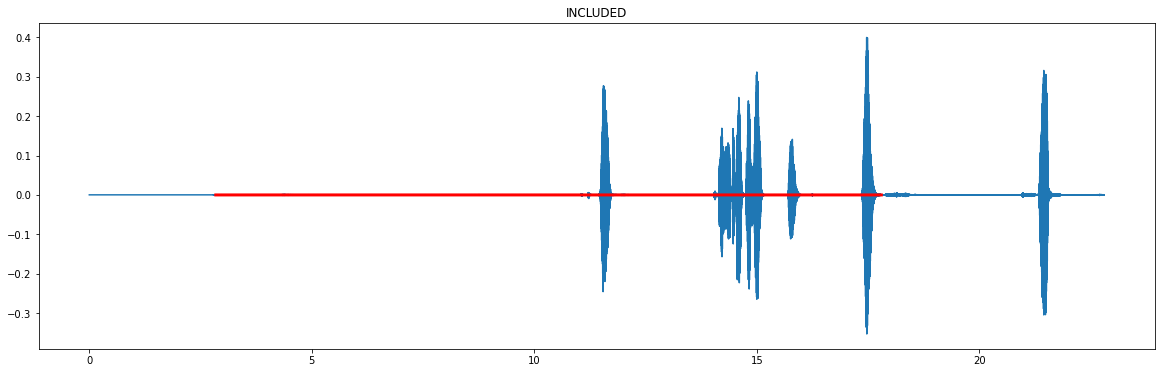

[NeMo I 2020-10-30 00:00:32 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:32 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |lô ce kỳ ớ cái nó chỳ vậy ờ nờ|


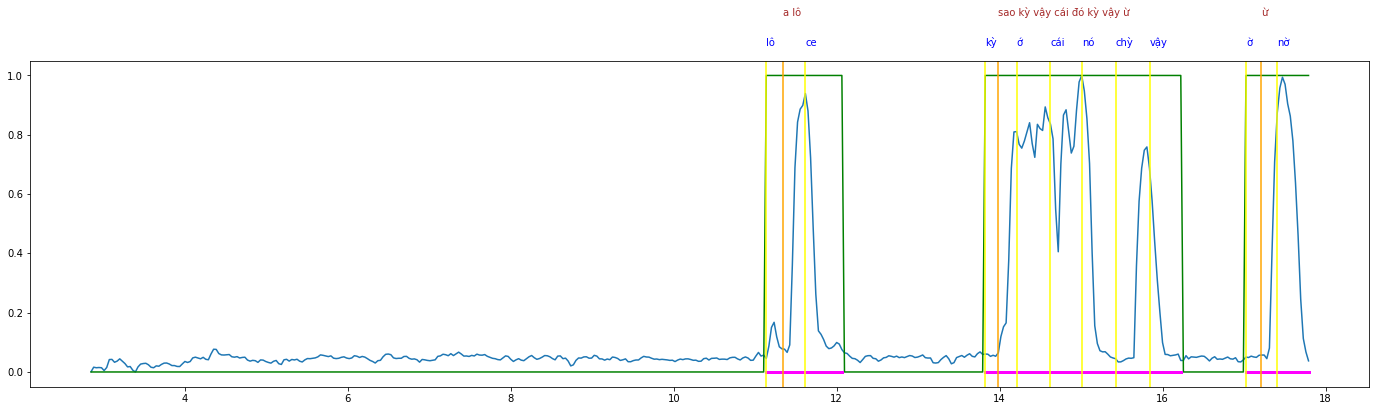

557 [0, 557]
READ_HEAD 557
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(16869, 16872)]
cutoff -78.44221105527639 #silences 28: [(637, 639), (654, 656), (666, 670), (686, 689), (1155, 1158), (2855, 2857), (2952, 2954), (3225, 3229), (3233, 3236), (3401, 3405)]
cutoff -78.13065326633166 #silences 106: [(0, 2), (18, 20), (23, 26), (67, 69), (314, 316), (488, 492), (634, 647), (652, 659), (663, 671), (686, 690)]
advance past silence 559 2
cutoff -77.81909547738694 #silences 269: [(14, 18), (21, 31), (34, 37), (65, 67), (125, 129), (309, 319), (398, 400), (419, 421), (434, 437), (485, 493)]
stop to read 559 573


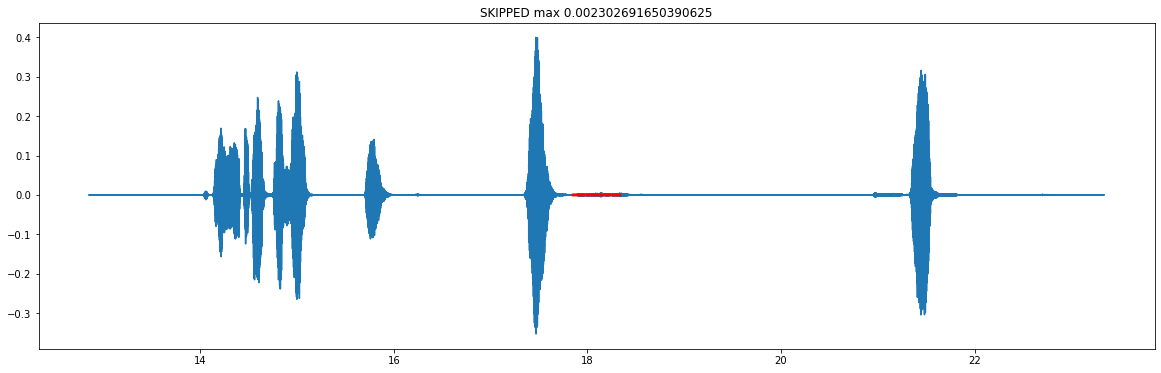

573 [0, 557, 573]
READ_HEAD 573
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(16853, 16856)]
cutoff -78.44221105527639 #silences 28: [(621, 623), (638, 640), (650, 654), (670, 673), (1139, 1142), (2839, 2841), (2936, 2938), (3209, 3213), (3217, 3220), (3385, 3389)]
stop to read 573 1194


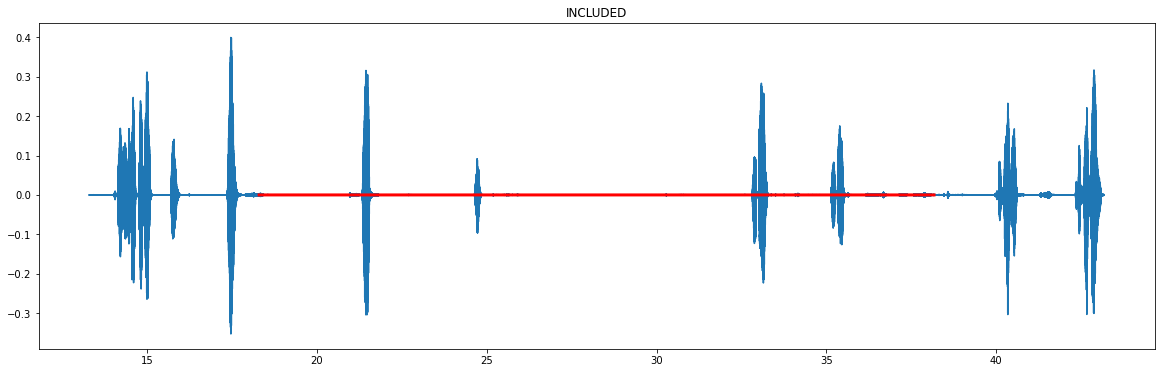

[NeMo I 2020-10-30 00:00:32 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:32 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |àô cá gì đi em đi|


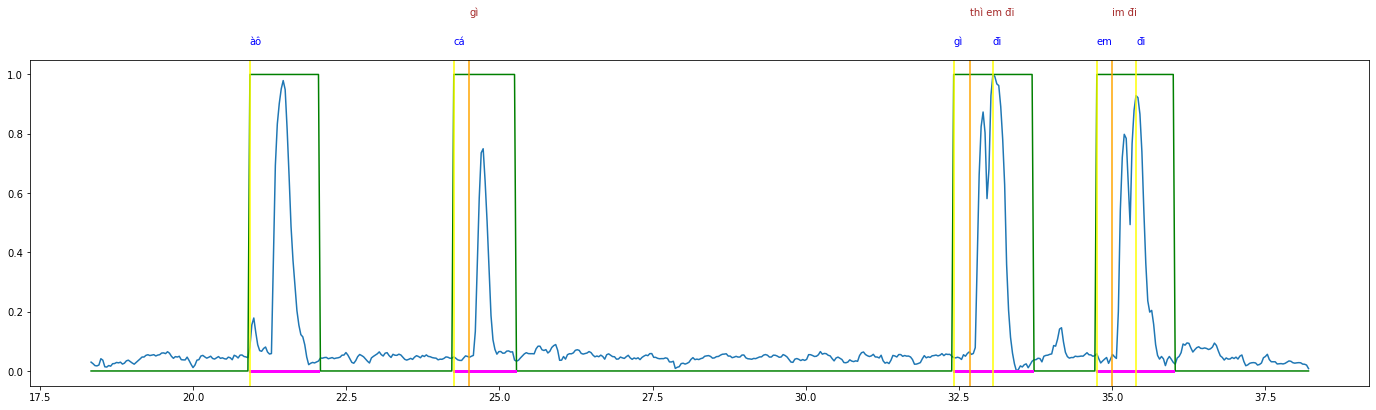

1194 [0, 557, 573, 1194]
READ_HEAD 1194
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(16232, 16235)]
cutoff -78.44221105527639 #silences 28: [(0, 2), (17, 19), (29, 33), (49, 52), (518, 521), (2218, 2220), (2315, 2317), (2588, 2592), (2596, 2599), (2764, 2768)]
advance past silence 1196 2
cutoff -78.13065326633166 #silences 100: [(0, 8), (13, 20), (24, 32), (47, 51), (270, 272), (516, 519), (798, 800), (811, 815), (1294, 1296), (1506, 1508)]
advance past silence 1204 8
cutoff -77.81909547738694 #silences 256: [(3, 25), (39, 43), (226, 228), (241, 243), (245, 248), (260, 267), (349, 354), (507, 511), (563, 565), (776, 780)]
stop to read 1204 1207


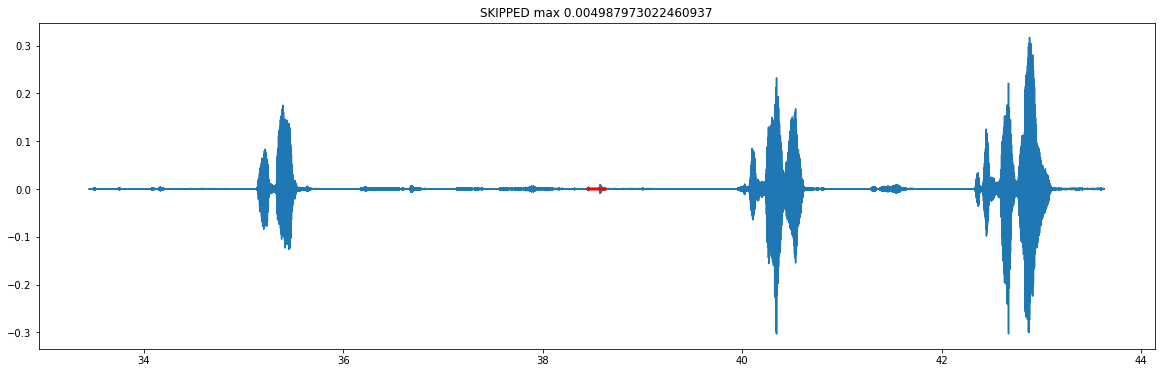

1207 [0, 557, 573, 1194, 1207]
READ_HEAD 1207
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(16219, 16222)]
cutoff -78.44221105527639 #silences 27: [(4, 6), (16, 20), (36, 39), (505, 508), (2205, 2207), (2302, 2304), (2575, 2579), (2583, 2586), (2751, 2755), (3001, 3003)]
stop to read 1207 1211


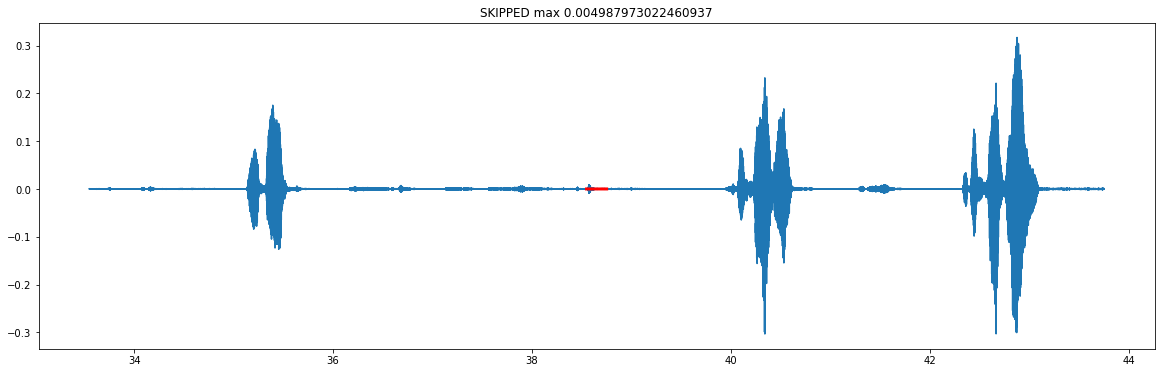

1211 [0, 557, 573, 1194, 1207, 1211]
READ_HEAD 1211
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(16215, 16218)]
cutoff -78.44221105527639 #silences 27: [(0, 2), (12, 16), (32, 35), (501, 504), (2201, 2203), (2298, 2300), (2571, 2575), (2579, 2582), (2747, 2751), (2997, 2999)]
advance past silence 1213 2
cutoff -78.13065326633166 #silences 99: [(0, 3), (7, 15), (30, 34), (253, 255), (499, 502), (781, 783), (794, 798), (1277, 1279), (1489, 1491), (1740, 1745)]
advance past silence 1216 3
cutoff -77.81909547738694 #silences 256: [(0, 13), (27, 31), (214, 216), (229, 231), (233, 236), (248, 255), (337, 342), (495, 499), (551, 553), (764, 768)]
advance past silence 1229 13
cutoff -77.50753768844221 #silences 456: [(13, 19), (47, 54), (57, 60), (63, 65), (73, 78), (80, 82), (84, 86), (165, 167), (181, 185), (201, 203)]
stop to read 1229 1242


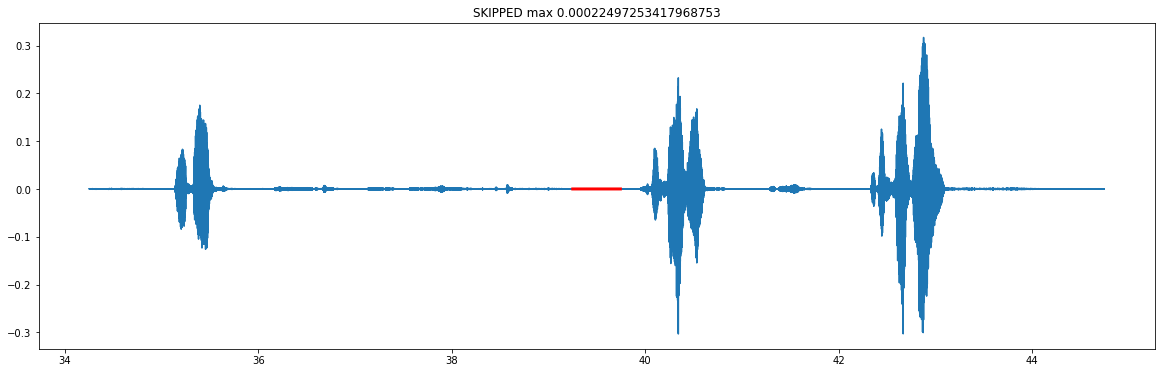

1242 [0, 557, 573, 1194, 1207, 1211, 1242]
READ_HEAD 1242
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(16184, 16187)]
cutoff -78.44221105527639 #silences 25: [(1, 4), (470, 473), (2170, 2172), (2267, 2269), (2540, 2544), (2548, 2551), (2716, 2720), (2966, 2968), (3781, 3784), (5318, 5320)]
stop to read 1242 1243


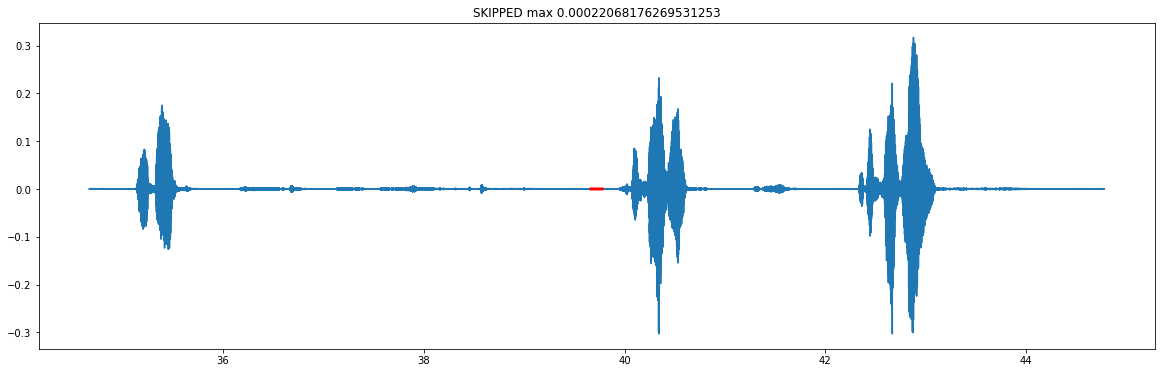

1243 [0, 557, 573, 1194, 1207, 1211, 1242, 1243]
READ_HEAD 1243
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(16183, 16186)]
cutoff -78.44221105527639 #silences 25: [(0, 3), (469, 472), (2169, 2171), (2266, 2268), (2539, 2543), (2547, 2550), (2715, 2719), (2965, 2967), (3780, 3783), (5317, 5319)]
advance past silence 1246 3
cutoff -78.13065326633166 #silences 96: [(220, 222), (466, 469), (748, 750), (761, 765), (1244, 1246), (1456, 1458), (1707, 1712), (1718, 1721), (2143, 2146), (2151, 2153)]
stop to read 1246 1466


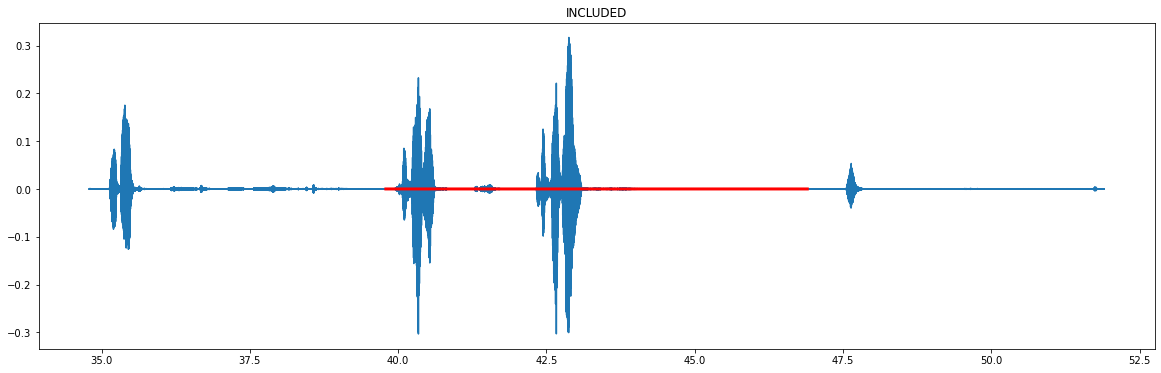

[NeMo I 2020-10-30 00:00:33 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:33 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |đi căng hải hả đi căng hải quan|


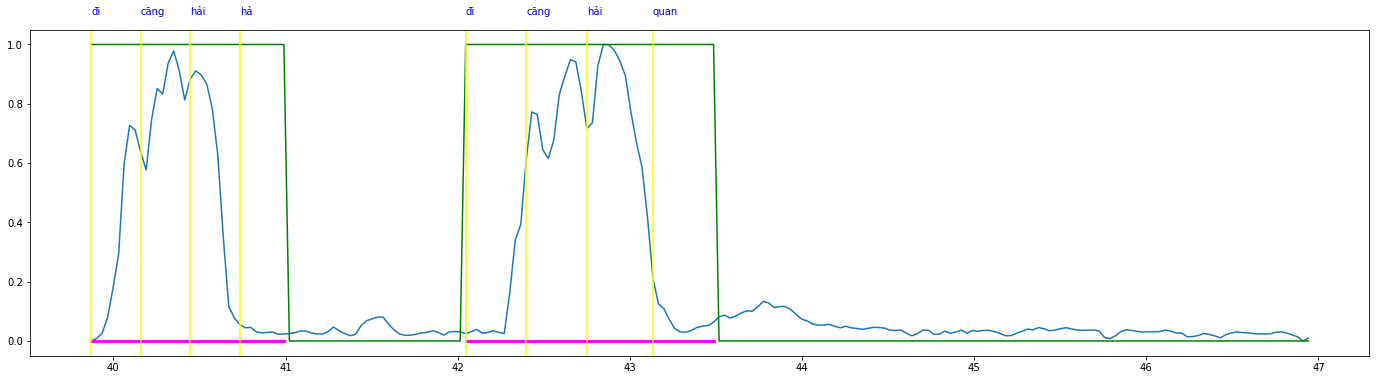

1466 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466]
READ_HEAD 1466
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(15960, 15963)]
cutoff -78.44221105527639 #silences 24: [(246, 249), (1946, 1948), (2043, 2045), (2316, 2320), (2324, 2327), (2492, 2496), (2742, 2744), (3557, 3560), (5094, 5096), (5677, 5679)]
stop to read 1466 1712


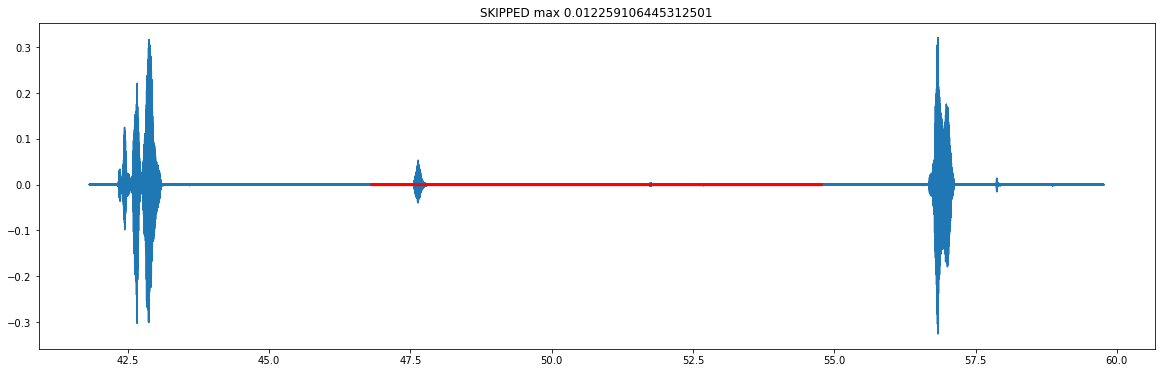

1712 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712]
READ_HEAD 1712
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(15714, 15717)]
cutoff -78.44221105527639 #silences 24: [(0, 3), (1700, 1702), (1797, 1799), (2070, 2074), (2078, 2081), (2246, 2250), (2496, 2498), (3311, 3314), (4848, 4850), (5431, 5433)]
advance past silence 1715 3
cutoff -78.13065326633166 #silences 94: [(279, 281), (292, 296), (775, 777), (987, 989), (1238, 1243), (1249, 1252), (1674, 1677), (1682, 1684), (1696, 1701), (1716, 1726)]
stop to read 1715 1994


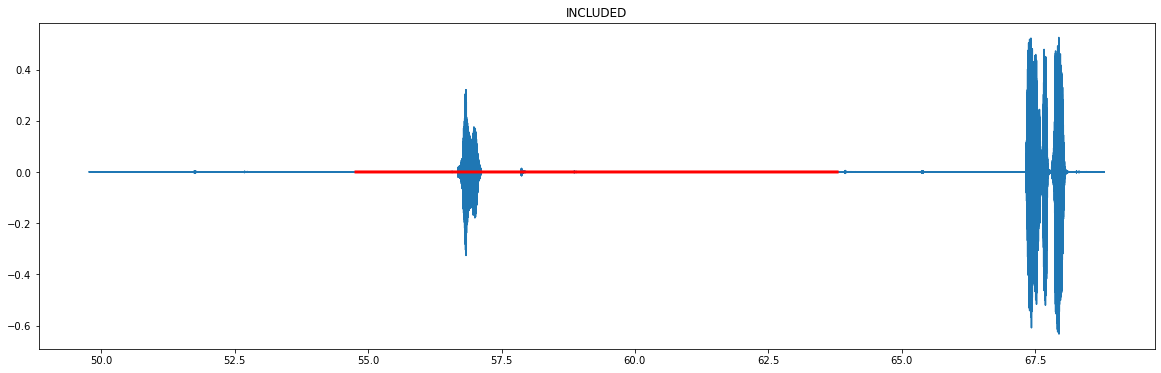

[NeMo I 2020-10-30 00:00:34 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:34 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |chồ|


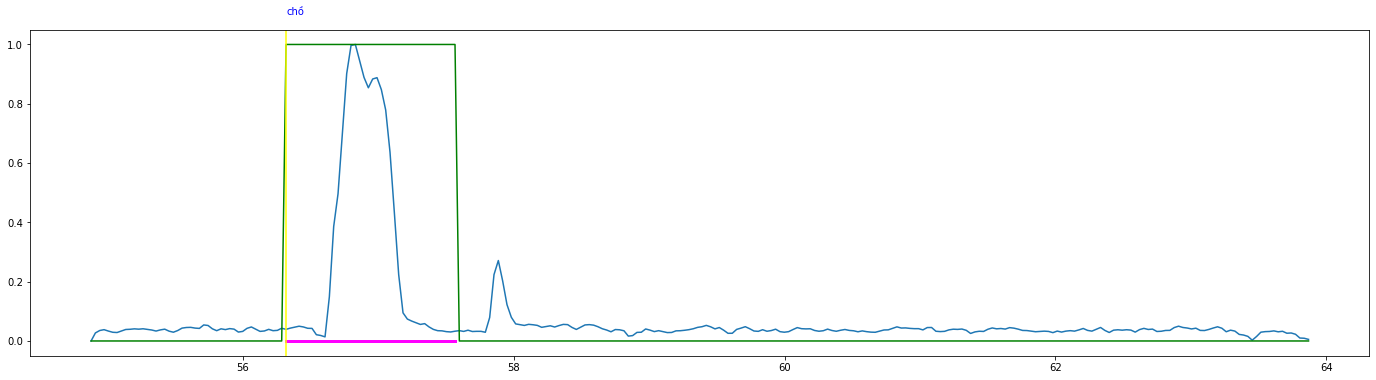

1994 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994]
READ_HEAD 1994
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(15432, 15435)]
cutoff -78.44221105527639 #silences 23: [(1418, 1420), (1515, 1517), (1788, 1792), (1796, 1799), (1964, 1968), (2214, 2216), (3029, 3032), (4566, 4568), (5149, 5151), (5594, 5598)]
cutoff -78.13065326633166 #silences 94: [(0, 2), (13, 17), (496, 498), (708, 710), (959, 964), (970, 973), (1395, 1398), (1403, 1405), (1417, 1422), (1437, 1447)]
advance past silence 1996 2
cutoff -77.81909547738694 #silences 245: [(7, 16), (28, 33), (139, 141), (145, 147), (494, 498), (598, 600), (603, 605), (687, 691), (705, 709), (724, 727)]
stop to read 1996 2003


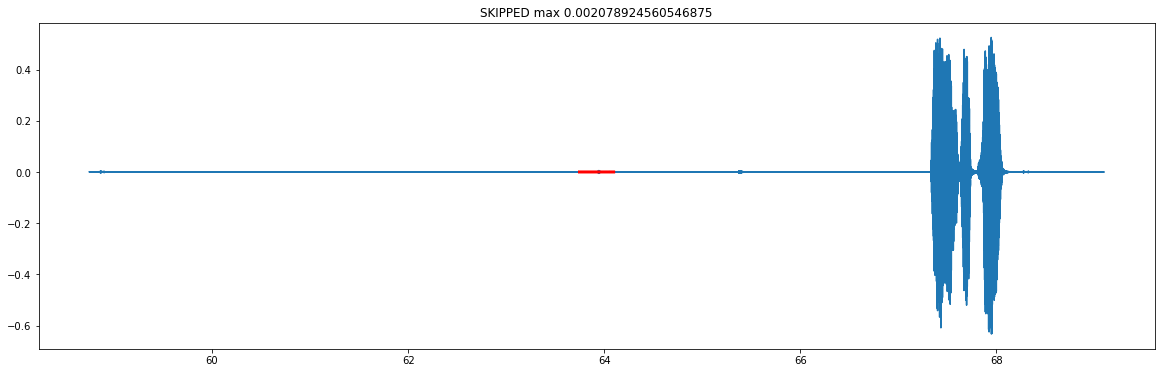

2003 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003]
READ_HEAD 2003
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(15423, 15426)]
cutoff -78.44221105527639 #silences 23: [(1409, 1411), (1506, 1508), (1779, 1783), (1787, 1790), (1955, 1959), (2205, 2207), (3020, 3023), (4557, 4559), (5140, 5142), (5585, 5589)]
cutoff -78.13065326633166 #silences 93: [(4, 8), (487, 489), (699, 701), (950, 955), (961, 964), (1386, 1389), (1394, 1396), (1408, 1413), (1428, 1438), (1453, 1456)]
stop to read 2003 2007


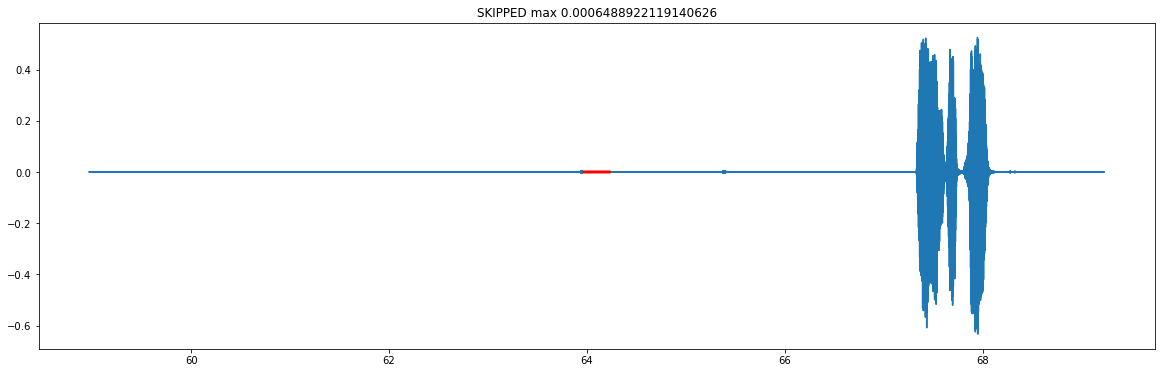

2007 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007]
READ_HEAD 2007
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(15419, 15422)]
cutoff -78.44221105527639 #silences 23: [(1405, 1407), (1502, 1504), (1775, 1779), (1783, 1786), (1951, 1955), (2201, 2203), (3016, 3019), (4553, 4555), (5136, 5138), (5581, 5585)]
cutoff -78.13065326633166 #silences 93: [(0, 4), (483, 485), (695, 697), (946, 951), (957, 960), (1382, 1385), (1390, 1392), (1404, 1409), (1424, 1434), (1449, 1452)]
advance past silence 2011 4
cutoff -77.81909547738694 #silences 244: [(13, 18), (124, 126), (130, 132), (479, 483), (583, 585), (588, 590), (672, 676), (690, 694), (709, 712), (714, 720)]
stop to read 2011 2024


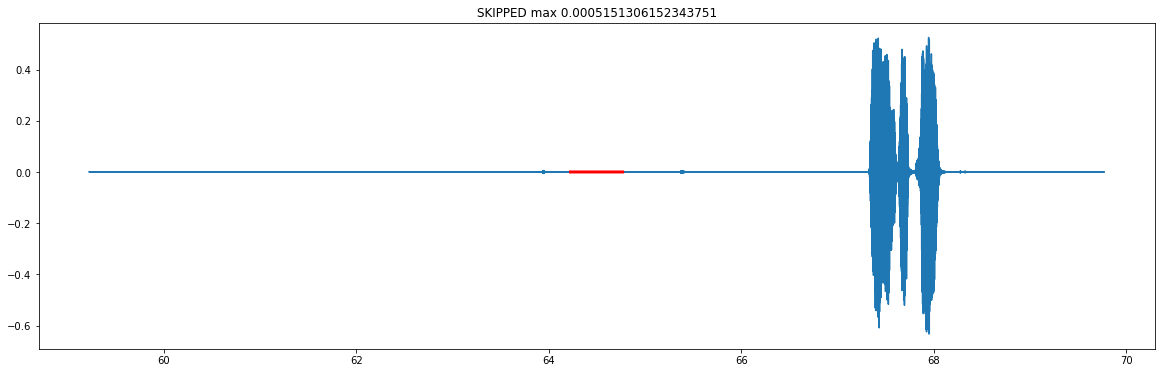

2024 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024]
READ_HEAD 2024
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(15402, 15405)]
cutoff -78.44221105527639 #silences 23: [(1388, 1390), (1485, 1487), (1758, 1762), (1766, 1769), (1934, 1938), (2184, 2186), (2999, 3002), (4536, 4538), (5119, 5121), (5564, 5568)]
cutoff -78.13065326633166 #silences 92: [(466, 468), (678, 680), (929, 934), (940, 943), (1365, 1368), (1373, 1375), (1387, 1392), (1407, 1417), (1432, 1435), (1482, 1487)]
stop to read 2024 2490


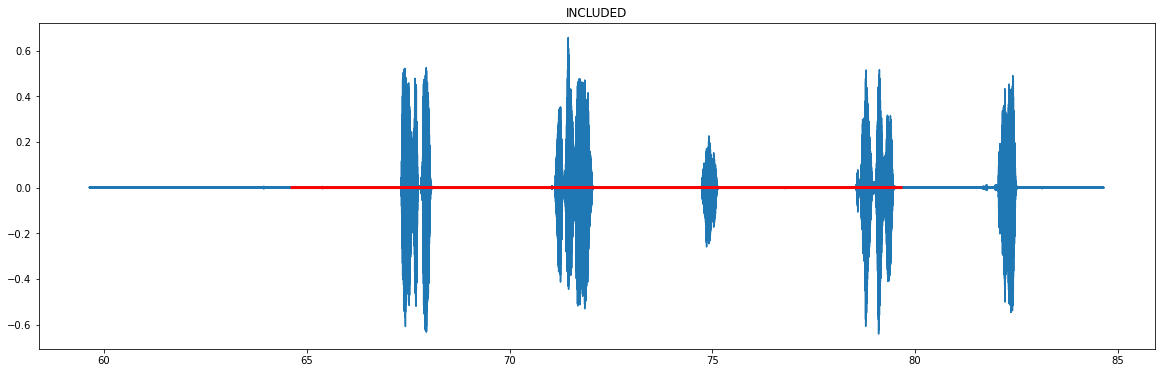

[NeMo I 2020-10-30 00:00:34 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:34 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |rản ra chị hón có choi đ chưa chì cón đi khon mà Loo|


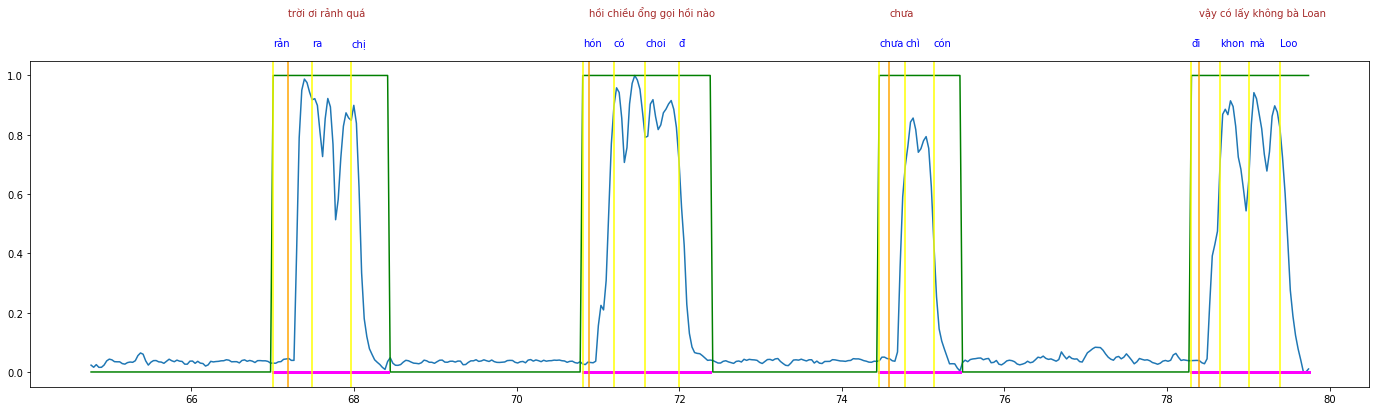

2490 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490]
READ_HEAD 2490
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(14936, 14939)]
cutoff -78.44221105527639 #silences 23: [(922, 924), (1019, 1021), (1292, 1296), (1300, 1303), (1468, 1472), (1718, 1720), (2533, 2536), (4070, 4072), (4653, 4655), (5098, 5102)]
cutoff -78.13065326633166 #silences 92: [(0, 2), (212, 214), (463, 468), (474, 477), (899, 902), (907, 909), (921, 926), (941, 951), (966, 969), (1016, 1021)]
advance past silence 2492 2
cutoff -77.81909547738694 #silences 241: [(0, 2), (102, 104), (107, 109), (191, 195), (209, 213), (228, 231), (233, 239), (460, 470), (472, 475), (897, 907)]
advance past silence 2494 2
cutoff -77.50753768844221 #silences 403: [(0, 3), (94, 96), (98, 110), (146, 148), (159, 161), (188, 219), (224, 238), (241, 260), (

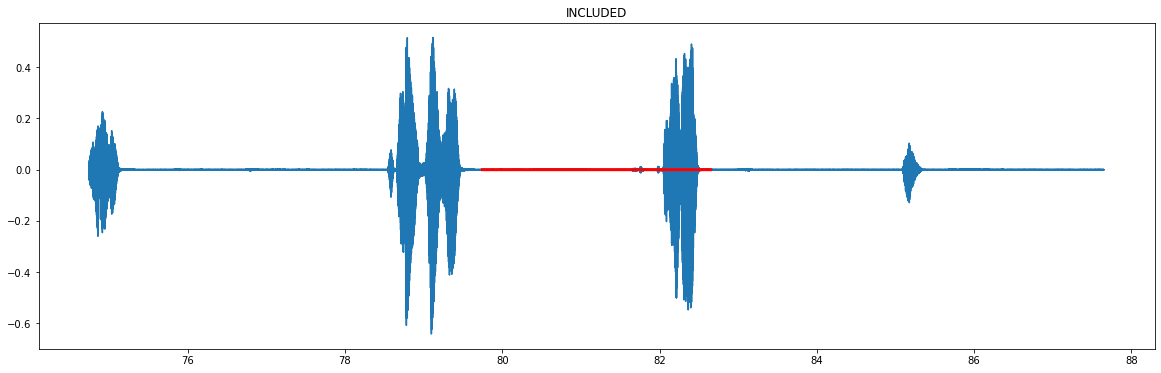

[NeMo I 2020-10-30 00:00:35 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:35 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ta nói đi đó|


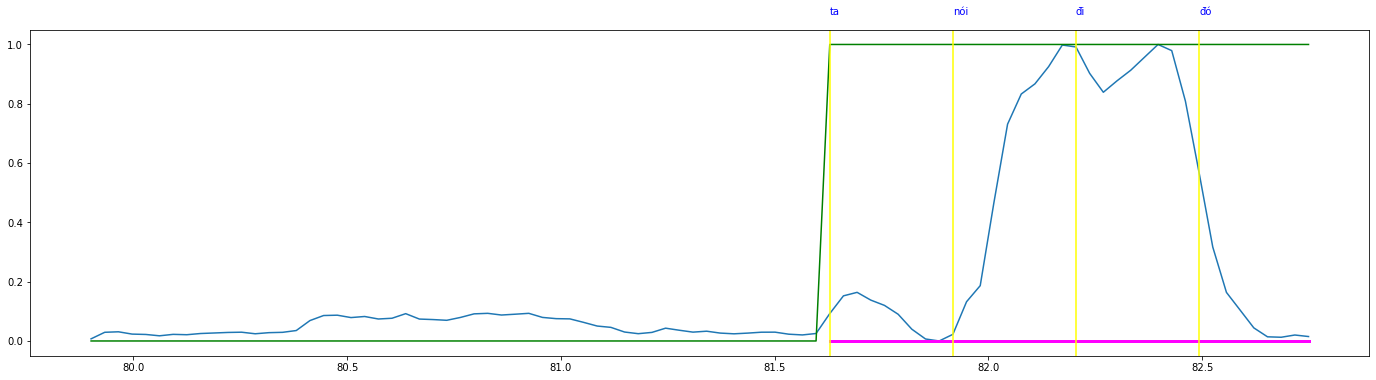

2583 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583]
READ_HEAD 2583
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(14843, 14846)]
cutoff -78.44221105527639 #silences 23: [(829, 831), (926, 928), (1199, 1203), (1207, 1210), (1375, 1379), (1625, 1627), (2440, 2443), (3977, 3979), (4560, 4562), (5005, 5009)]
cutoff -78.13065326633166 #silences 91: [(119, 121), (370, 375), (381, 384), (806, 809), (814, 816), (828, 833), (848, 858), (873, 876), (923, 928), (978, 984)]
stop to read 2583 2702


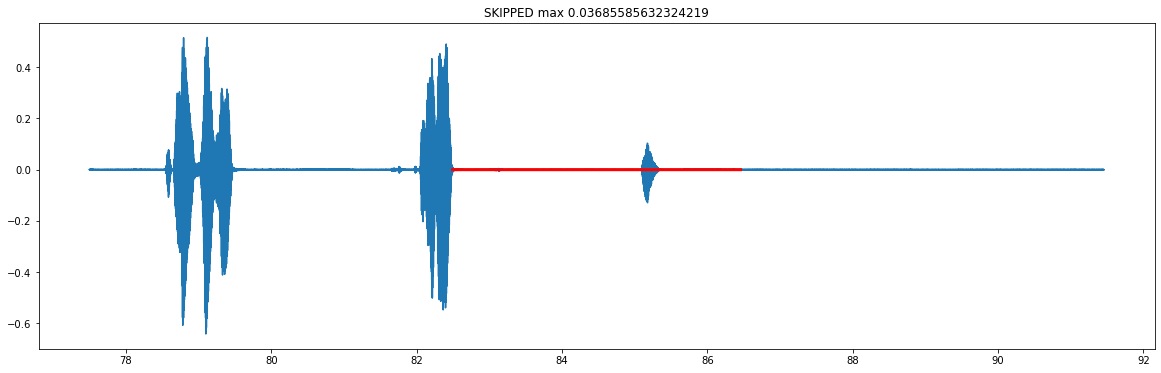

2702 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702]
READ_HEAD 2702
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(14724, 14727)]
cutoff -78.44221105527639 #silences 23: [(710, 712), (807, 809), (1080, 1084), (1088, 1091), (1256, 1260), (1506, 1508), (2321, 2324), (3858, 3860), (4441, 4443), (4886, 4890)]
cutoff -78.13065326633166 #silences 91: [(0, 2), (251, 256), (262, 265), (687, 690), (695, 697), (709, 714), (729, 739), (754, 757), (804, 809), (859, 865)]
advance past silence 2704 2
cutoff -77.81909547738694 #silences 236: [(16, 19), (21, 27), (248, 258), (260, 263), (685, 695), (707, 712), (714, 717), (726, 738), (750, 762), (801, 807)]
stop to read 2704 2720


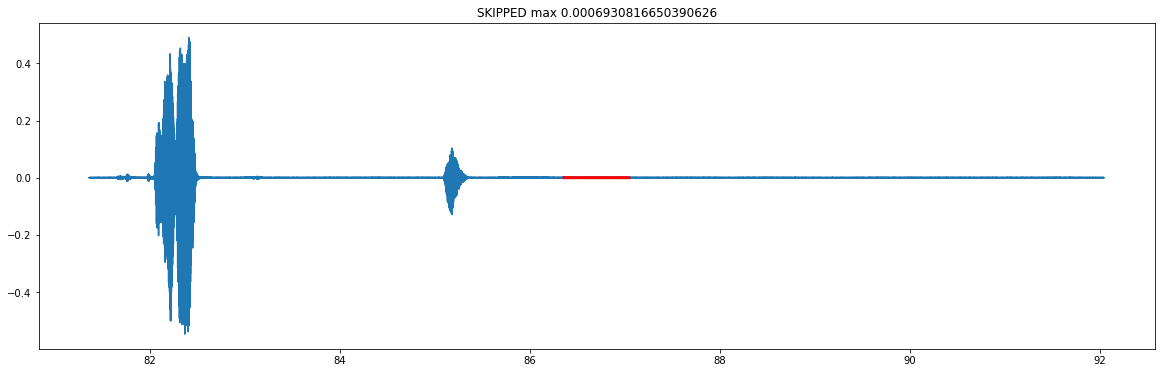

2720 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720]
READ_HEAD 2720
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(14706, 14709)]
cutoff -78.44221105527639 #silences 23: [(692, 694), (789, 791), (1062, 1066), (1070, 1073), (1238, 1242), (1488, 1490), (2303, 2306), (3840, 3842), (4423, 4425), (4868, 4872)]
cutoff -78.13065326633166 #silences 90: [(233, 238), (244, 247), (669, 672), (677, 679), (691, 696), (711, 721), (736, 739), (786, 791), (841, 847), (851, 853)]
stop to read 2720 2953


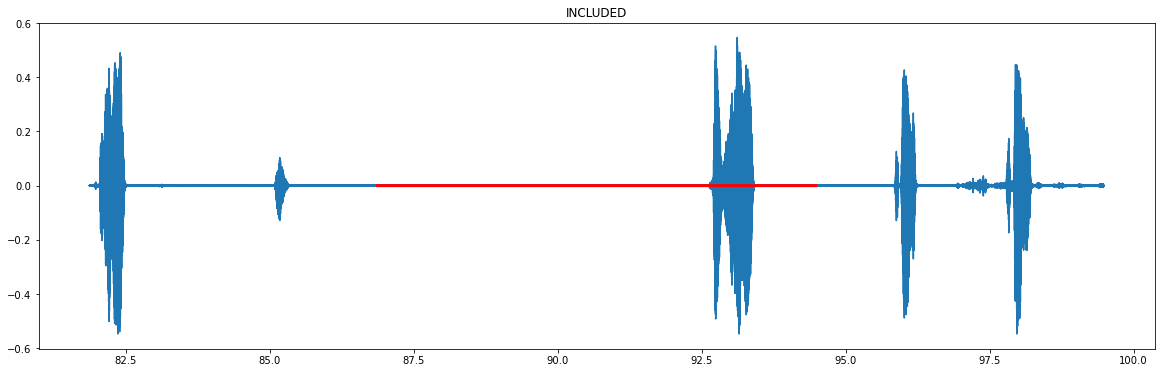

[NeMo I 2020-10-30 00:00:35 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:35 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ă người đó|


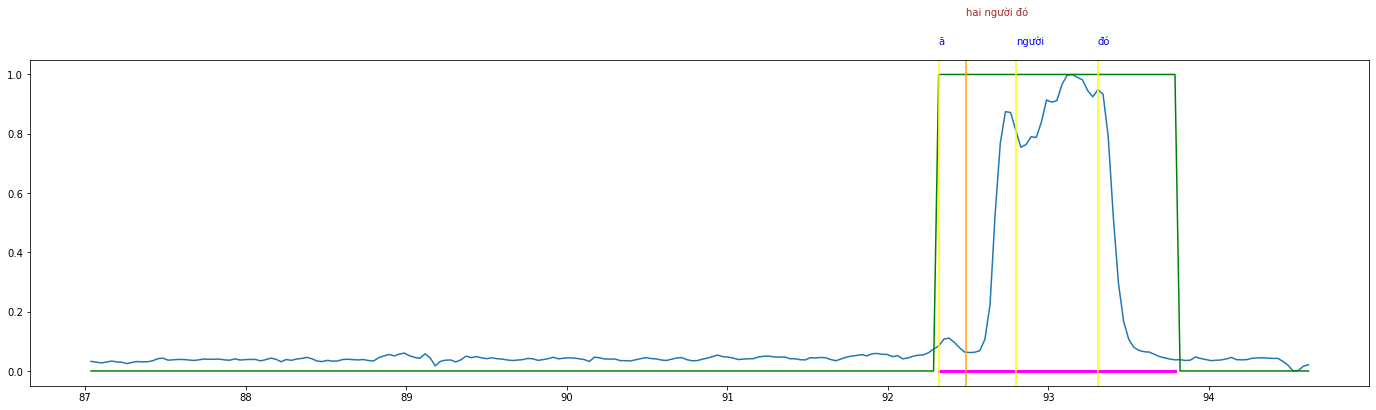

2953 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953]
READ_HEAD 2953
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(14473, 14476)]
cutoff -78.44221105527639 #silences 23: [(459, 461), (556, 558), (829, 833), (837, 840), (1005, 1009), (1255, 1257), (2070, 2073), (3607, 3609), (4190, 4192), (4635, 4639)]
stop to read 2953 3412


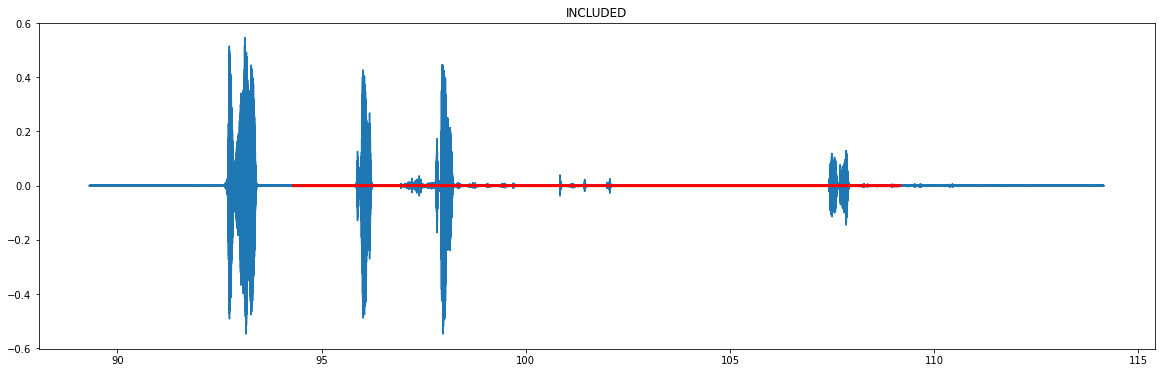

[NeMo I 2020-10-30 00:00:36 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:36 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |chệi ẽ i i về qoàn ấy đững|


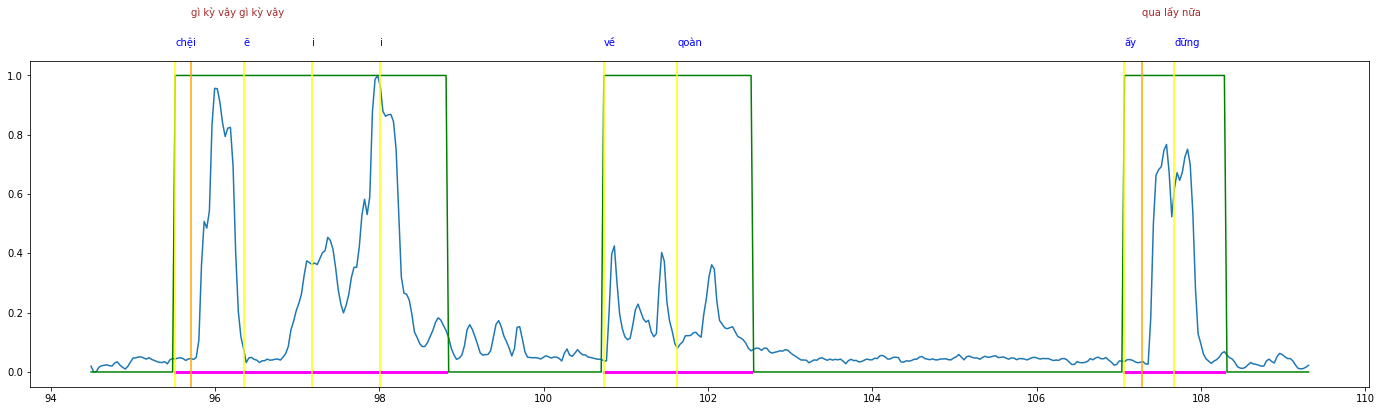

3412 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412]
READ_HEAD 3412
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(14014, 14017)]
cutoff -78.44221105527639 #silences 23: [(0, 2), (97, 99), (370, 374), (378, 381), (546, 550), (796, 798), (1611, 1614), (3148, 3150), (3731, 3733), (4176, 4180)]
advance past silence 3414 2
cutoff -78.13065326633166 #silences 86: [(0, 2), (17, 27), (42, 45), (92, 97), (147, 153), (157, 159), (293, 301), (366, 372), (375, 380), (383, 386)]
advance past silence 3416 2
cutoff -77.81909547738694 #silences 230: [(2, 5), (14, 26), (38, 50), (89, 95), (99, 104), (113, 116), (120, 123), (141, 152), (154, 158), (160, 163)]
stop to read 3416 3418


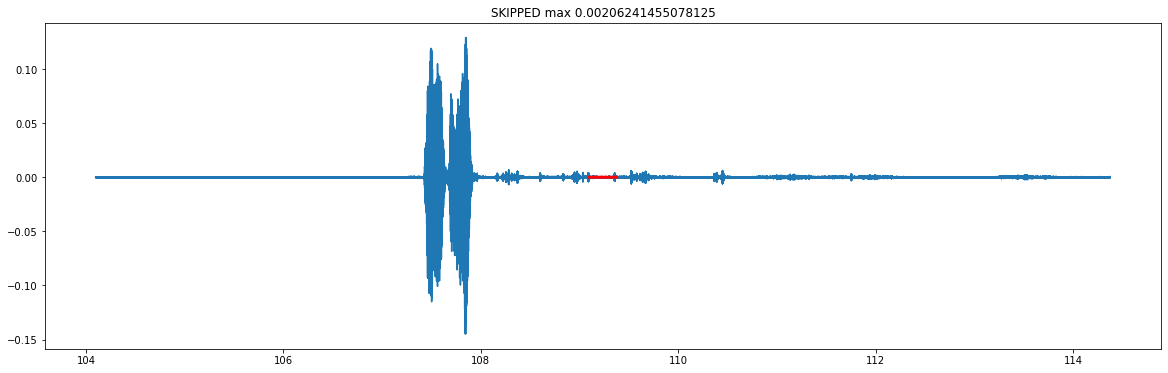

3418 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418]
READ_HEAD 3418
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(14008, 14011)]
cutoff -78.44221105527639 #silences 22: [(91, 93), (364, 368), (372, 375), (540, 544), (790, 792), (1605, 1608), (3142, 3144), (3725, 3727), (4170, 4174), (6620, 6623)]
stop to read 3418 3509


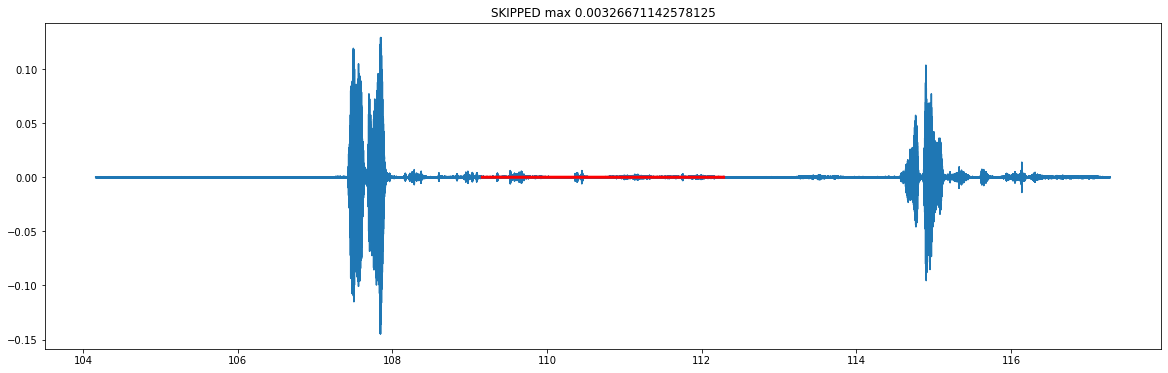

3509 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509]
READ_HEAD 3509
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13917, 13920)]
cutoff -78.44221105527639 #silences 22: [(0, 2), (273, 277), (281, 284), (449, 453), (699, 701), (1514, 1517), (3051, 3053), (3634, 3636), (4079, 4083), (6529, 6532)]
advance past silence 3511 2
cutoff -78.13065326633166 #silences 82: [(50, 56), (60, 62), (196, 204), (269, 275), (278, 283), (286, 289), (298, 301), (441, 452), (473, 477), (480, 484)]
stop to read 3511 3561


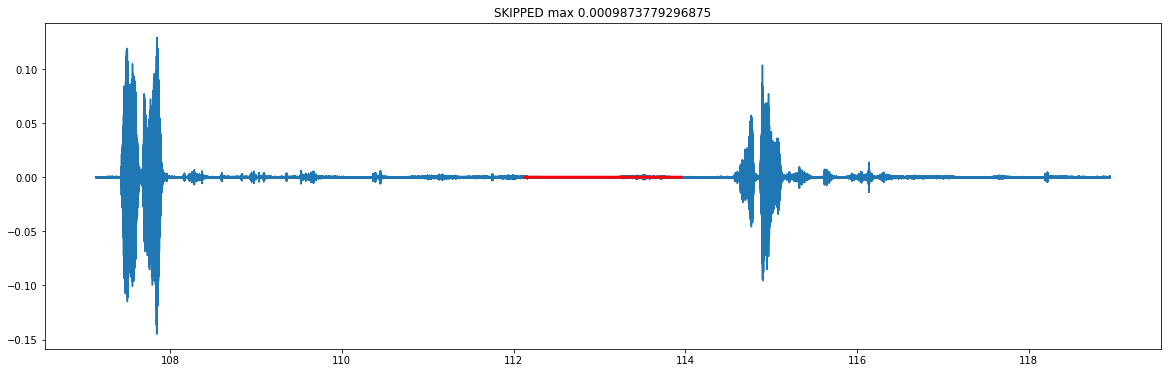

3561 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561]
READ_HEAD 3561
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13865, 13868)]
cutoff -78.44221105527639 #silences 21: [(221, 225), (229, 232), (397, 401), (647, 649), (1462, 1465), (2999, 3001), (3582, 3584), (4027, 4031), (6477, 6480), (7090, 7092)]
stop to read 3561 3782


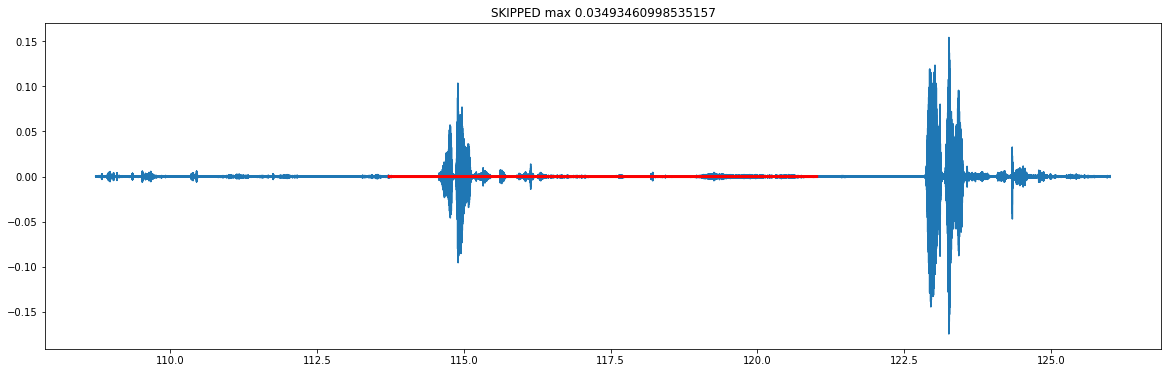

3782 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782]
READ_HEAD 3782
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13644, 13647)]
cutoff -78.44221105527639 #silences 21: [(0, 4), (8, 11), (176, 180), (426, 428), (1241, 1244), (2778, 2780), (3361, 3363), (3806, 3810), (6256, 6259), (6869, 6871)]
advance past silence 3786 4
cutoff -78.13065326633166 #silences 78: [(3, 8), (11, 14), (23, 26), (166, 177), (198, 202), (205, 209), (421, 424), (1236, 1243), (1247, 1249), (1444, 1447)]
stop to read 3786 3789


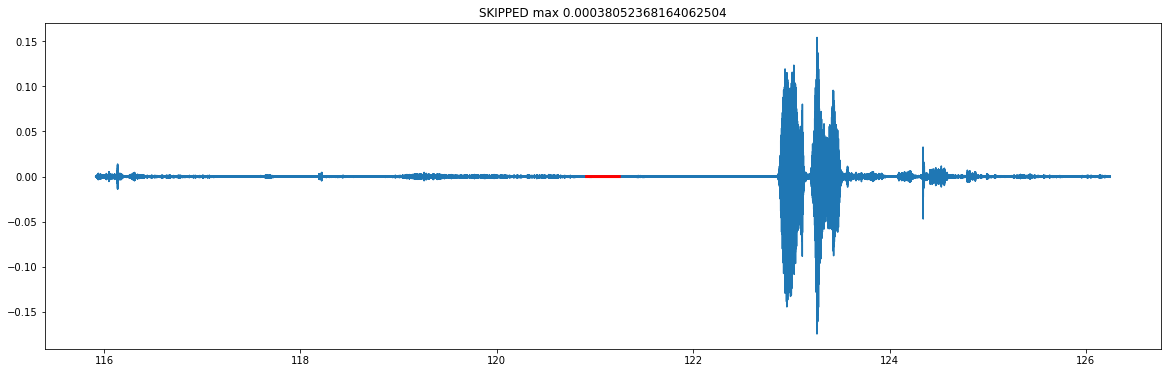

3789 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789]
READ_HEAD 3789
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13637, 13640)]
cutoff -78.44221105527639 #silences 20: [(1, 4), (169, 173), (419, 421), (1234, 1237), (2771, 2773), (3354, 3356), (3799, 3803), (6249, 6252), (6862, 6864), (8646, 8648)]
stop to read 3789 3790


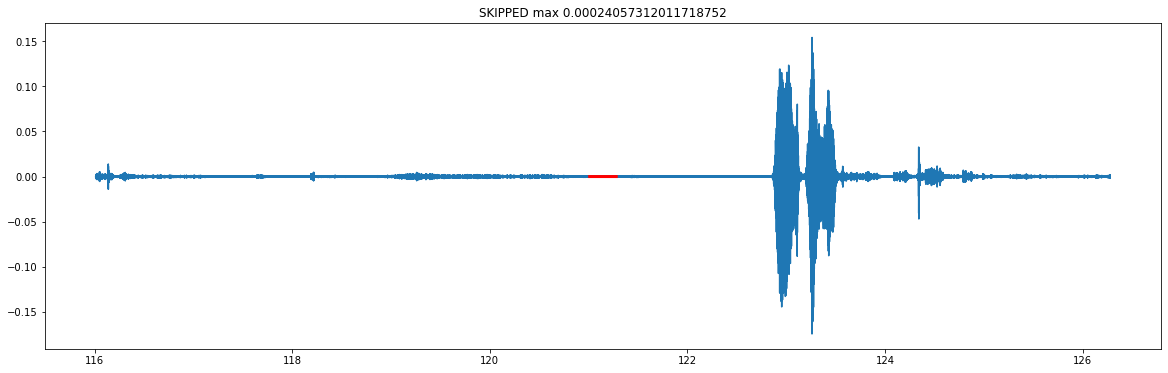

3790 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790]
READ_HEAD 3790
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13636, 13639)]
cutoff -78.44221105527639 #silences 20: [(0, 3), (168, 172), (418, 420), (1233, 1236), (2770, 2772), (3353, 3355), (3798, 3802), (6248, 6251), (6861, 6863), (8645, 8647)]
advance past silence 3793 3
cutoff -78.13065326633166 #silences 77: [(4, 7), (16, 19), (159, 170), (191, 195), (198, 202), (414, 417), (1229, 1236), (1240, 1242), (1437, 1440), (1534, 1536)]
stop to read 3793 3797


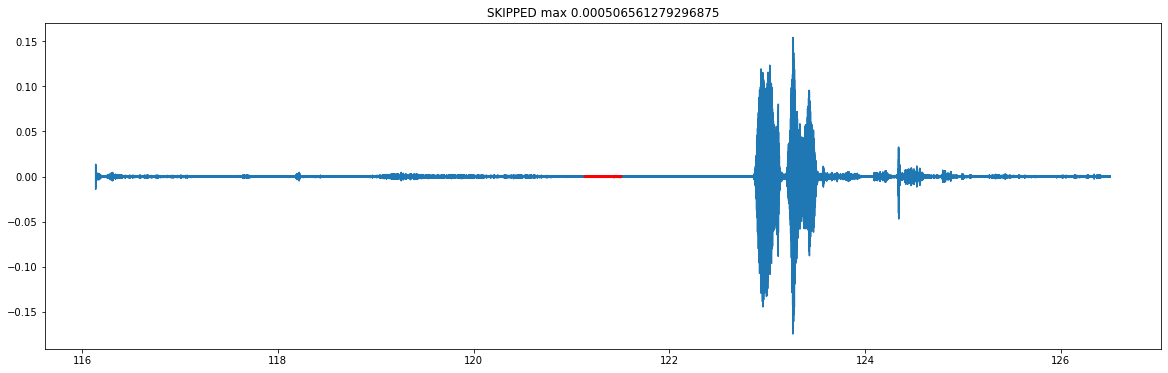

3797 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797]
READ_HEAD 3797
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13629, 13632)]
cutoff -78.44221105527639 #silences 19: [(161, 165), (411, 413), (1226, 1229), (2763, 2765), (3346, 3348), (3791, 3795), (6241, 6244), (6854, 6856), (8638, 8640), (10671, 10673)]
stop to read 3797 3958


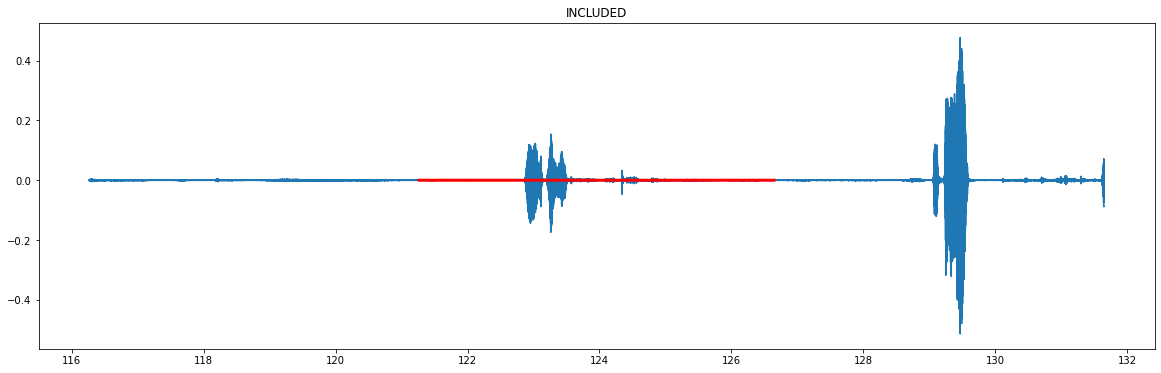

[NeMo I 2020-10-30 00:00:37 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:37 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừ để chều đi|


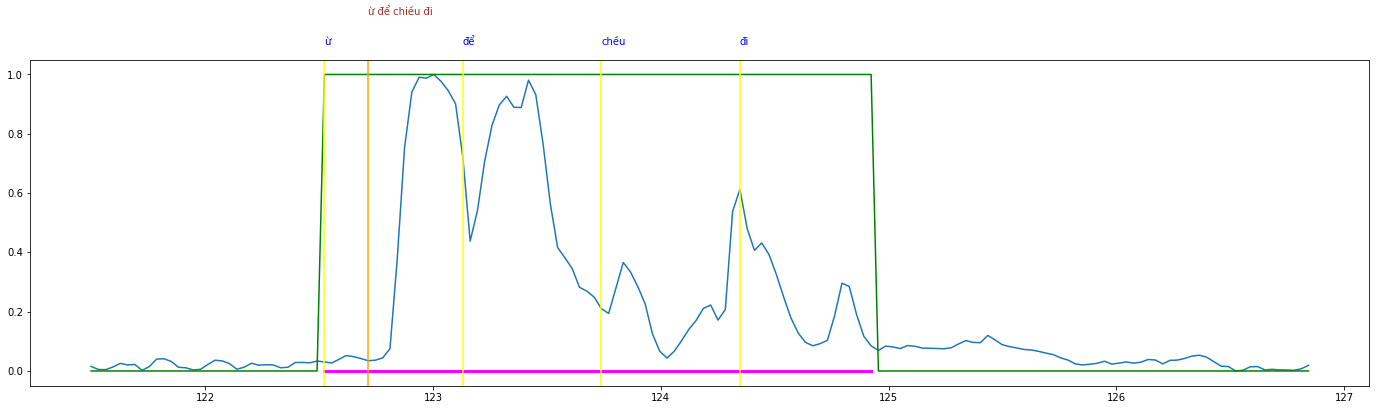

3958 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958]
READ_HEAD 3958
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13468, 13471)]
cutoff -78.44221105527639 #silences 19: [(0, 4), (250, 252), (1065, 1068), (2602, 2604), (3185, 3187), (3630, 3634), (6080, 6083), (6693, 6695), (8477, 8479), (10510, 10512)]
advance past silence 3962 4
cutoff -78.13065326633166 #silences 74: [(22, 26), (29, 33), (245, 248), (1060, 1067), (1071, 1073), (1268, 1271), (1365, 1367), (2595, 2604), (2609, 2612), (2737, 2740)]
stop to read 3962 3984


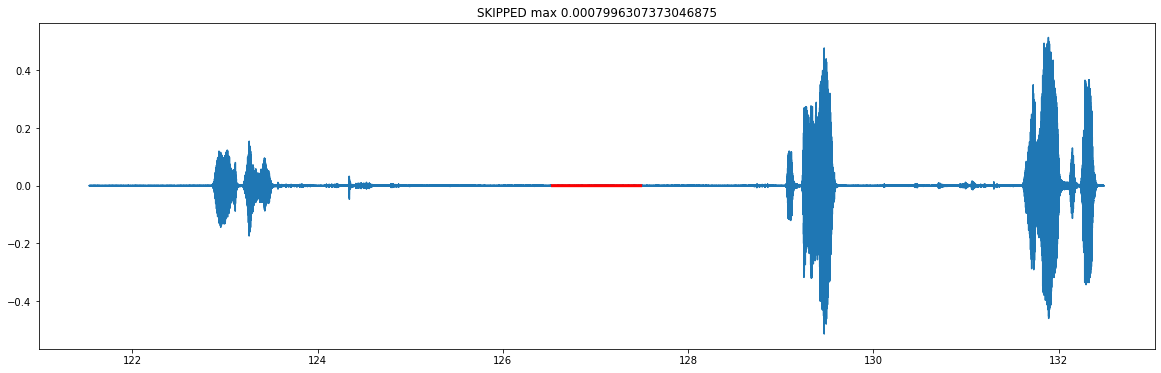

3984 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984]
READ_HEAD 3984
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13442, 13445)]
cutoff -78.44221105527639 #silences 18: [(224, 226), (1039, 1042), (2576, 2578), (3159, 3161), (3604, 3608), (6054, 6057), (6667, 6669), (8451, 8453), (10484, 10486), (13439, 13449)]
stop to read 3984 4208


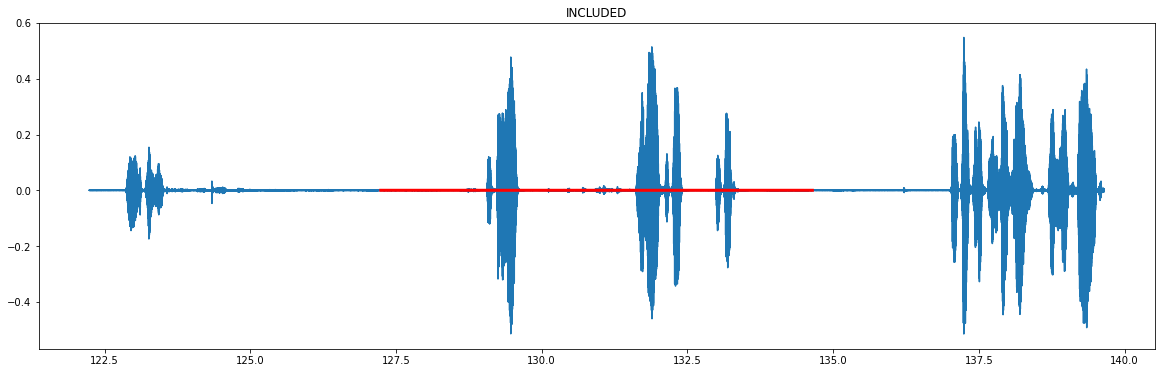

[NeMo I 2020-10-30 00:00:37 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:37 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |mì chị hả ủa Lon mà sao mẹ dan|


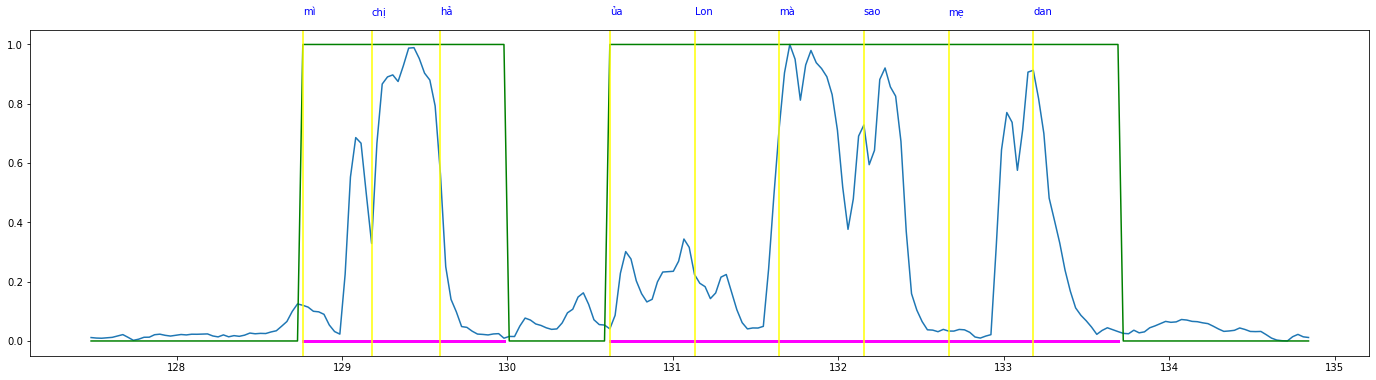

4208 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208]
READ_HEAD 4208
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13218, 13221)]
cutoff -78.44221105527639 #silences 18: [(0, 2), (815, 818), (2352, 2354), (2935, 2937), (3380, 3384), (5830, 5833), (6443, 6445), (8227, 8229), (10260, 10262), (13215, 13225)]
advance past silence 4210 2
cutoff -78.13065326633166 #silences 71: [(812, 819), (823, 825), (1020, 1023), (1117, 1119), (2347, 2356), (2361, 2364), (2489, 2492), (2933, 2936), (2944, 2946), (3211, 3214)]
cutoff -77.81909547738694 #silences 205: [(3, 8), (19, 21), (36, 38), (246, 248), (261, 265), (360, 366), (389, 391), (399, 407), (590, 593), (597, 600)]
stop to read 4210 4213


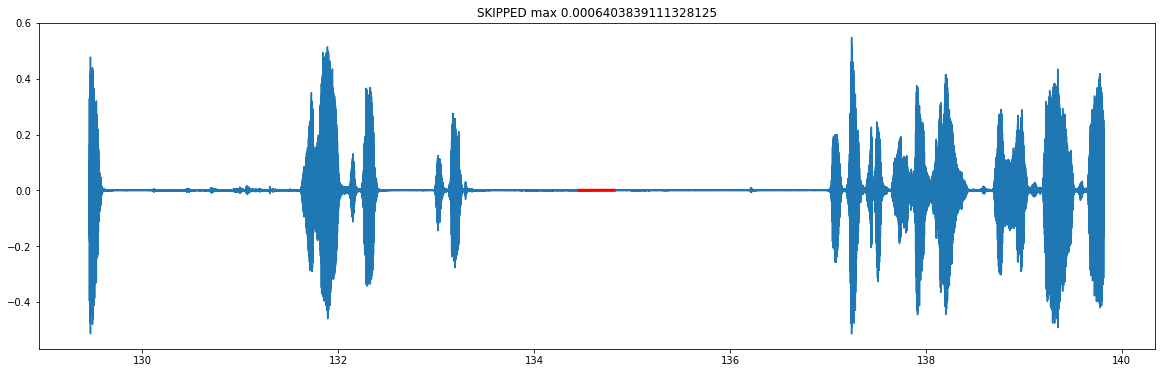

4213 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213]
READ_HEAD 4213
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13213, 13216)]
cutoff -78.44221105527639 #silences 17: [(810, 813), (2347, 2349), (2930, 2932), (3375, 3379), (5825, 5828), (6438, 6440), (8222, 8224), (10255, 10257), (13210, 13220), (13224, 13226)]
cutoff -78.13065326633166 #silences 71: [(809, 816), (820, 822), (1017, 1020), (1114, 1116), (2344, 2353), (2358, 2361), (2486, 2489), (2930, 2933), (2941, 2943), (3208, 3211)]
cutoff -77.81909547738694 #silences 205: [(0, 5), (16, 18), (33, 35), (243, 245), (258, 262), (357, 363), (386, 388), (396, 404), (587, 590), (594, 597)]
advance past silence 4218 5
cutoff -77.50753768844221 #silences 349: [(7

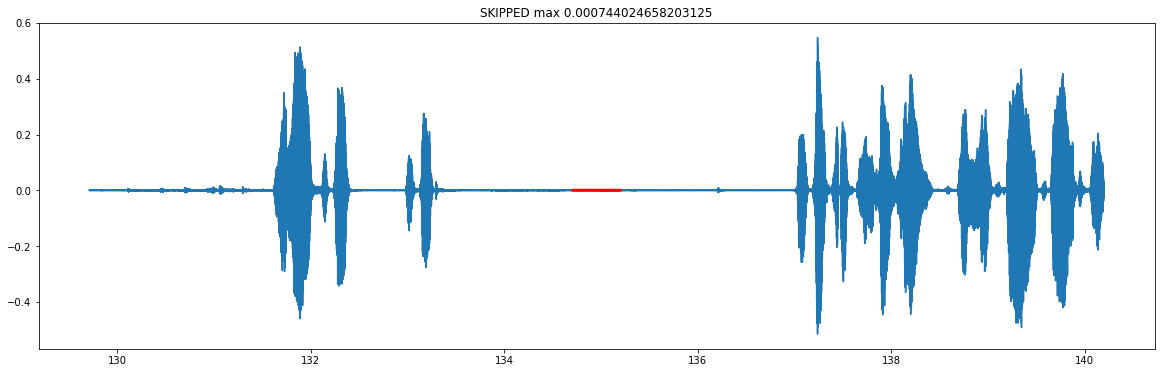

4225 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225]
READ_HEAD 4225
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13201, 13204)]
cutoff -78.44221105527639 #silences 17: [(798, 801), (2335, 2337), (2918, 2920), (3363, 3367), (5813, 5816), (6426, 6428), (8210, 8212), (10243, 10245), (13198, 13208), (13212, 13214)]
cutoff -78.13065326633166 #silences 71: [(797, 804), (808, 810), (1005, 1008), (1102, 1104), (2332, 2341), (2346, 2349), (2474, 2477), (2918, 2921), (2929, 2931), (3196, 3199)]
cutoff -77.81909547738694 #silences 204: [(4, 6), (21, 23), (231, 233), (246, 250), (345, 351), (374, 376), (384, 392), (575, 578), (582, 585), (588, 591)]
stop to read 4225 4229


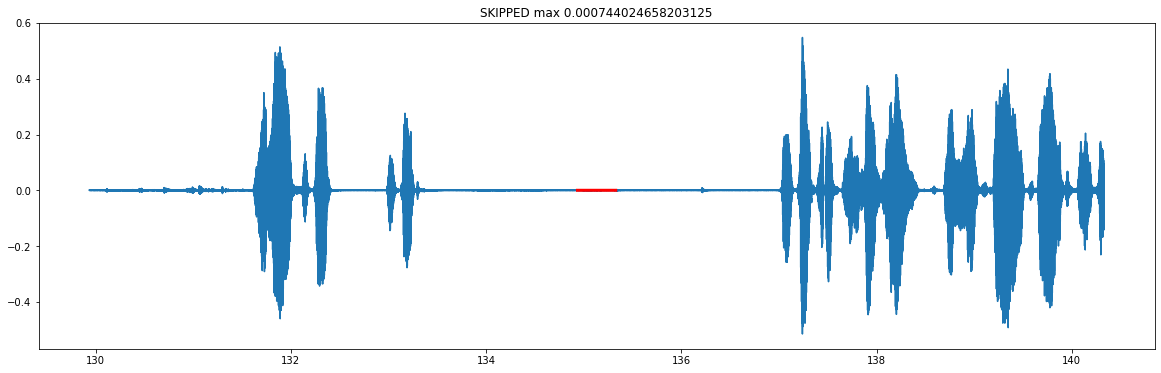

4229 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229]
READ_HEAD 4229
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13197, 13200)]
cutoff -78.44221105527639 #silences 17: [(794, 797), (2331, 2333), (2914, 2916), (3359, 3363), (5809, 5812), (6422, 6424), (8206, 8208), (10239, 10241), (13194, 13204), (13208, 13210)]
cutoff -78.13065326633166 #silences 71: [(793, 800), (804, 806), (1001, 1004), (1098, 1100), (2328, 2337), (2342, 2345), (2470, 2473), (2914, 2917), (2925, 2927), (3192, 3195)]
cutoff -77.81909547738694 #silences 204: [(0, 2), (17, 19), (227, 229), (242, 246), (341, 347), (370, 372), (380, 388), (571, 574), (578, 581), (584, 587)]
advance past silence 4231 2
cutoff -77.50753768844221 #sil

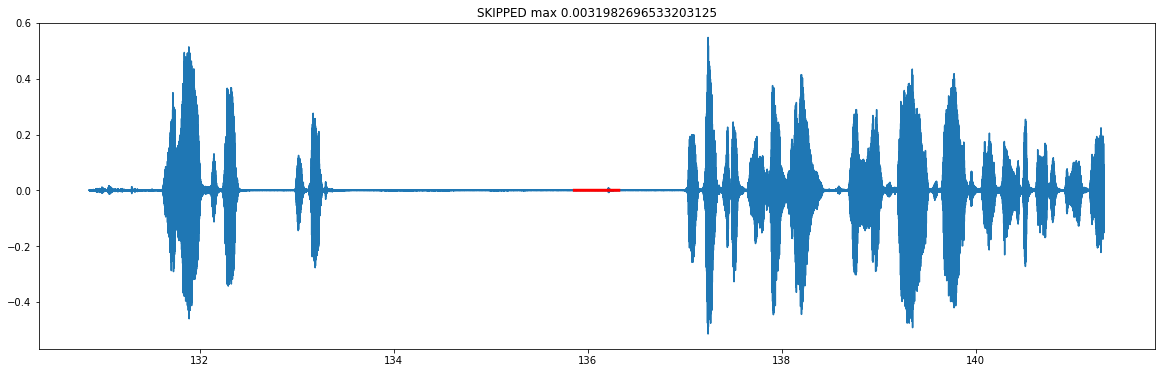

4260 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260]
READ_HEAD 4260
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(13166, 13169)]
cutoff -78.44221105527639 #silences 17: [(763, 766), (2300, 2302), (2883, 2885), (3328, 3332), (5778, 5781), (6391, 6393), (8175, 8177), (10208, 10210), (13163, 13173), (13177, 13179)]
cutoff -78.13065326633166 #silences 71: [(762, 769), (773, 775), (970, 973), (1067, 1069), (2297, 2306), (2311, 2314), (2439, 2442), (2883, 2886), (2894, 2896), (3161, 3164)]
cutoff -77.81909547738694 #silences 202: [(196, 198), (211, 215), (310, 316), (339, 341), (349, 357), (540, 543), (547, 550), (553, 556), (559, 561), (568, 570)]
stop to read 4260 4456


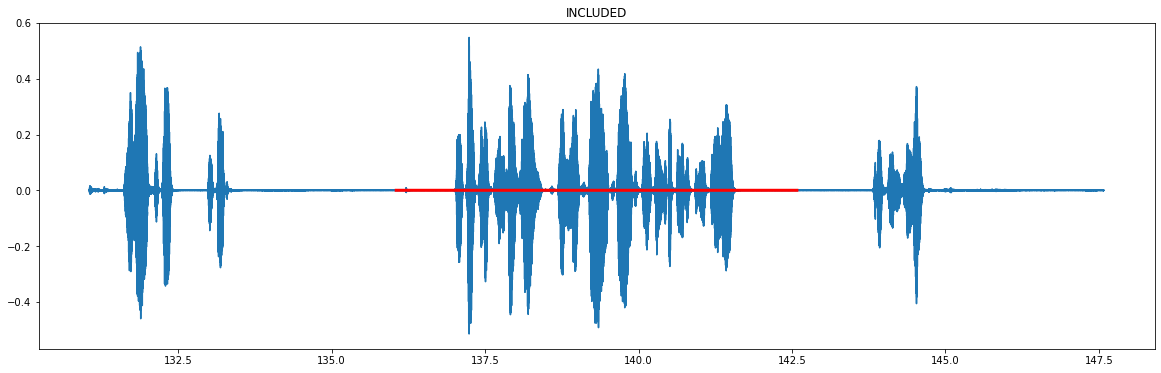

[NeMo I 2020-10-30 00:00:38 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:38 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |tai sao chị đăng kế vạiy gả kỳ vậy cái bà cái bà nói chuyện xong rồi tới chị nói chuyện gọi a|


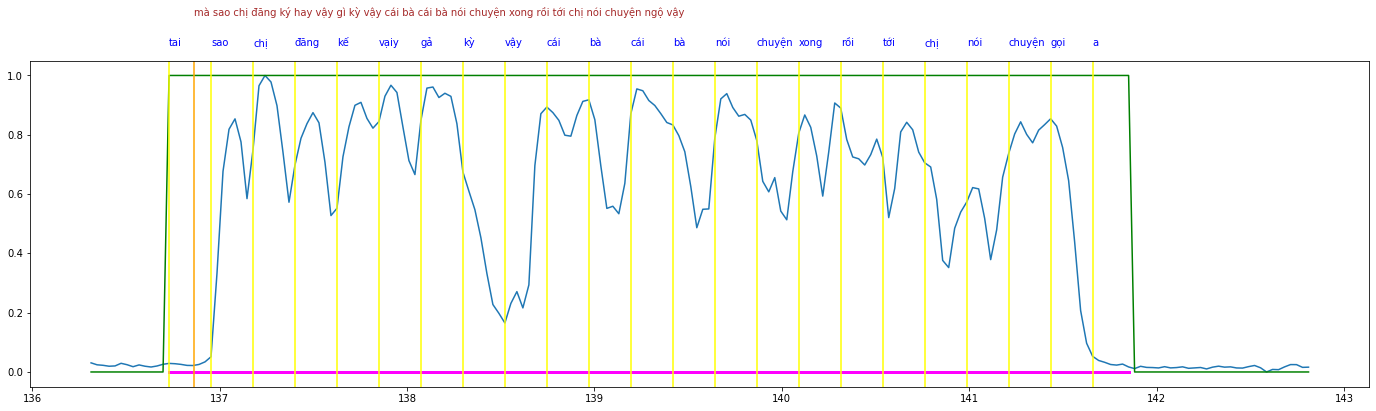

4456 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456]
READ_HEAD 4456
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(12970, 12973)]
cutoff -78.44221105527639 #silences 17: [(567, 570), (2104, 2106), (2687, 2689), (3132, 3136), (5582, 5585), (6195, 6197), (7979, 7981), (10012, 10014), (12967, 12977), (12981, 12983)]
stop to read 4456 5023


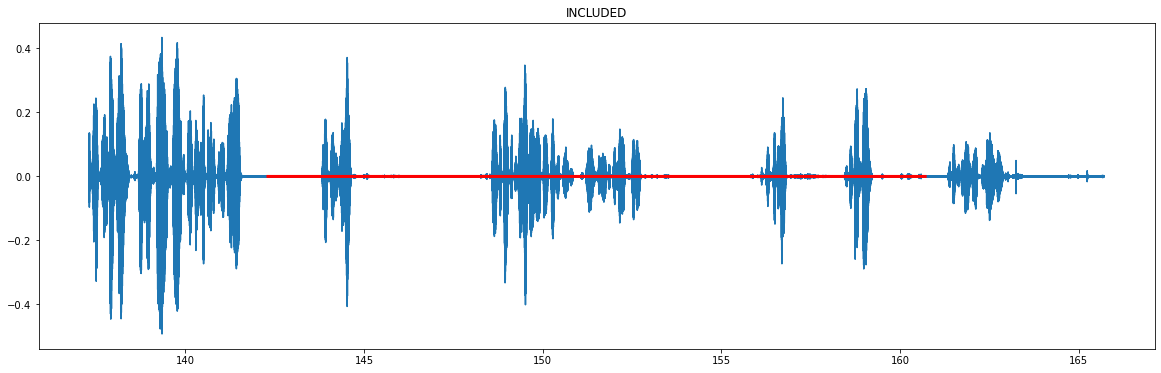

[NeMo I 2020-10-30 00:00:39 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:39 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |tằn đang kýt cái gì vậy nem là sau có số lạ rọi em cái xong nói chuyện ái xon nói huện cá người nói chuyện xong ới chỉ nó gì kỳ vậy kiếm gì ba bi sim Môbile phải không|


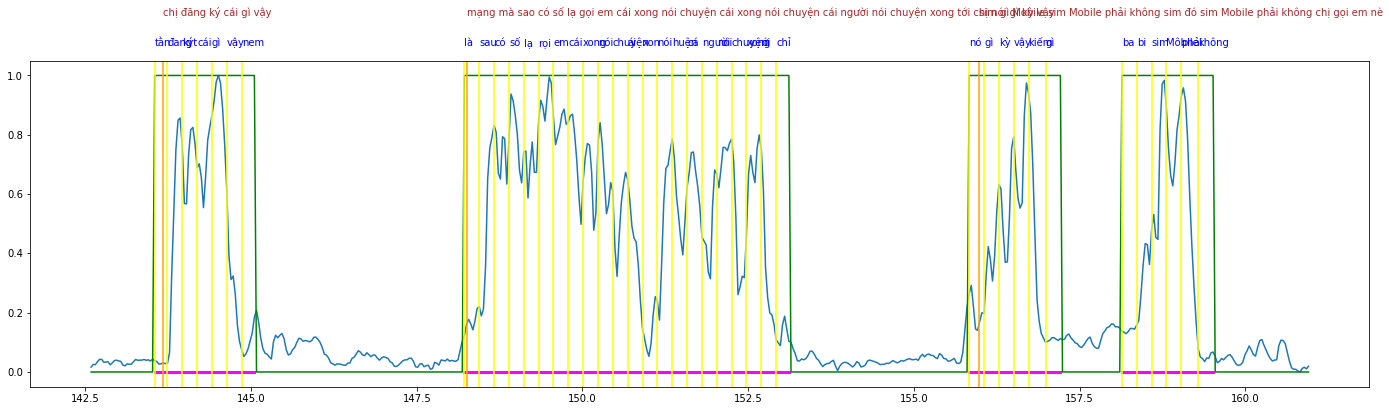

5023 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023]
READ_HEAD 5023
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(12403, 12406)]
cutoff -78.44221105527639 #silences 17: [(0, 3), (1537, 1539), (2120, 2122), (2565, 2569), (5015, 5018), (5628, 5630), (7412, 7414), (9445, 9447), (12400, 12410), (12414, 12416)]
advance past silence 5026 3
cutoff -78.13065326633166 #silences 71: [(0, 3), (7, 9), (204, 207), (301, 303), (1531, 1540), (1545, 1548), (1673, 1676), (2117, 2120), (2128, 2130), (2395, 2398)]
advance past silence 5029 3
cutoff -77.81909547738694 #silences 191: [(0, 7), (200, 211), (236, 238), (256, 259), (297, 304), (318, 320), (326, 329), (995, 1000), (1033, 1039), (1067, 10

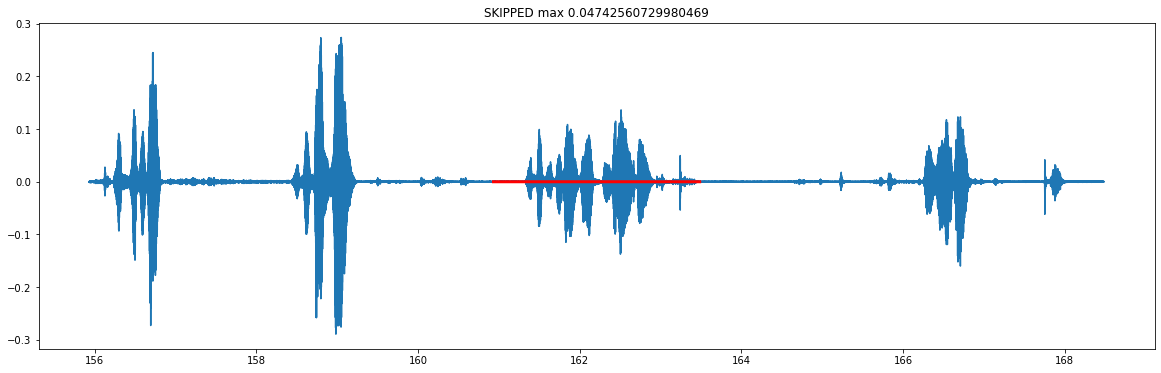

5109 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109]
READ_HEAD 5109
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(12317, 12320)]
cutoff -78.44221105527639 #silences 16: [(1451, 1453), (2034, 2036), (2479, 2483), (4929, 4932), (5542, 5544), (7326, 7328), (9359, 9361), (12314, 12324), (12328, 12330), (12644, 12646)]
cutoff -78.13065326633166 #silences 69: [(121, 124), (218, 220), (1448, 1457), (1462, 1465), (1590, 1593), (2034, 2037), (2045, 2047), (2312, 2315), (2475, 2484), (2716, 2719)]
stop to read 5109 5230


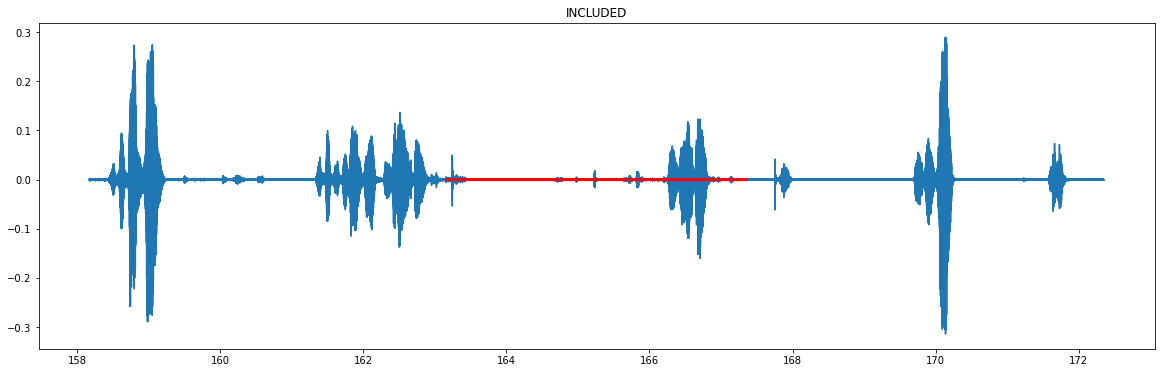

[NeMo I 2020-10-30 00:00:40 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:40 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |răn ói nè|


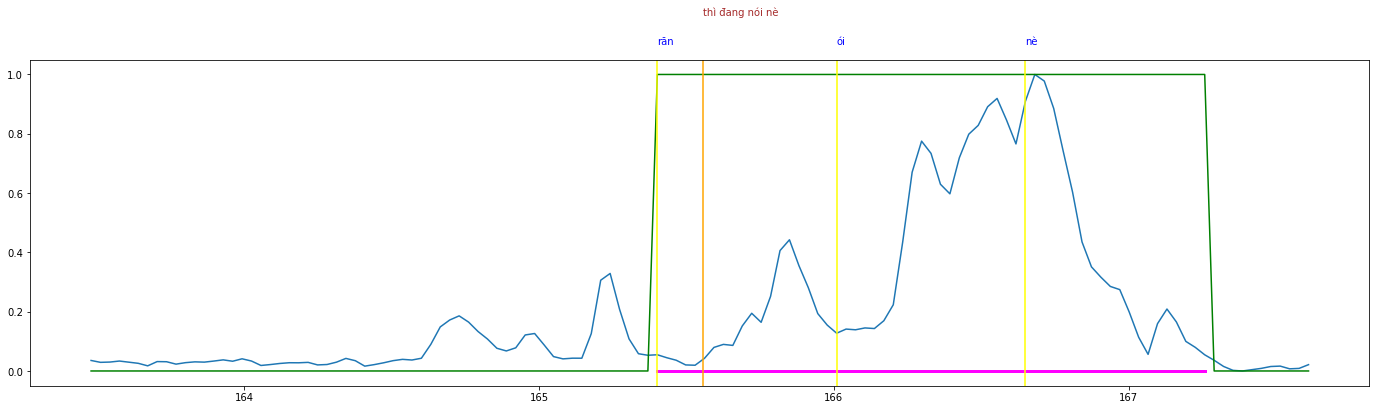

5230 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230]
READ_HEAD 5230
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(12196, 12199)]
cutoff -78.44221105527639 #silences 16: [(1330, 1332), (1913, 1915), (2358, 2362), (4808, 4811), (5421, 5423), (7205, 7207), (9238, 9240), (12193, 12203), (12207, 12209), (12523, 12525)]
cutoff -78.13065326633166 #silences 69: [(0, 3), (97, 99), (1327, 1336), (1341, 1344), (1469, 1472), (1913, 1916), (1924, 1926), (2191, 2194), (2354, 2363), (2595, 2598)]
advance past silence 5233 3
cutoff -77.81909547738694 #silences 190: [(0, 7), (32, 34), (52, 55), (93, 100), (114, 116), (122, 125), (791, 796), (829, 835), (863, 865), (879, 881)]
advance

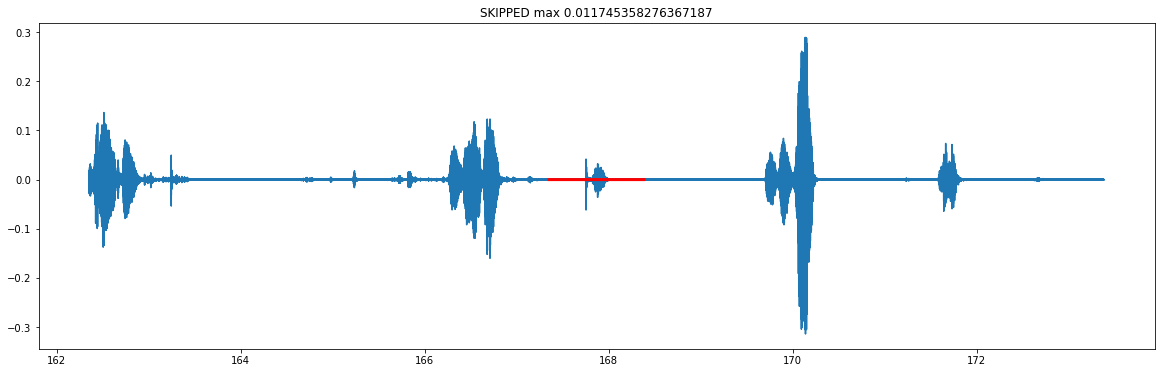

5262 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262]
READ_HEAD 5262
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(12164, 12167)]
cutoff -78.44221105527639 #silences 16: [(1298, 1300), (1881, 1883), (2326, 2330), (4776, 4779), (5389, 5391), (7173, 7175), (9206, 9208), (12161, 12171), (12175, 12177), (12491, 12493)]
cutoff -78.13065326633166 #silences 68: [(65, 67), (1295, 1304), (1309, 1312), (1437, 1440), (1881, 1884), (1892, 1894), (2159, 2162), (2322, 2331), (2563, 2566), (2666, 2669)]
stop to read 5262 5327


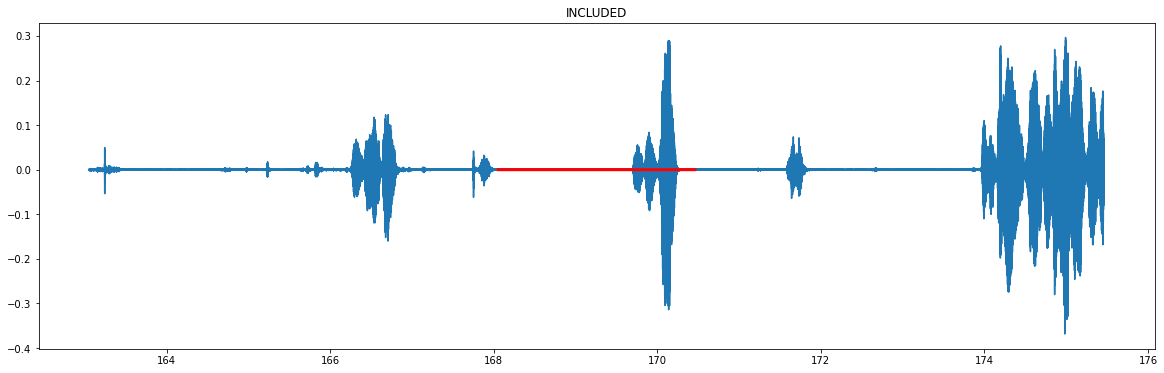

[NeMo I 2020-10-30 00:00:40 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:40 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |nớ g gy|


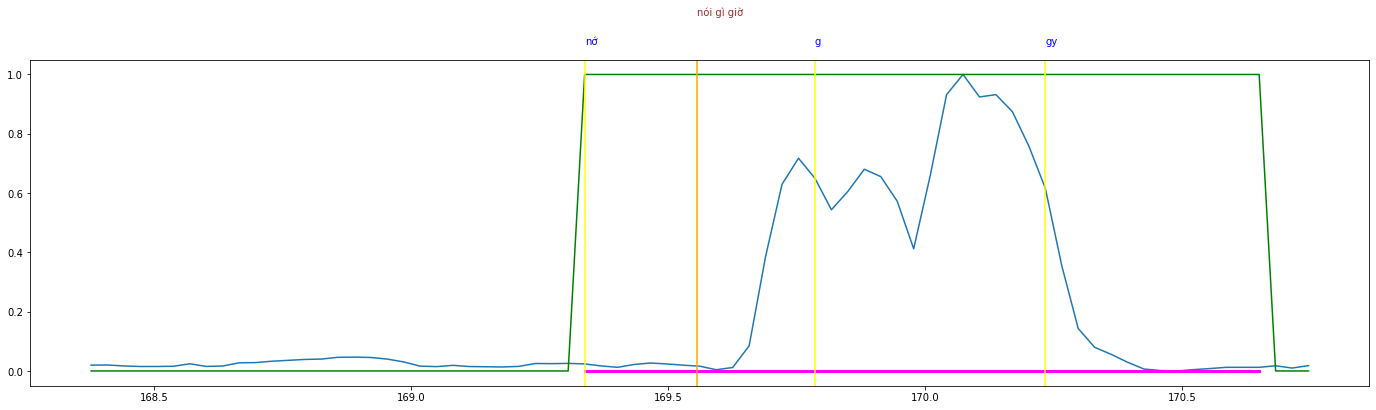

5327 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327]
READ_HEAD 5327
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(12099, 12102)]
cutoff -78.44221105527639 #silences 16: [(1233, 1235), (1816, 1818), (2261, 2265), (4711, 4714), (5324, 5326), (7108, 7110), (9141, 9143), (12096, 12106), (12110, 12112), (12426, 12428)]
cutoff -78.13065326633166 #silences 68: [(0, 2), (1230, 1239), (1244, 1247), (1372, 1375), (1816, 1819), (1827, 1829), (2094, 2097), (2257, 2266), (2498, 2501), (2601, 2604)]
advance past silence 5329 2
cutoff -77.81909547738694 #silences 187: [(0, 4), (18, 20), (26, 29), (695, 700), (733, 739), (767, 769), (783, 785), (956, 961), (963, 965), (9

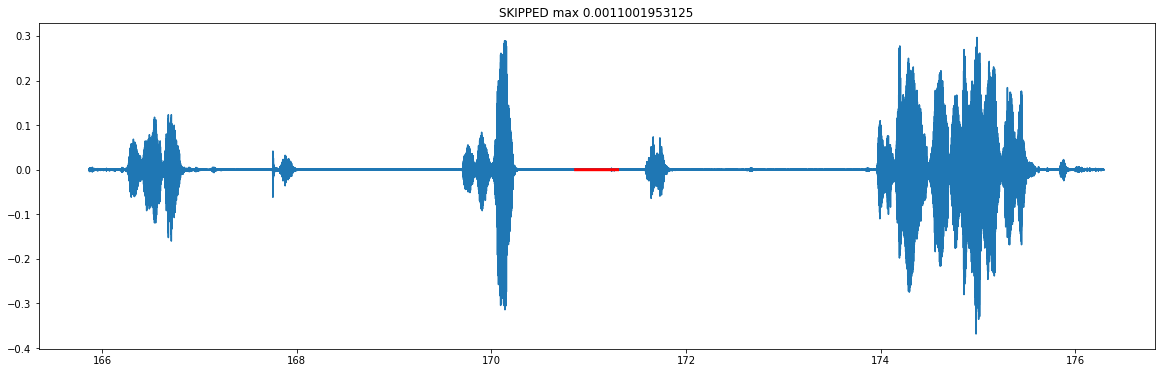

5353 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353]
READ_HEAD 5353
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(12073, 12076)]
cutoff -78.44221105527639 #silences 16: [(1207, 1209), (1790, 1792), (2235, 2239), (4685, 4688), (5298, 5300), (7082, 7084), (9115, 9117), (12070, 12080), (12084, 12086), (12400, 12402)]
cutoff -78.13065326633166 #silences 67: [(1204, 1213), (1218, 1221), (1346, 1349), (1790, 1793), (1801, 1803), (2068, 2071), (2231, 2240), (2472, 2475), (2575, 2578), (2580, 2583)]
cutoff -77.81909547738694 #silences 185: [(2, 5), (671, 676), (709, 715), (743, 745), (759, 761), (932, 937), (939, 941), (944, 948), (1122, 1124), (1173, 1175)

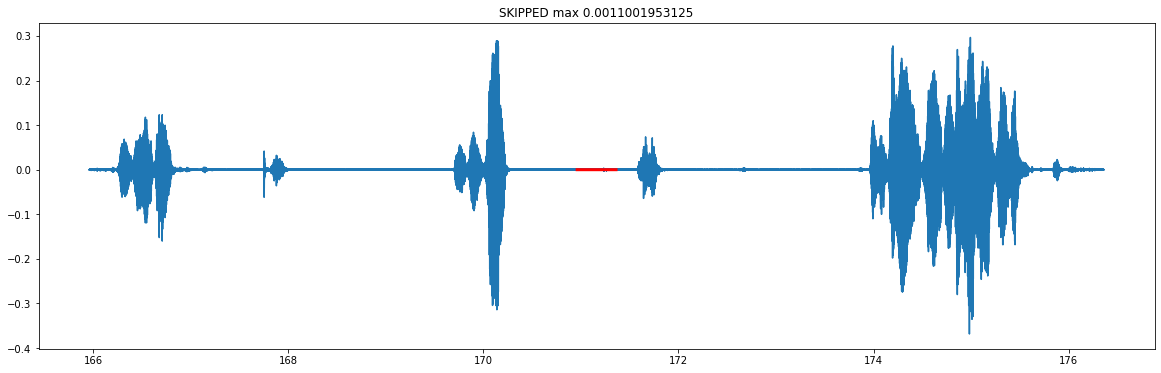

5355 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355]
READ_HEAD 5355
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(12071, 12074)]
cutoff -78.44221105527639 #silences 16: [(1205, 1207), (1788, 1790), (2233, 2237), (4683, 4686), (5296, 5298), (7080, 7082), (9113, 9115), (12068, 12078), (12082, 12084), (12398, 12400)]
cutoff -78.13065326633166 #silences 67: [(1202, 1211), (1216, 1219), (1344, 1347), (1788, 1791), (1799, 1801), (2066, 2069), (2229, 2238), (2470, 2473), (2573, 2576), (2578, 2581)]
cutoff -77.81909547738694 #silences 185: [(0, 3), (669, 674), (707, 713), (741, 743), (757, 759), (930, 935), (937, 939), (942, 946), (1120, 1122), (1171,

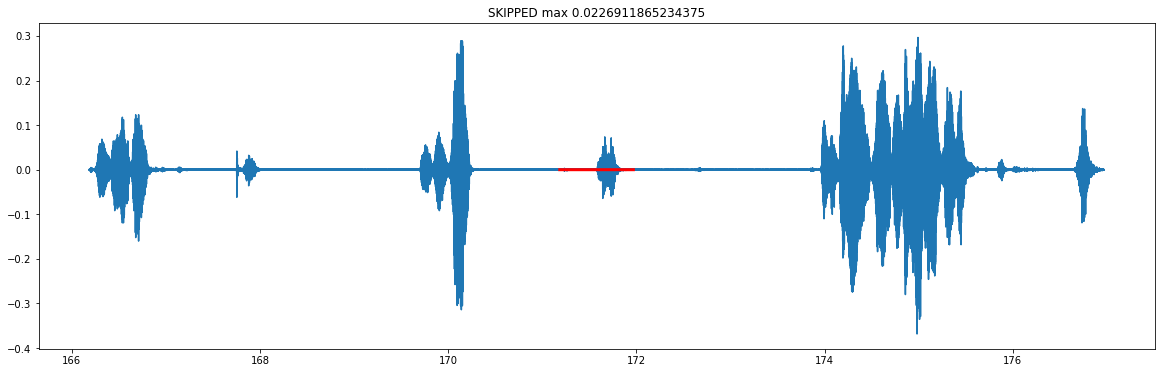

5374 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374]
READ_HEAD 5374
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(12052, 12055)]
cutoff -78.44221105527639 #silences 16: [(1186, 1188), (1769, 1771), (2214, 2218), (4664, 4667), (5277, 5279), (7061, 7063), (9094, 9096), (12049, 12059), (12063, 12065), (12379, 12381)]
cutoff -78.13065326633166 #silences 67: [(1183, 1192), (1197, 1200), (1325, 1328), (1769, 1772), (1780, 1782), (2047, 2050), (2210, 2219), (2451, 2454), (2554, 2557), (2559, 2562)]
cutoff -77.81909547738694 #silences 184: [(650, 655), (688, 694), (722, 724), (738, 740), (911, 916), (918, 920), (923, 927), (1101, 1103), (1152, 1

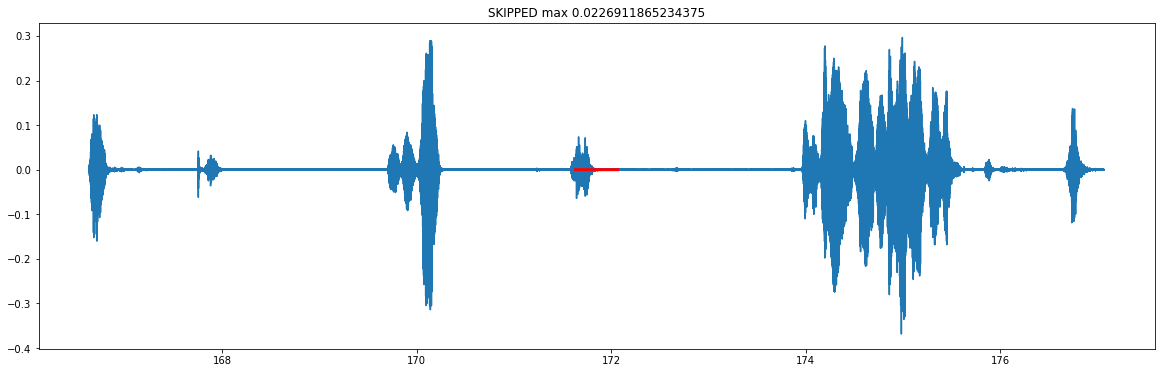

5377 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377]
READ_HEAD 5377
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(12049, 12052)]
cutoff -78.44221105527639 #silences 16: [(1183, 1185), (1766, 1768), (2211, 2215), (4661, 4664), (5274, 5276), (7058, 7060), (9091, 9093), (12046, 12056), (12060, 12062), (12376, 12378)]
cutoff -78.13065326633166 #silences 67: [(1180, 1189), (1194, 1197), (1322, 1325), (1766, 1769), (1777, 1779), (2044, 2047), (2207, 2216), (2448, 2451), (2551, 2554), (2556, 2559)]
cutoff -77.81909547738694 #silences 184: [(647, 652), (685, 691), (719, 721), (735, 737), (908, 913), (915, 917), (920, 924), (1098, 1100), (1

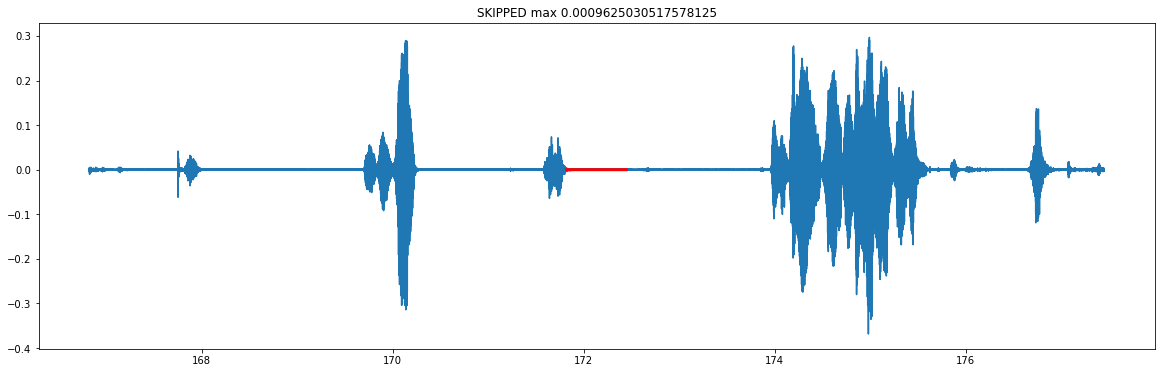

5389 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389]
READ_HEAD 5389
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(12037, 12040)]
cutoff -78.44221105527639 #silences 16: [(1171, 1173), (1754, 1756), (2199, 2203), (4649, 4652), (5262, 5264), (7046, 7048), (9079, 9081), (12034, 12044), (12048, 12050), (12364, 12366)]
cutoff -78.13065326633166 #silences 67: [(1168, 1177), (1182, 1185), (1310, 1313), (1754, 1757), (1765, 1767), (2032, 2035), (2195, 2204), (2436, 2439), (2539, 2542), (2544, 2547)]
cutoff -77.81909547738694 #silences 184: [(635, 640), (673, 679), (707, 709), (723, 725), (896, 901), (903, 905), (908, 912), (1086, 108

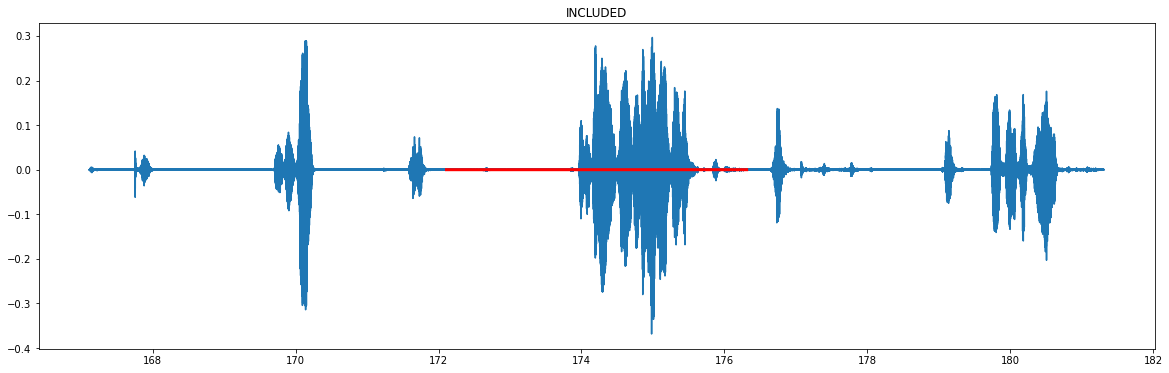

[NeMo I 2020-10-30 00:00:41 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:41 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |co hưa về đại đại đi rồi|


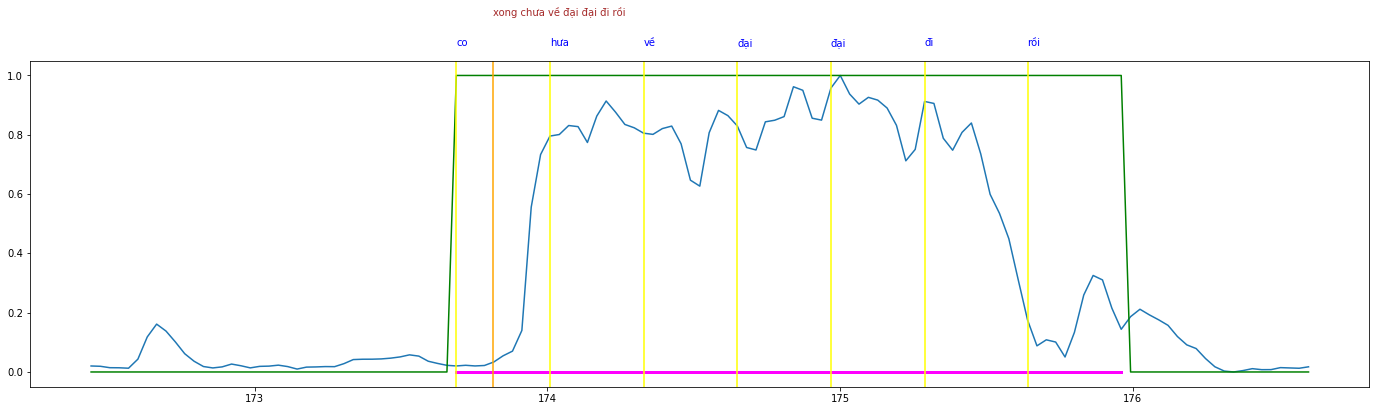

5510 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510]
READ_HEAD 5510
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(11916, 11919)]
cutoff -78.44221105527639 #silences 16: [(1050, 1052), (1633, 1635), (2078, 2082), (4528, 4531), (5141, 5143), (6925, 6927), (8958, 8960), (11913, 11923), (11927, 11929), (12243, 12245)]
cutoff -78.13065326633166 #silences 67: [(1047, 1056), (1061, 1064), (1189, 1192), (1633, 1636), (1644, 1646), (1911, 1914), (2074, 2083), (2315, 2318), (2418, 2421), (2423, 2426)]
cutoff -77.81909547738694 #silences 184: [(514, 519), (552, 558), (586, 588), (602, 604), (775, 780), (782, 784), (787, 791), (965

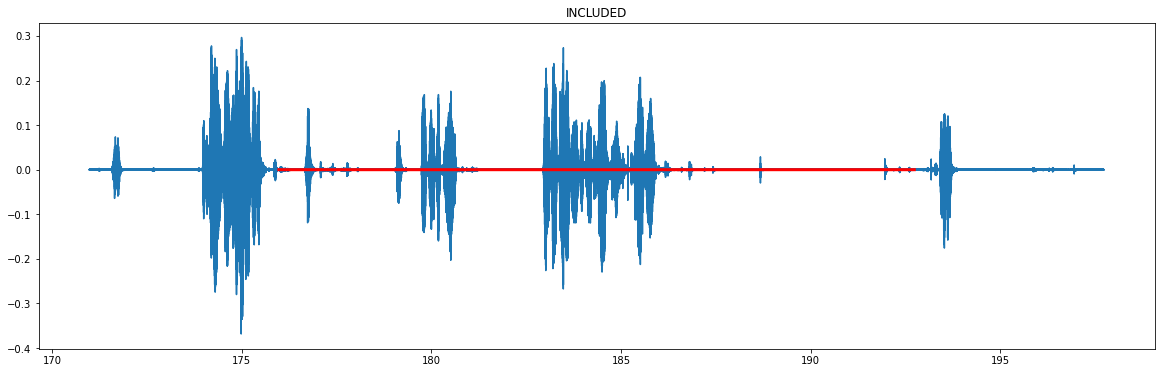

[NeMo I 2020-10-30 00:00:41 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:41 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ờ mười phút ra ông ếm nói là mười phút đỡn mới về mười phút nmuất má dề đai phải không|


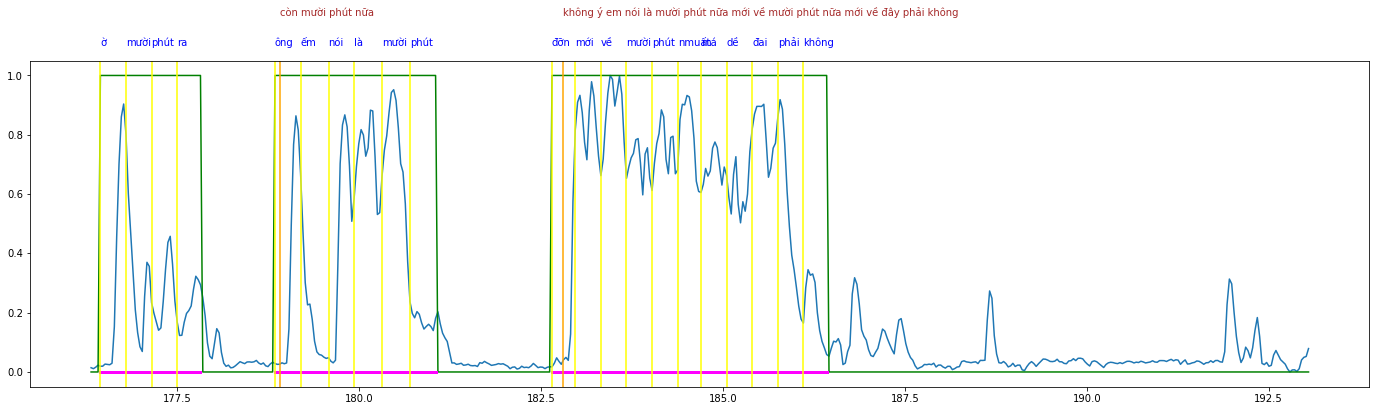

6024 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024]
READ_HEAD 6024
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(11402, 11405)]
cutoff -78.44221105527639 #silences 16: [(536, 538), (1119, 1121), (1564, 1568), (4014, 4017), (4627, 4629), (6411, 6413), (8444, 8446), (11399, 11409), (11413, 11415), (11729, 11731)]
stop to read 6024 6560


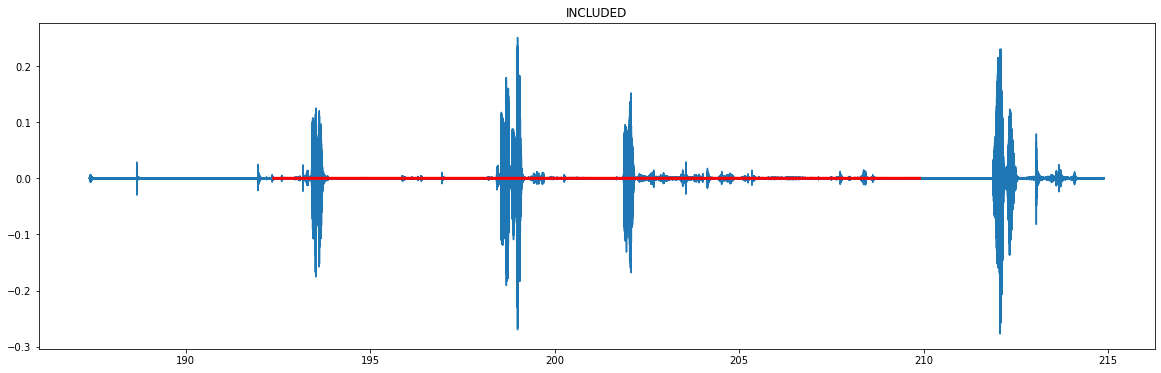

[NeMo I 2020-10-30 00:00:42 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:42 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |tái gỳ gì nói trước i ay biết|
empty translation
6560 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560]
READ_HEAD 6560
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(10866, 10869)]
cutoff -78.44221105527639 #silences 16: [(0, 2), (583, 585), (1028, 1032), (3478, 3481), (4091, 4093), (5875, 5877), (7908, 7910), (10863, 10873), (10877, 10879), (11193, 11195)]
advance past silence 6562 2
cutoff -78.13065326633166 #silences

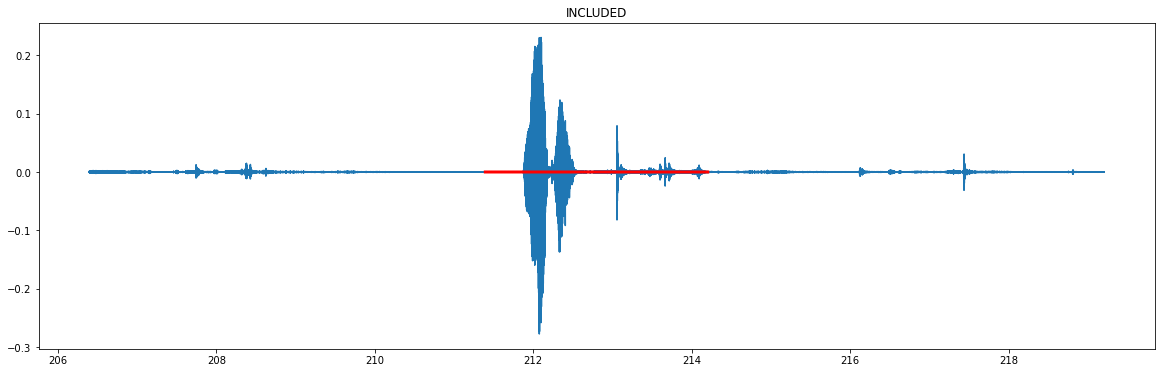

[NeMo I 2020-10-30 00:00:42 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:42 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |có có|


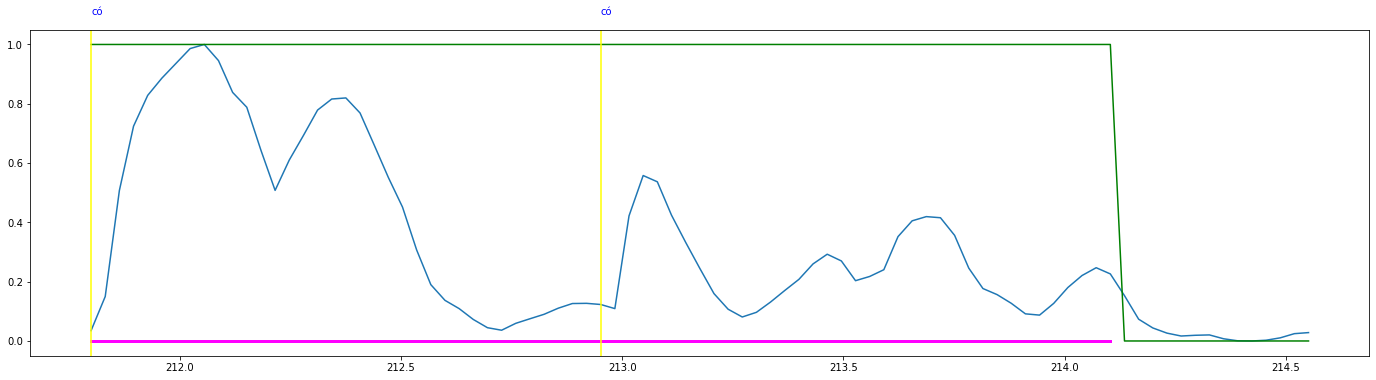

6694 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694]
READ_HEAD 6694
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(10732, 10735)]
cutoff -78.44221105527639 #silences 15: [(449, 451), (894, 898), (3344, 3347), (3957, 3959), (5741, 5743), (7774, 7776), (10729, 10739), (10743, 10745), (11059, 11061), (11125, 11129)]
stop to read 6694 7143


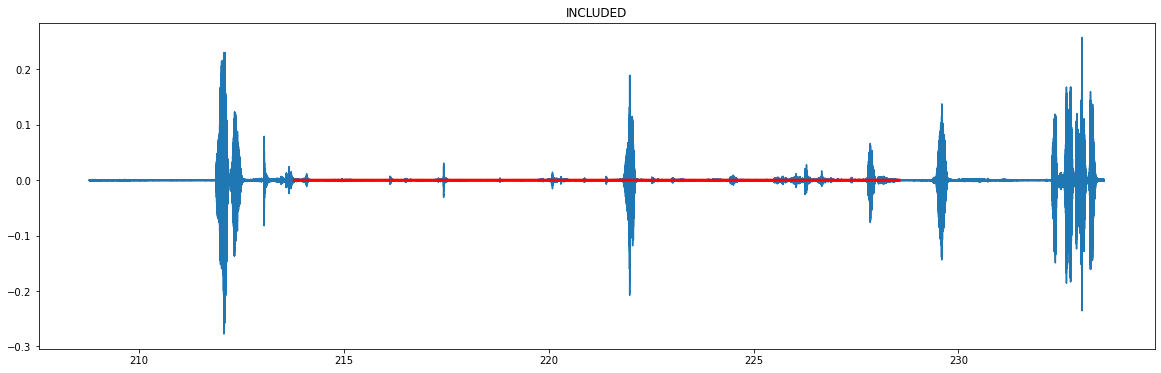

[NeMo I 2020-10-30 00:00:42 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:42 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |hỉ ề í|
empty translation
7143 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143]
READ_HEAD 7143
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(10283, 10286)]
cutoff -78.44221105527639 #silences 15: [(0, 2), (445, 449), (2895, 2898), (3508, 3510), (5292, 5294), (7325, 7327), (10280, 10290), (10294, 10296), (10610, 10612), (10676, 10680)]
advance past silence 7145 2
cutoff -78.13065326633166 #silences 63: [(9,

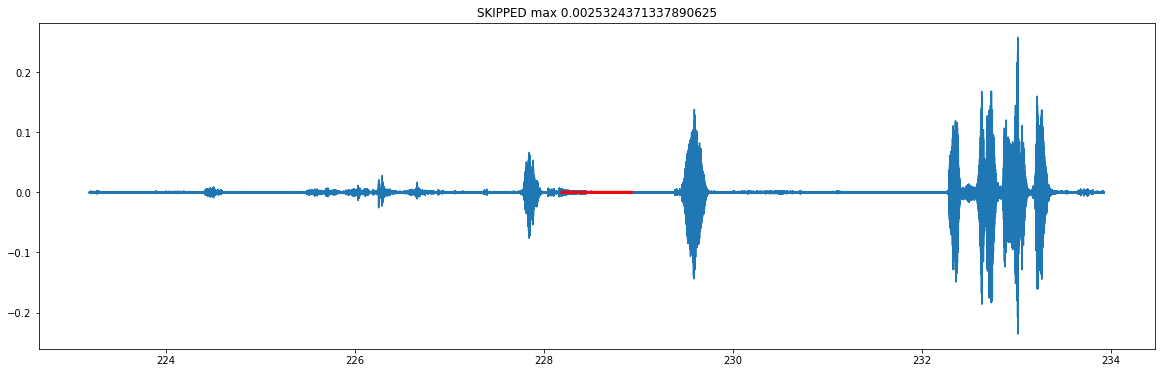

7154 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154]
READ_HEAD 7154
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(10272, 10275)]
cutoff -78.44221105527639 #silences 14: [(434, 438), (2884, 2887), (3497, 3499), (5281, 5283), (7314, 7316), (10269, 10279), (10283, 10285), (10599, 10601), (10665, 10669), (10673, 10676)]
stop to read 7154 7588


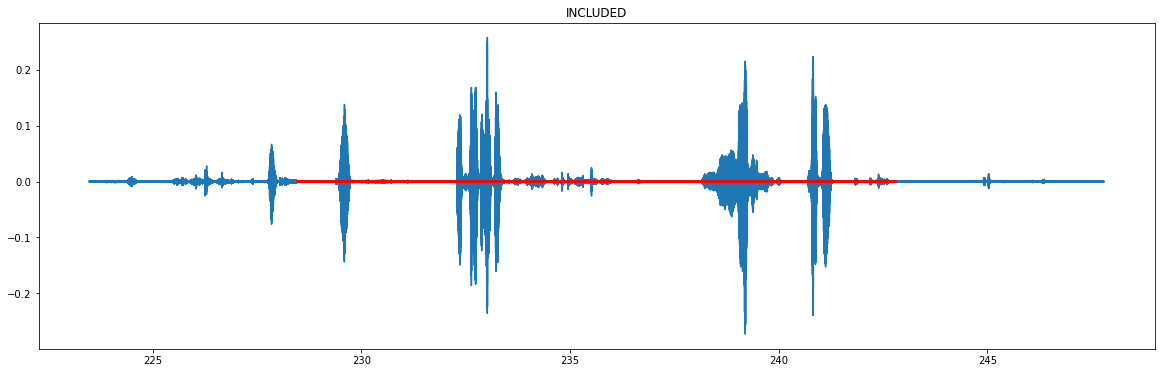

[NeMo I 2020-10-30 00:00:43 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:43 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |n i gì vhữ nói trơ đi i nchủ chị rảnh quá|


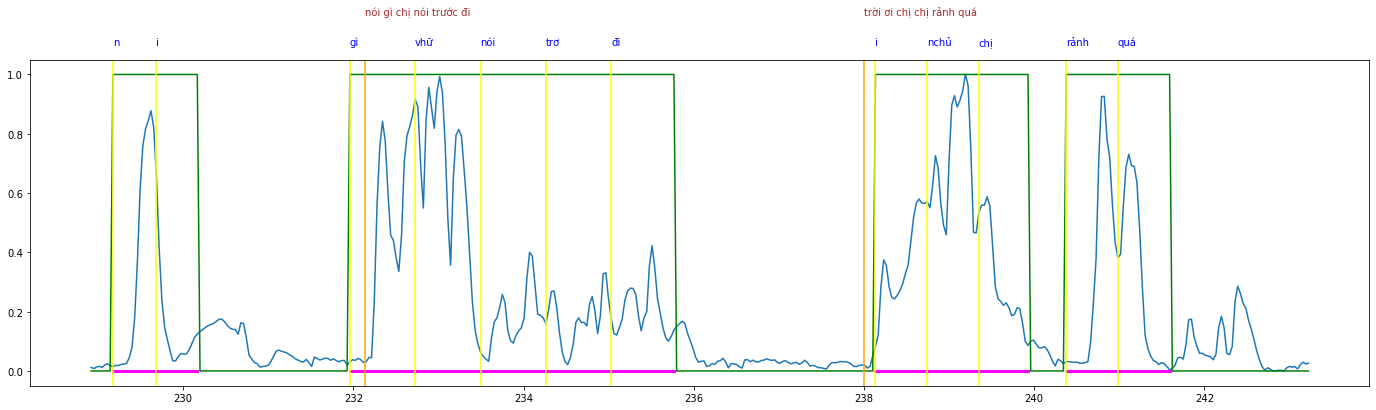

7588 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588]
READ_HEAD 7588
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(9838, 9841)]
cutoff -78.44221105527639 #silences 14: [(0, 4), (2450, 2453), (3063, 3065), (4847, 4849), (6880, 6882), (9835, 9845), (9849, 9851), (10165, 10167), (10231, 10235), (10239, 10242)]
advance past silence 7592 4
cutoff -78.13065326633166 #silences 60: [(233, 236), (336, 339), (341, 344), (650, 653), (850, 852), (1075, 1078), (1089, 1094), (1249, 1251), (1766, 1769), (2043, 2045)]
stop to read 7592 7825


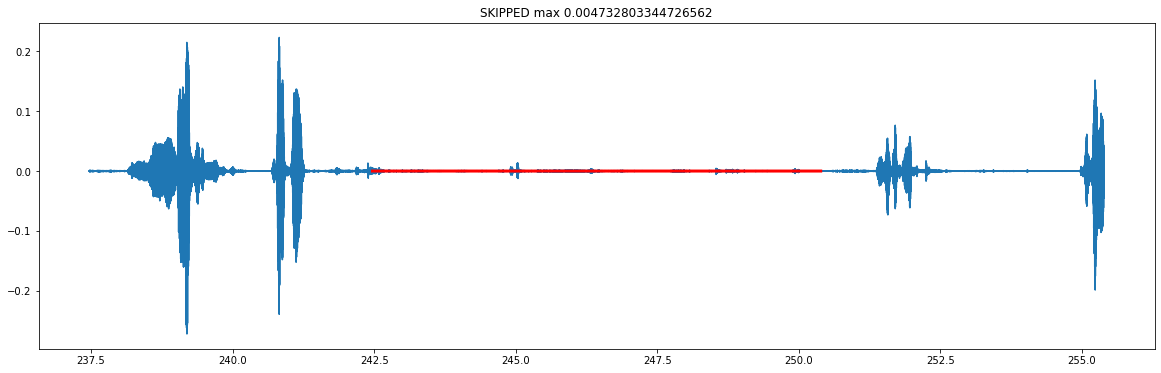

7825 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825]
READ_HEAD 7825
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(9601, 9604)]
cutoff -78.44221105527639 #silences 13: [(2213, 2216), (2826, 2828), (4610, 4612), (6643, 6645), (9598, 9608), (9612, 9614), (9928, 9930), (9994, 9998), (10002, 10005), (10154, 10157)]
cutoff -78.13065326633166 #silences 60: [(0, 3), (103, 106), (108, 111), (417, 420), (617, 619), (842, 845), (856, 861), (1016, 1018), (1533, 1536), (1810, 1812)]
advance past silence 7828 3
cutoff -77.81909547738694 #silences 154: [(0, 2), (23, 25), (100, 108), (122, 125)

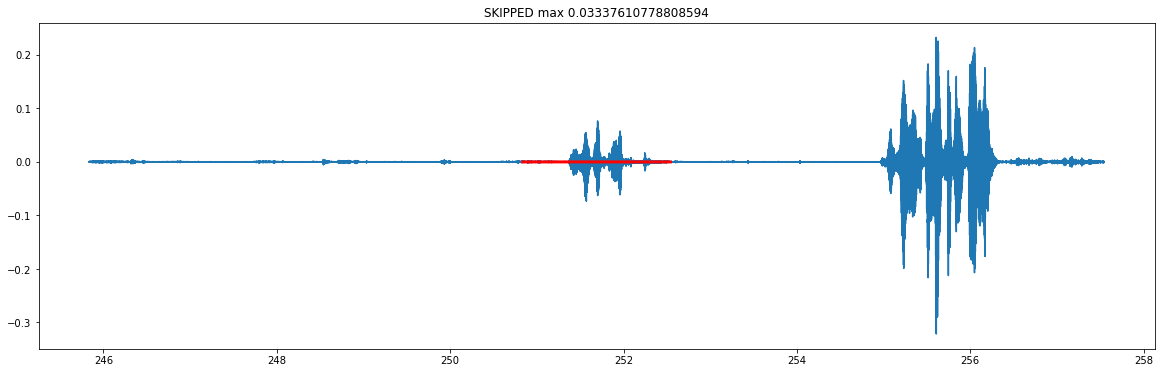

7892 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892]
READ_HEAD 7892
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(9534, 9537)]
cutoff -78.44221105527639 #silences 13: [(2146, 2149), (2759, 2761), (4543, 4545), (6576, 6578), (9531, 9541), (9545, 9547), (9861, 9863), (9927, 9931), (9935, 9938), (10087, 10090)]
cutoff -78.13065326633166 #silences 59: [(36, 39), (41, 44), (350, 353), (550, 552), (775, 778), (789, 794), (949, 951), (1466, 1469), (1743, 1745), (1749, 1754)]
stop to read 7892 7928


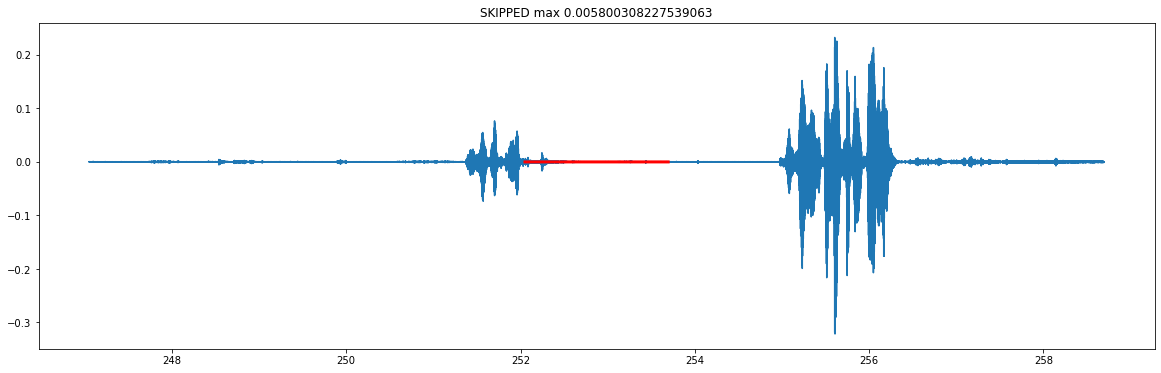

7928 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928]
READ_HEAD 7928
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(9498, 9501)]
cutoff -78.44221105527639 #silences 13: [(2110, 2113), (2723, 2725), (4507, 4509), (6540, 6542), (9495, 9505), (9509, 9511), (9825, 9827), (9891, 9895), (9899, 9902), (10051, 10054)]
cutoff -78.13065326633166 #silences 59: [(0, 3), (5, 8), (314, 317), (514, 516), (739, 742), (753, 758), (913, 915), (1430, 1433), (1707, 1709), (1713, 1718)]
advance past silence 7931 3
cutoff -77.81909547738694 #silences 152: [(0, 5), (19, 22), (31, 34), (230, 

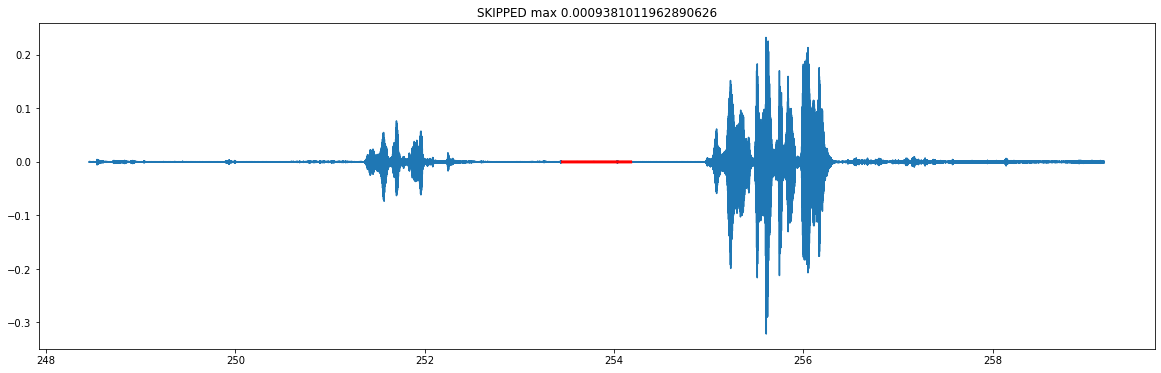

7943 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943]
READ_HEAD 7943
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(9483, 9486)]
cutoff -78.44221105527639 #silences 13: [(2095, 2098), (2708, 2710), (4492, 4494), (6525, 6527), (9480, 9490), (9494, 9496), (9810, 9812), (9876, 9880), (9884, 9887), (10036, 10039)]
cutoff -78.13065326633166 #silences 57: [(299, 302), (499, 501), (724, 727), (738, 743), (898, 900), (1415, 1418), (1692, 1694), (1698, 1703), (1705, 1708), (2095, 2098)]
stop to read 7943 8242


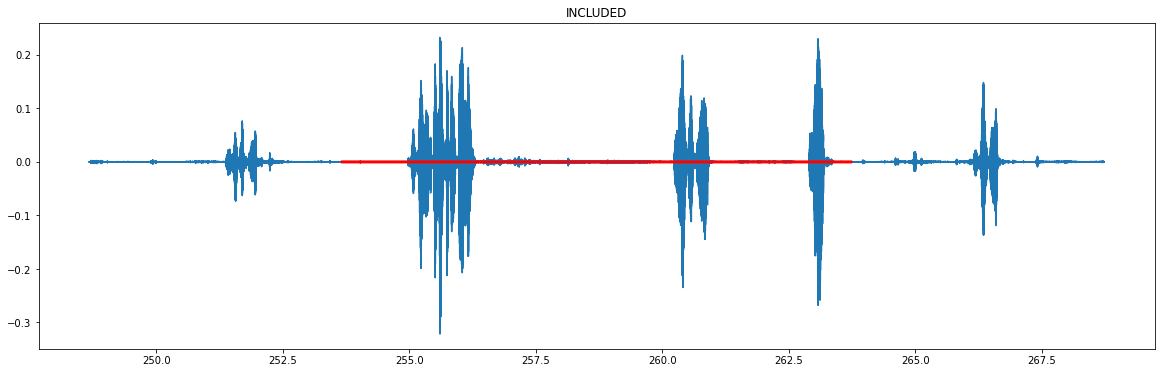

[NeMo I 2020-10-30 00:00:44 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:44 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |bing mị rồi sao biết nói khế ảo hai cì ả cá|


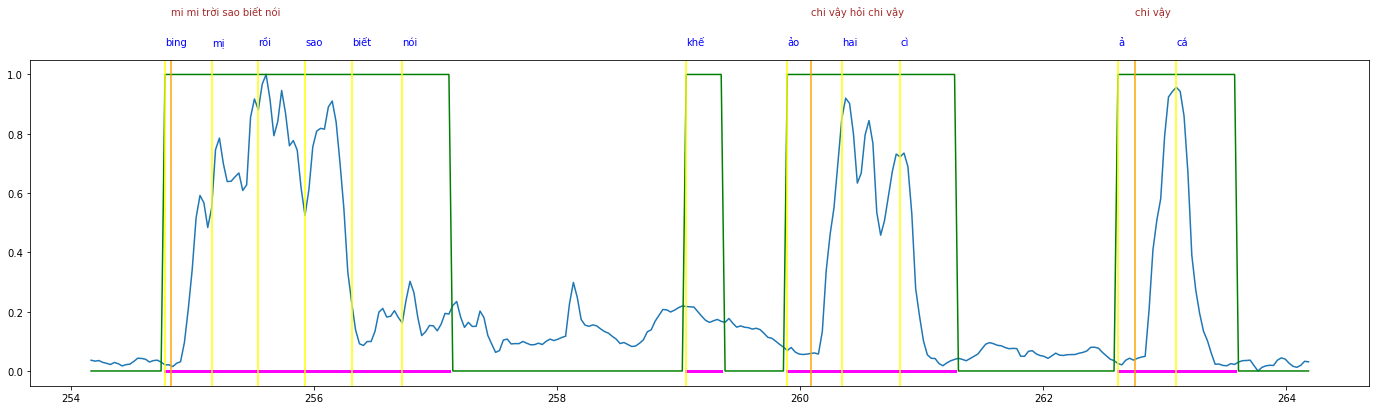

8242 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242]
READ_HEAD 8242
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(9184, 9187)]
cutoff -78.44221105527639 #silences 13: [(1796, 1799), (2409, 2411), (4193, 4195), (6226, 6228), (9181, 9191), (9195, 9197), (9511, 9513), (9577, 9581), (9585, 9588), (9737, 9740)]
cutoff -78.13065326633166 #silences 57: [(0, 3), (200, 202), (425, 428), (439, 444), (599, 601), (1116, 1119), (1393, 1395), (1399, 1404), (1406, 1409), (1796, 1799)]
advance past silence 8245 3
cutoff -77.81909547738694 #silences 147: [(0, 2), (6, 9), 

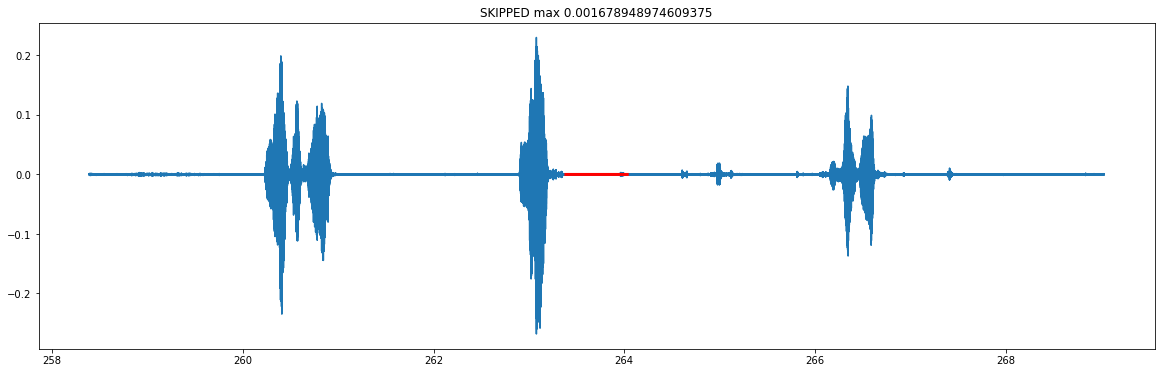

8251 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251]
READ_HEAD 8251
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(9175, 9178)]
cutoff -78.44221105527639 #silences 13: [(1787, 1790), (2400, 2402), (4184, 4186), (6217, 6219), (9172, 9182), (9186, 9188), (9502, 9504), (9568, 9572), (9576, 9579), (9728, 9731)]
cutoff -78.13065326633166 #silences 56: [(191, 193), (416, 419), (430, 435), (590, 592), (1107, 1110), (1384, 1386), (1390, 1395), (1397, 1400), (1787, 1790), (1802, 1808)]
stop to read 8251 8442


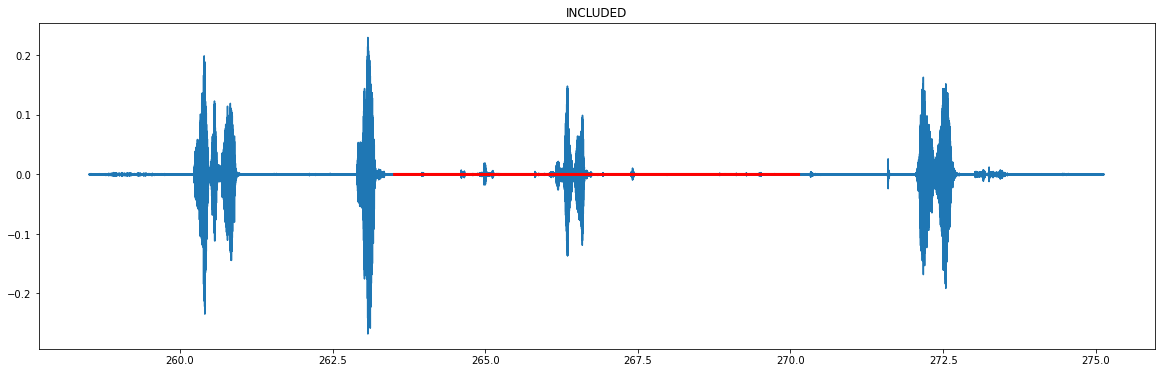

[NeMo I 2020-10-30 00:00:44 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:44 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |cói kô biết nữa|


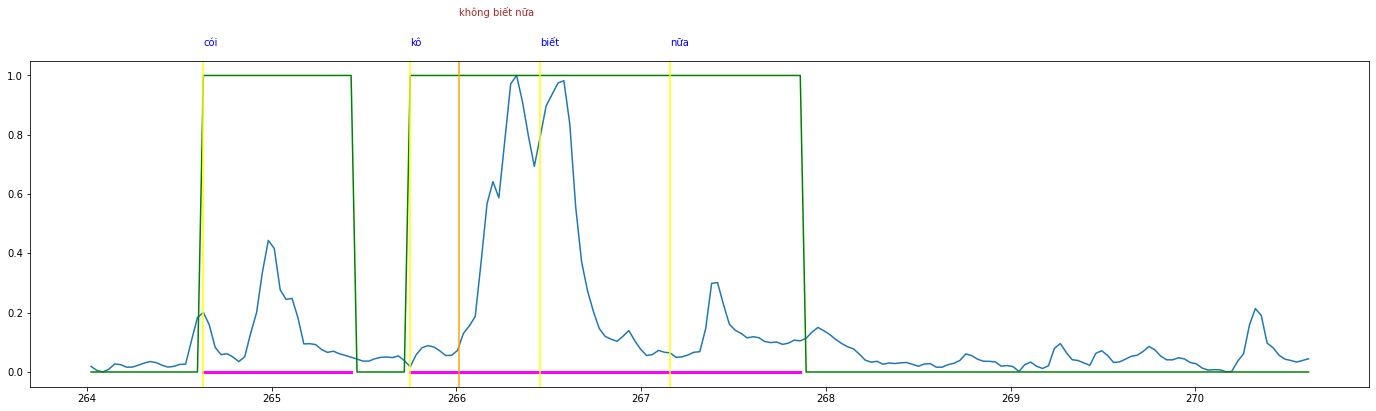

8442 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442]
READ_HEAD 8442
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(8984, 8987)]
cutoff -78.44221105527639 #silences 13: [(1596, 1599), (2209, 2211), (3993, 3995), (6026, 6028), (8981, 8991), (8995, 8997), (9311, 9313), (9377, 9381), (9385, 9388), (9537, 9540)]
cutoff -78.13065326633166 #silences 56: [(0, 2), (225, 228), (239, 244), (399, 401), (916, 919), (1193, 1195), (1199, 1204), (1206, 1209), (1596, 1599), (1611, 1617)]
advance past silence 8444 2
cutoff -77.81909547738694 #silences 144: [(50,

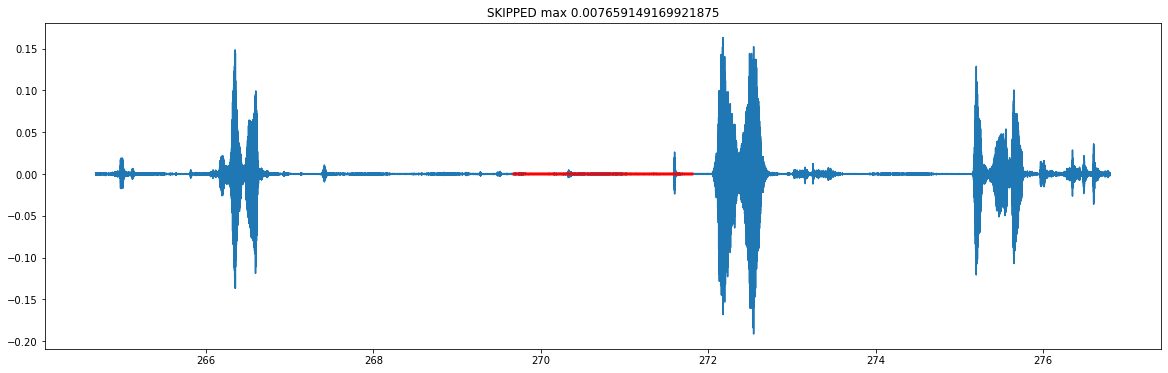

8494 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494]
READ_HEAD 8494
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(8932, 8935)]
cutoff -78.44221105527639 #silences 13: [(1544, 1547), (2157, 2159), (3941, 3943), (5974, 5976), (8929, 8939), (8943, 8945), (9259, 9261), (9325, 9329), (9333, 9336), (9485, 9488)]
cutoff -78.13065326633166 #silences 55: [(173, 176), (187, 192), (347, 349), (864, 867), (1141, 1143), (1147, 1152), (1154, 1157), (1544, 1547), (1559, 1565), (1749, 1754)]
stop to read 8494 8667


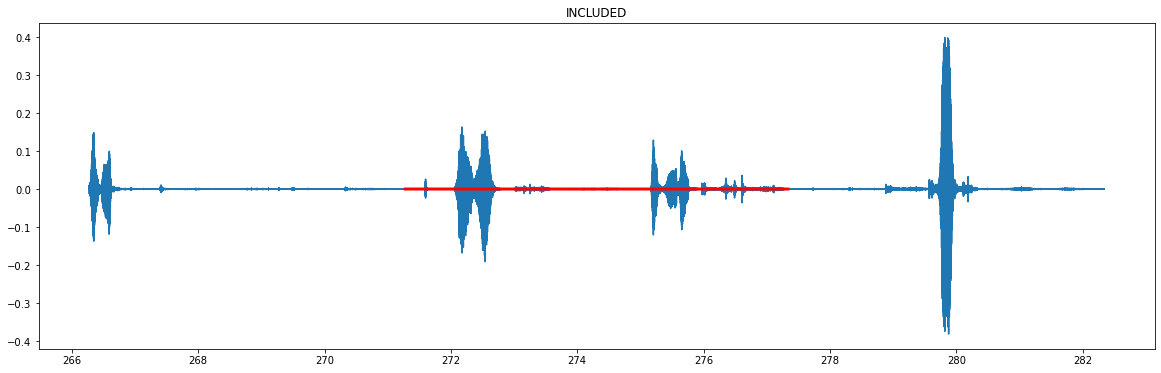

[NeMo I 2020-10-30 00:00:45 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:45 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |tghì quả tăng muo đi|


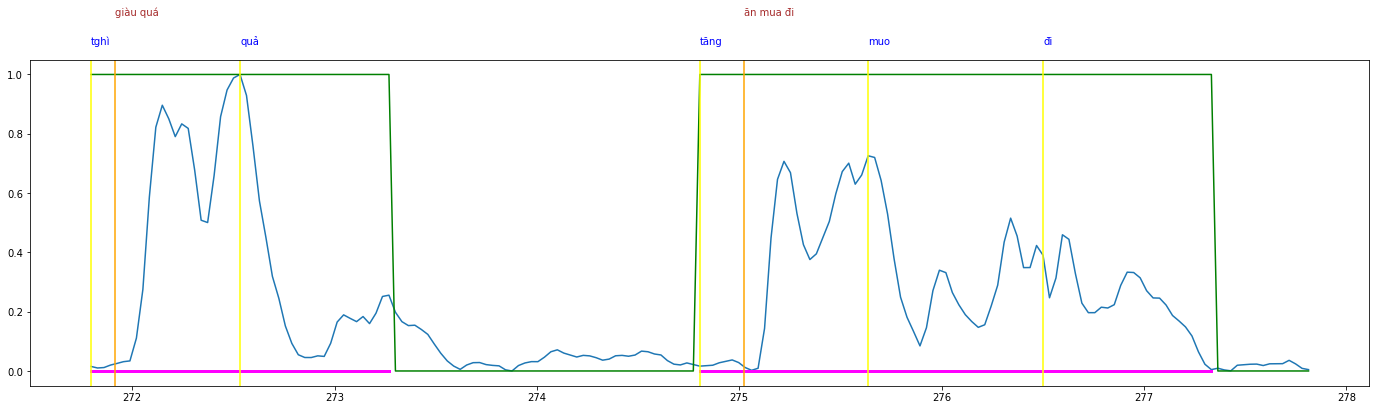

8667 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667]
READ_HEAD 8667
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(8759, 8762)]
cutoff -78.44221105527639 #silences 13: [(1371, 1374), (1984, 1986), (3768, 3770), (5801, 5803), (8756, 8766), (8770, 8772), (9086, 9088), (9152, 9156), (9160, 9163), (9312, 9315)]
cutoff -78.13065326633166 #silences 55: [(0, 3), (14, 19), (174, 176), (691, 694), (968, 970), (974, 979), (981, 984), (1371, 1374), (1386, 1392), (1576, 1581)]
advance past silence 8670 3
cutoff -77.81909547738694 #silences 139:

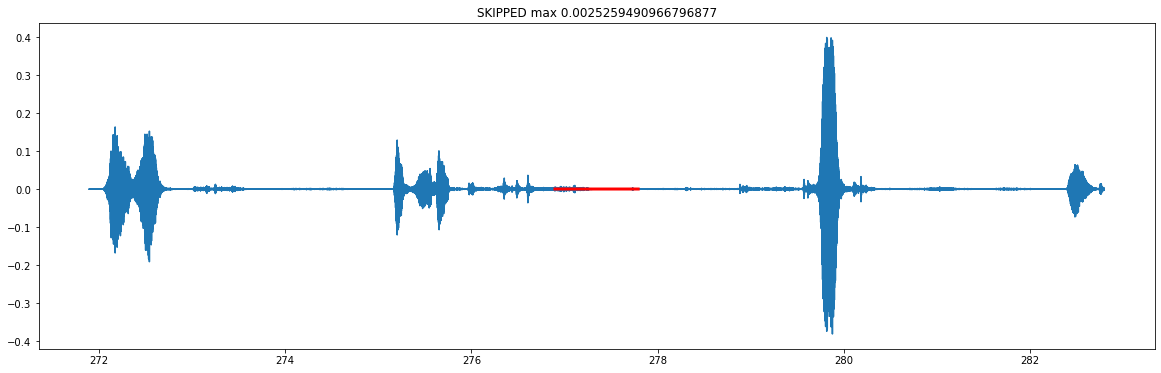

8681 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681]
READ_HEAD 8681
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(8745, 8748)]
cutoff -78.44221105527639 #silences 13: [(1357, 1360), (1970, 1972), (3754, 3756), (5787, 5789), (8742, 8752), (8756, 8758), (9072, 9074), (9138, 9142), (9146, 9149), (9298, 9301)]
cutoff -78.13065326633166 #silences 54: [(0, 5), (160, 162), (677, 680), (954, 956), (960, 965), (967, 970), (1357, 1360), (1372, 1378), (1562, 1567), (1680, 1682)]
advance past silence 8686 5
cutoff -77.81909547738694 #sil

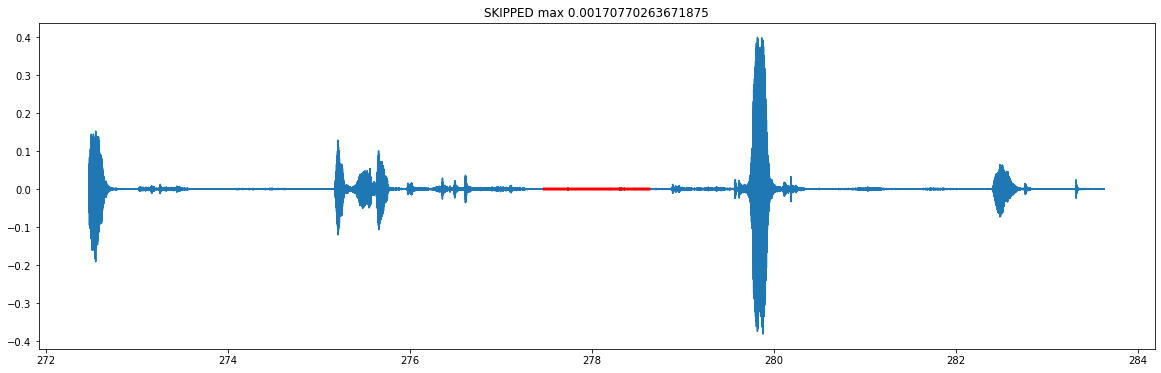

8707 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707]
READ_HEAD 8707
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(8719, 8722)]
cutoff -78.44221105527639 #silences 13: [(1331, 1334), (1944, 1946), (3728, 3730), (5761, 5763), (8716, 8726), (8730, 8732), (9046, 9048), (9112, 9116), (9120, 9123), (9272, 9275)]
cutoff -78.13065326633166 #silences 53: [(134, 136), (651, 654), (928, 930), (934, 939), (941, 944), (1331, 1334), (1346, 1352), (1536, 1541), (1654, 1656), (1890, 1895)]
stop to read 8707 8841


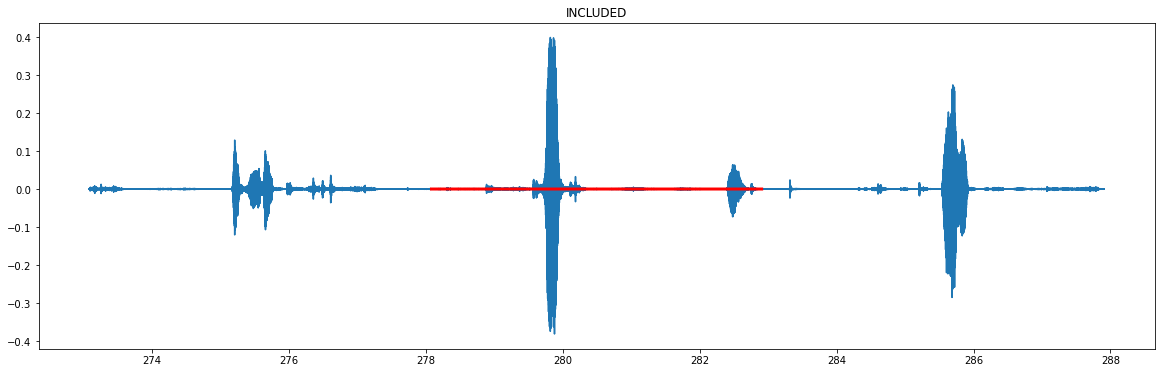

[NeMo I 2020-10-30 00:00:45 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:45 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ờ|
empty translation
8841 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841]
READ_HEAD 8841
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(8585, 8588)]
cutoff -78.44221105527639 #silences 13: [(1197, 1200), (1810, 1812), (3594, 3596), (5627, 5629), (8582, 8592), (8596, 8598), (8912, 8914), (8978, 8982), (8986, 8989), (9138, 91

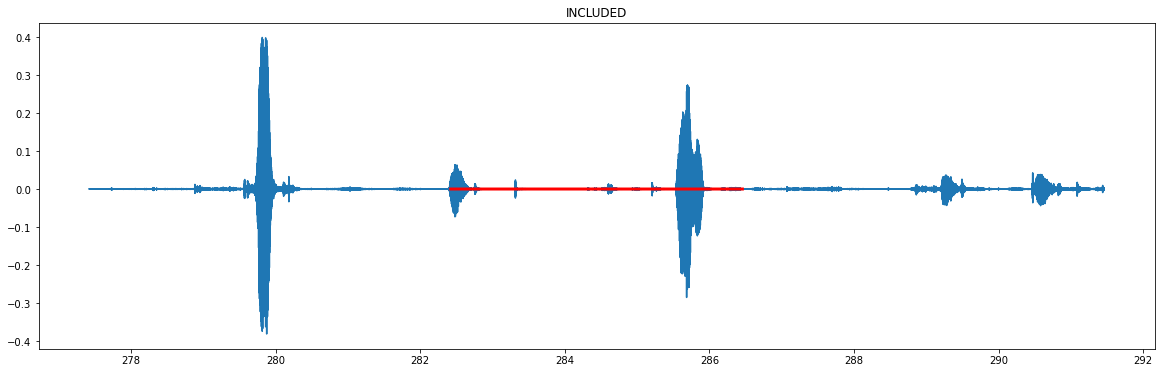

[NeMo I 2020-10-30 00:00:46 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:46 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |vớy|


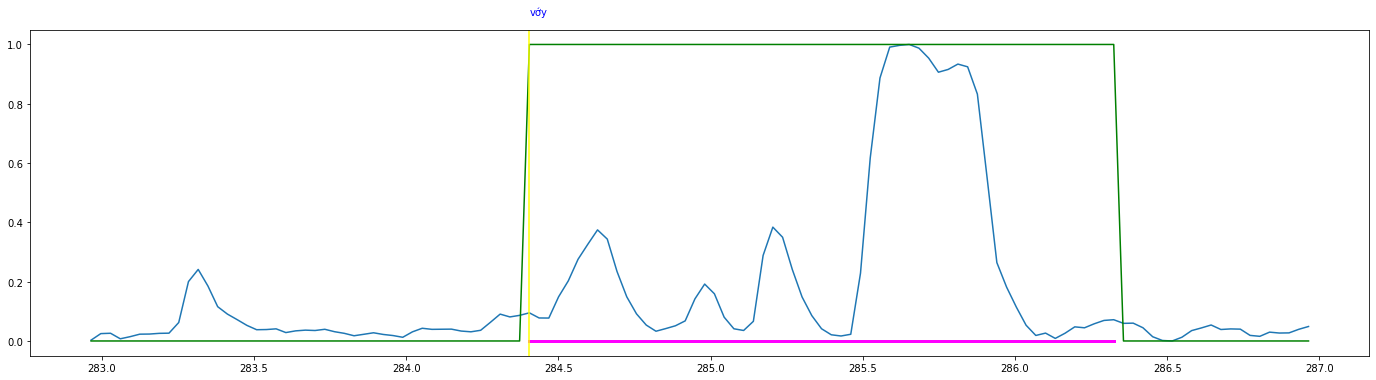

8952 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952]
READ_HEAD 8952
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(8474, 8477)]
cutoff -78.44221105527639 #silences 13: [(1086, 1089), (1699, 1701), (3483, 3485), (5516, 5518), (8471, 8481), (8485, 8487), (8801, 8803), (8867, 8871), (8875, 8878), (9027, 9030)]
cutoff -78.13065326633166 #silences 52: [(406, 409), (683, 685), (689, 694), (696, 699), (1086, 1089), (1101, 1107), (1291, 1296), (1409, 1411), (1645, 1650), (1697, 1704)]
stop to read 8952 9358


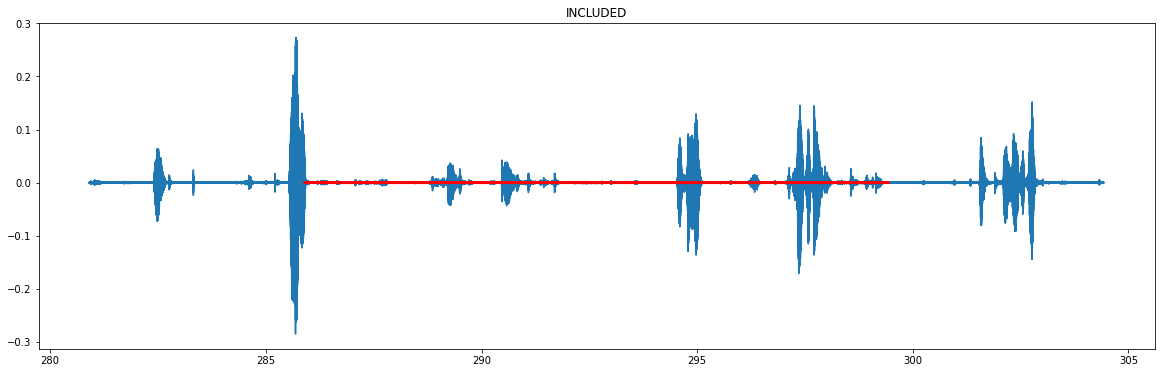

[NeMo I 2020-10-30 00:00:46 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:46 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừ có dư không còn dư phúc không|


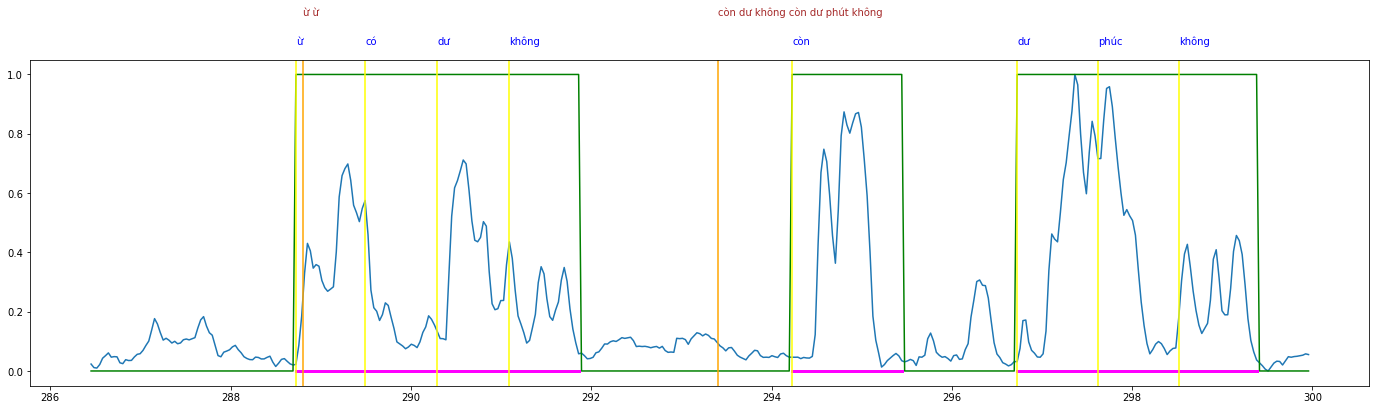

9358 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358]
READ_HEAD 9358
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(8068, 8071)]
cutoff -78.44221105527639 #silences 13: [(680, 683), (1293, 1295), (3077, 3079), (5110, 5112), (8065, 8075), (8079, 8081), (8395, 8397), (8461, 8465), (8469, 8472), (8621, 8624)]
cutoff -78.13065326633166 #silences 52: [(0, 3), (277, 279), (283, 288), (290, 293), (680, 683), (695, 701), (885, 890), (1003, 1005), (1239, 1244), (1291, 1298)]
advance past silence 9361 3
cutoff -77

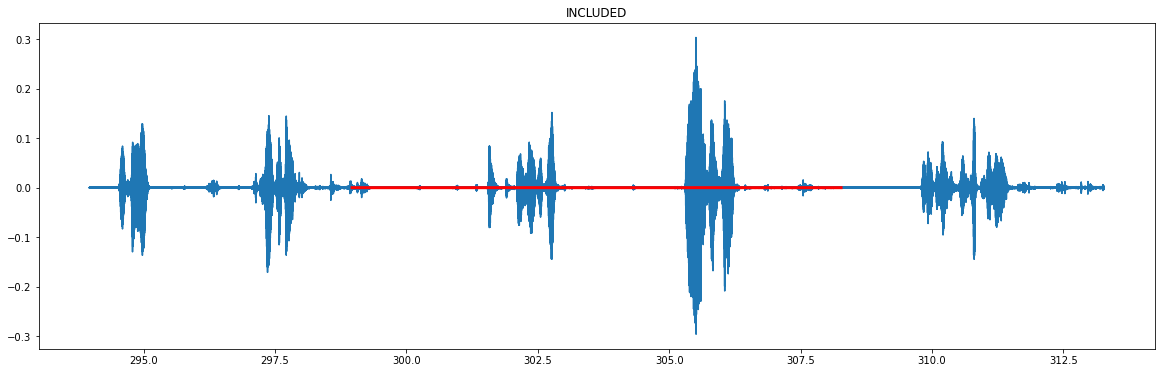

[NeMo I 2020-10-30 00:00:46 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:46 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ngườy hỗ phốt nô hả lâu cá vậy|


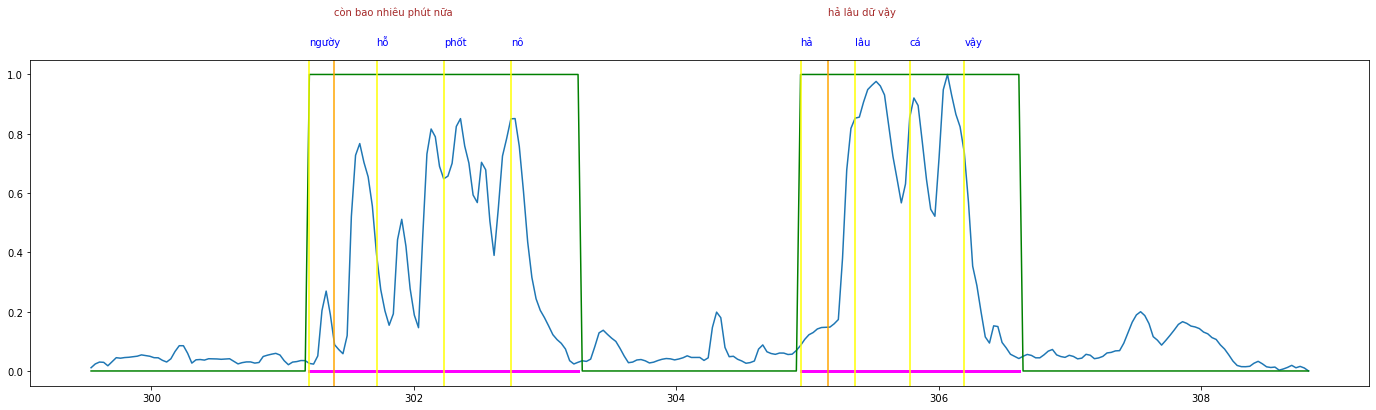

9634 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634]
READ_HEAD 9634
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(7792, 7795)]
cutoff -78.44221105527639 #silences 13: [(404, 407), (1017, 1019), (2801, 2803), (4834, 4836), (7789, 7799), (7803, 7805), (8119, 8121), (8185, 8189), (8193, 8196), (8345, 8348)]
stop to read 9634 10038


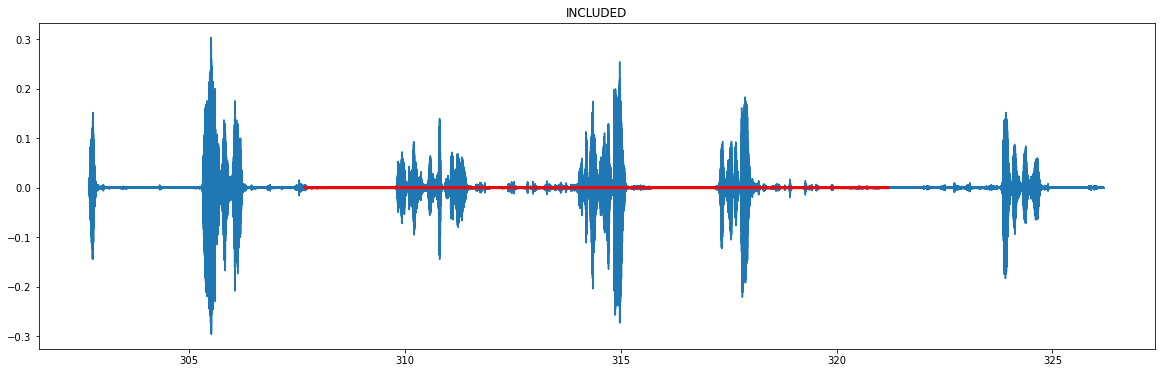

[NeMo I 2020-10-30 00:00:47 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:47 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |thì nó trướa hứ hết hết chuyện nói rồi ủa sao chị hông gọi cho con Đào chị hắn gọi cho co Đào|


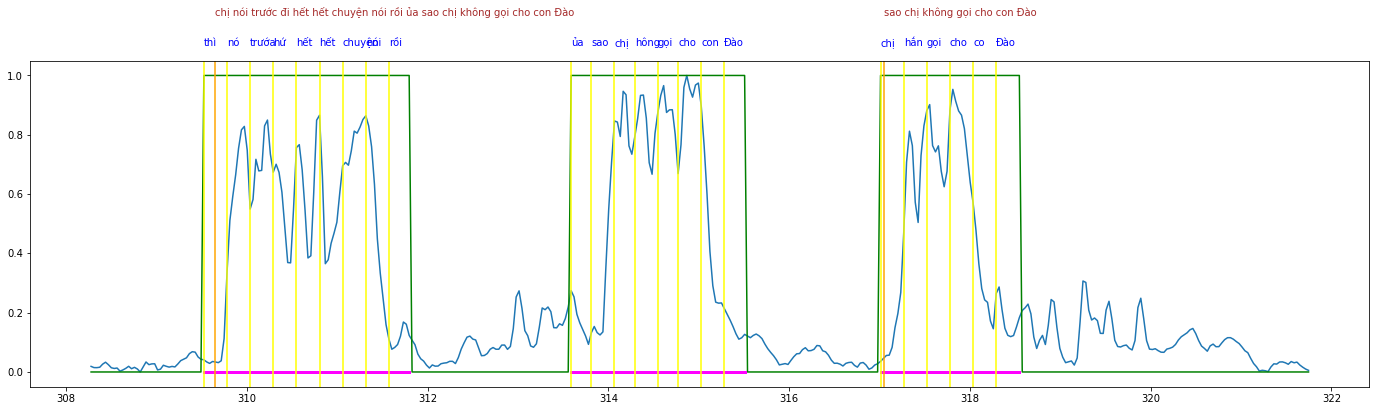

10038 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038]
READ_HEAD 10038
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(7388, 7391)]
cutoff -78.44221105527639 #silences 13: [(0, 3), (613, 615), (2397, 2399), (4430, 4432), (7385, 7395), (7399, 7401), (7715, 7717), (7781, 7785), (7789, 7792), (7941, 7944)]
advance past silence 10041 3
cutoff -78.13065326633166 #silences 47: [(12, 18), (202, 207), (320, 322), (556, 561), (608, 615), (974, 976), (1574, 1578), (1748, 1750), (2355, 2357), (2392, 239

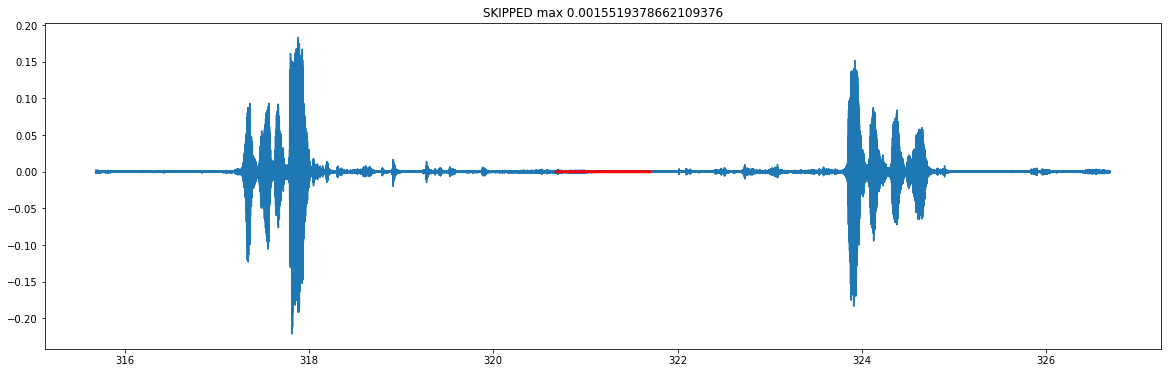

10053 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053]
READ_HEAD 10053
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(7373, 7376)]
cutoff -78.44221105527639 #silences 12: [(598, 600), (2382, 2384), (4415, 4417), (7370, 7380), (7384, 7386), (7700, 7702), (7766, 7770), (7774, 7777), (7926, 7929), (7951, 7954)]
stop to read 10053 10651


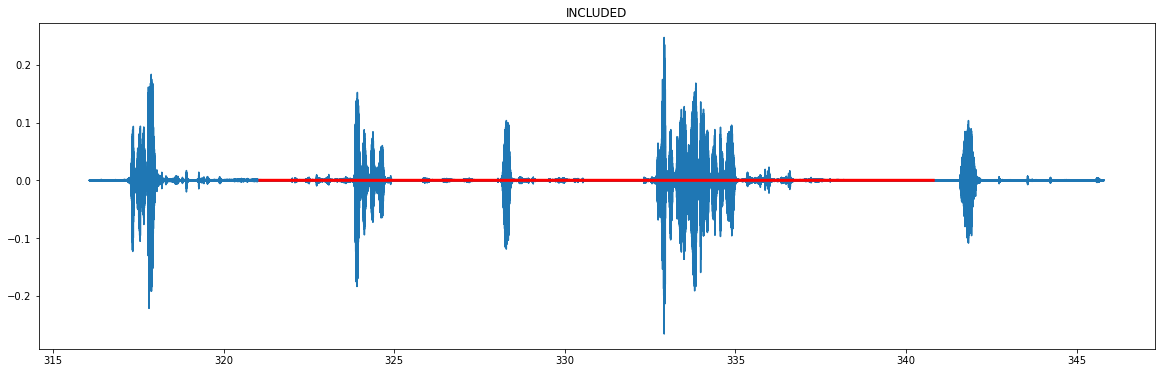

[NeMo I 2020-10-30 00:00:47 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:47 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |rồi Đào giữ thìng cu ở ngoài ă ờ vem vừa se ủa vừa nói chuyện vừa se|


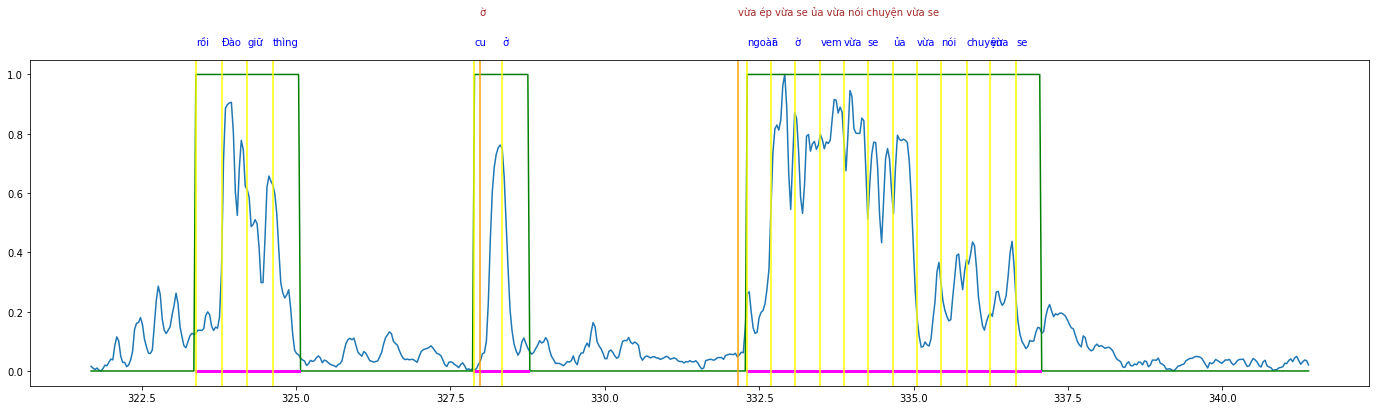

10651 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651]
READ_HEAD 10651
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(6775, 6778)]
cutoff -78.44221105527639 #silences 12: [(0, 2), (1784, 1786), (3817, 3819), (6772, 6782), (6786, 6788), (7102, 7104), (7168, 7172), (7176, 7179), (7328, 7331), (7353, 7356)]
advance past silence 10653 2
cutoff -78.13065326633166 #silences 43: [(0, 3), (362, 364), (962, 966), (1136, 1138), (1743, 1745), (1780, 1784), (2120, 2122), (2125, 2130), (240

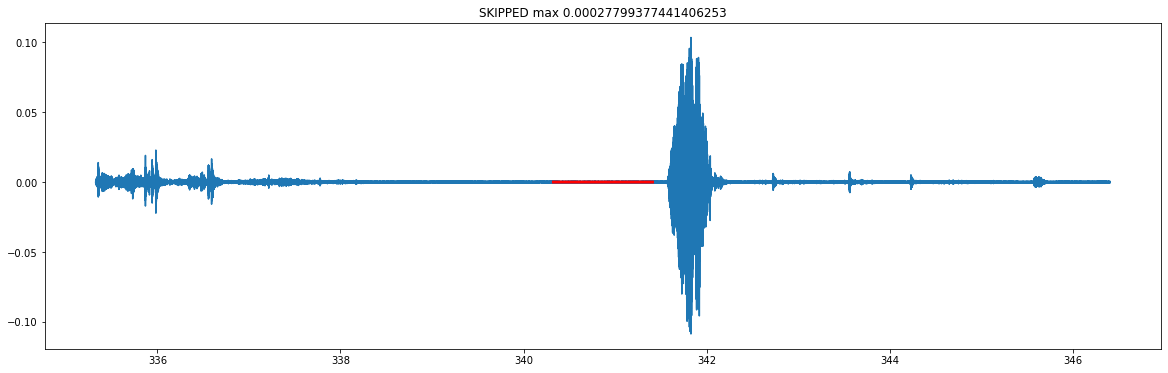

10669 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669]
READ_HEAD 10669
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(6757, 6760)]
cutoff -78.44221105527639 #silences 11: [(1766, 1768), (3799, 3801), (6754, 6764), (6768, 6770), (7084, 7086), (7150, 7154), (7158, 7161), (7310, 7313), (7335, 7338), (7341, 7344)]
cutoff -78.13065326633166 #silences 42: [(346, 348), (946, 950), (1120, 1122), (1727, 1729), (1764, 1768), (2104, 2106), (2109, 2114), (2391, 2393), (2689, 2694), 

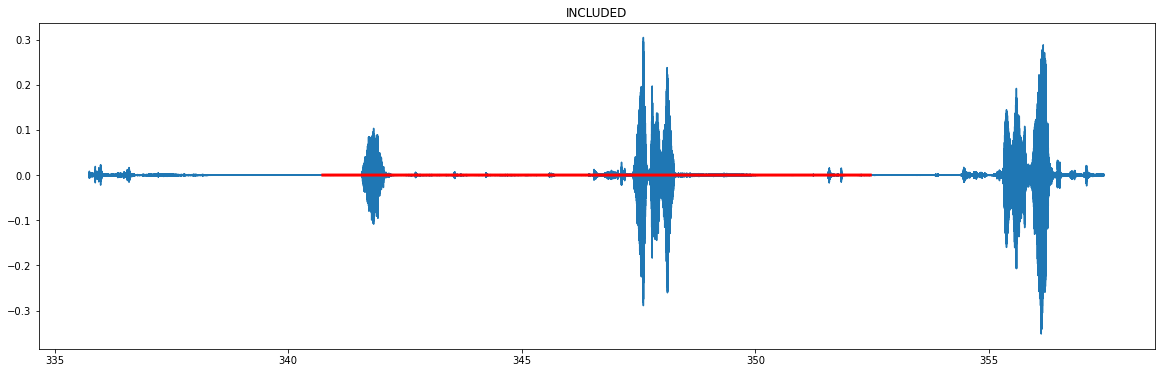

[NeMo I 2020-10-30 00:00:48 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:48 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ờ ở đi xhạo qá|


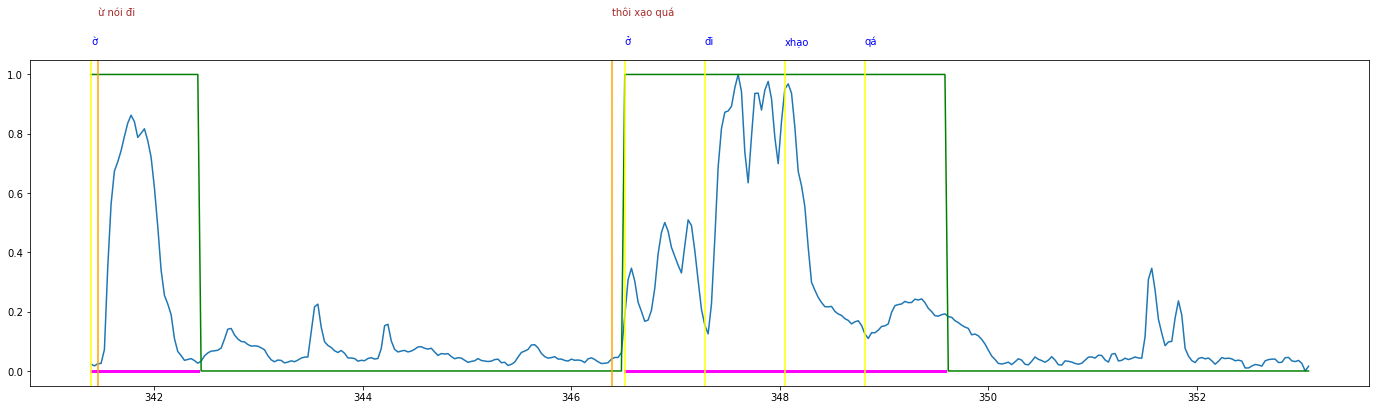

11015 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015]
READ_HEAD 11015
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(6411, 6414)]
cutoff -78.44221105527639 #silences 11: [(1420, 1422), (3453, 3455), (6408, 6418), (6422, 6424), (6738, 6740), (6804, 6808), (6812, 6815), (6964, 6967), (6989, 6992), (6995, 6998)]
cutoff -78.13065326633166 #silences 42: [(0, 2), (600, 604), (774, 776), (1381, 1383), (1418, 1422), (1758, 1760), (1763, 1768), (2045, 2047), (2343, 2348),

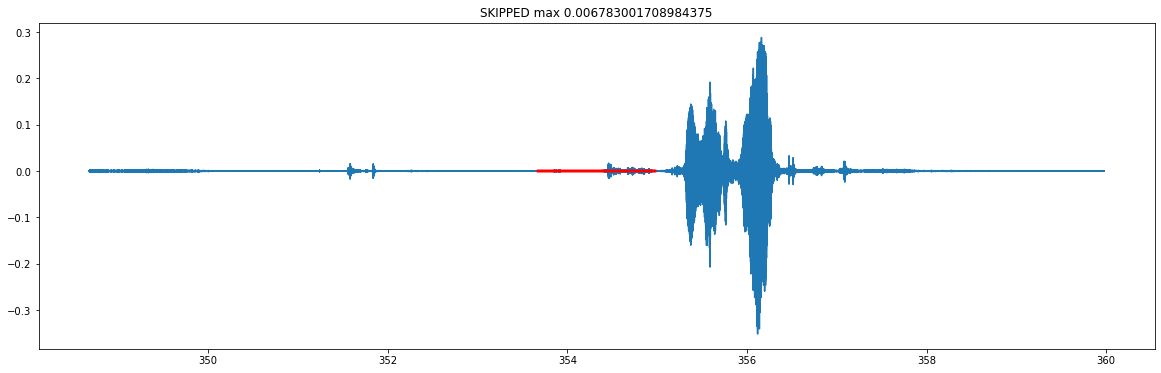

11093 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093]
READ_HEAD 11093
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(6333, 6336)]
cutoff -78.44221105527639 #silences 11: [(1342, 1344), (3375, 3377), (6330, 6340), (6344, 6346), (6660, 6662), (6726, 6730), (6734, 6737), (6886, 6889), (6911, 6914), (6917, 6920)]
cutoff -78.13065326633166 #silences 41: [(522, 526), (696, 698), (1303, 1305), (1340, 1344), (1680, 1682), (1685, 1690), (1967, 1969), (2265, 2270), 

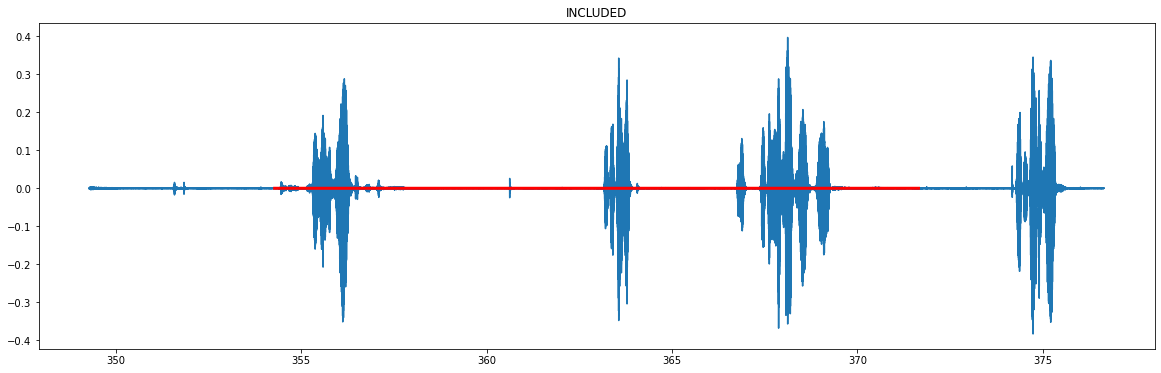

[NeMo I 2020-10-30 00:00:48 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:48 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |hôi hông dá ó điện cho ng ờ thì chị điện lại cị nói được ở đi|


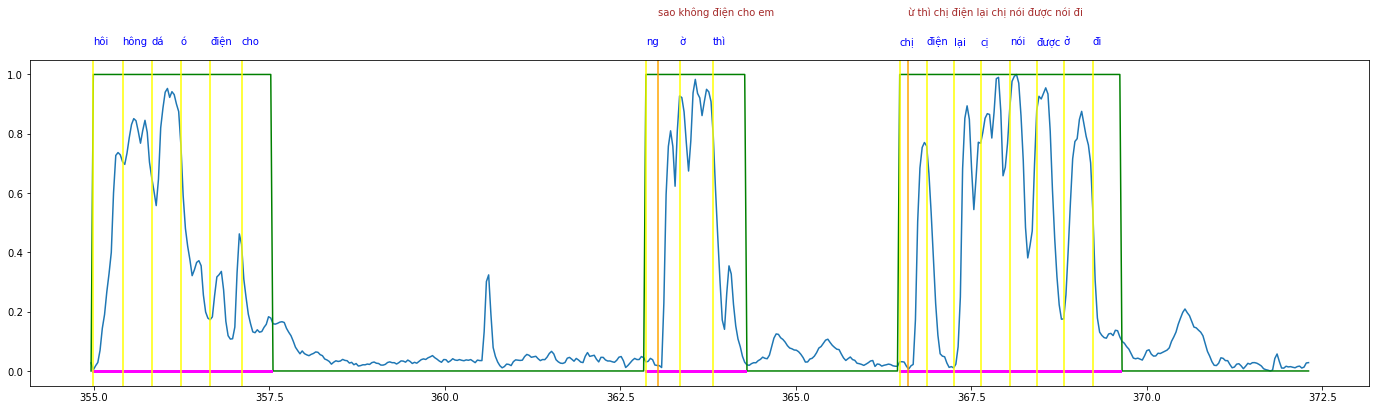

11615 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615]
READ_HEAD 11615
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(5811, 5814)]
cutoff -78.44221105527639 #silences 11: [(820, 822), (2853, 2855), (5808, 5818), (5822, 5824), (6138, 6140), (6204, 6208), (6212, 6215), (6364, 6367), (6389, 6392), (6395, 6398)]
cutoff -78.13065326633166 #silences 41: [(0, 4), (174, 176), (781, 783), (818, 822), (1158, 1160), (1163, 1168), (1445, 1447), (1743, 1748), (17

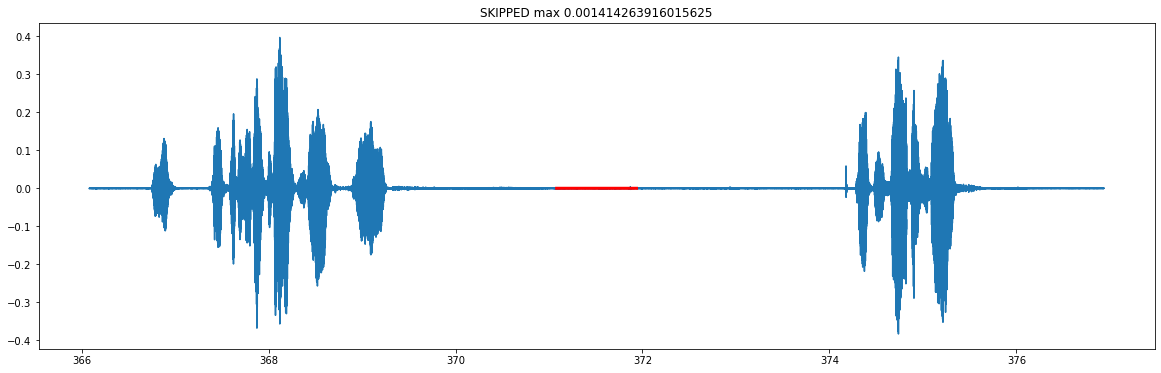

11623 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623]
READ_HEAD 11623
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(5803, 5806)]
cutoff -78.44221105527639 #silences 11: [(812, 814), (2845, 2847), (5800, 5810), (5814, 5816), (6130, 6132), (6196, 6200), (6204, 6207), (6356, 6359), (6381, 6384), (6387, 6390)]
cutoff -78.13065326633166 #silences 40: [(166, 168), (773, 775), (810, 814), (1150, 1152), (1155, 1160), (1437, 1439), (1735, 1740), (175

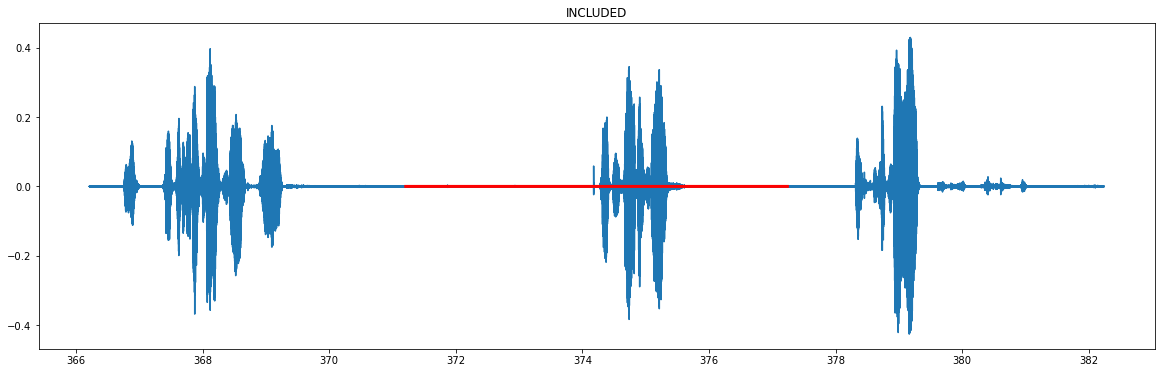

[NeMo I 2020-10-30 00:00:49 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:49 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |è còo tện đâuà đê|


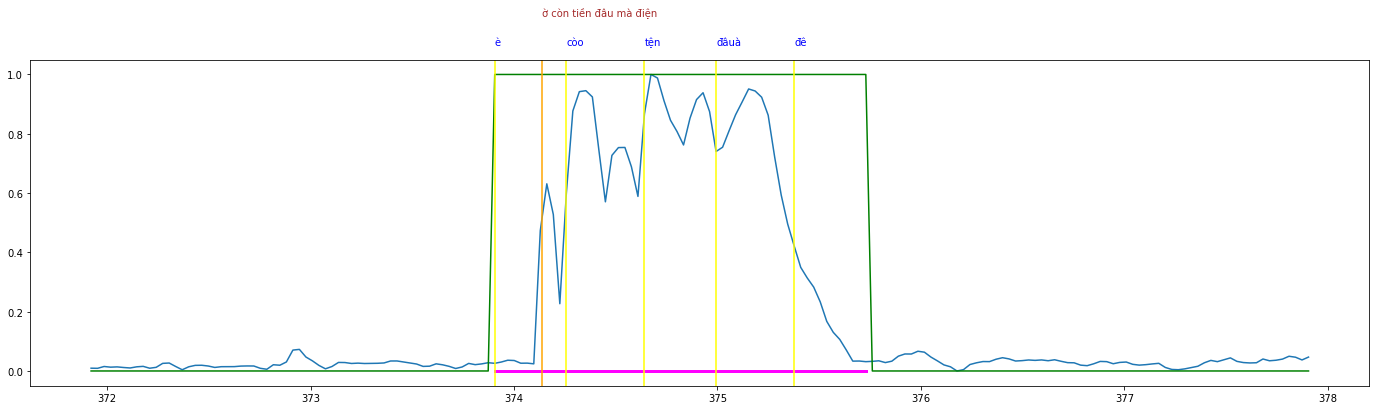

11789 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789]
READ_HEAD 11789
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(5637, 5640)]
cutoff -78.44221105527639 #silences 11: [(646, 648), (2679, 2681), (5634, 5644), (5648, 5650), (5964, 5966), (6030, 6034), (6038, 6041), (6190, 6193), (6215, 6218), (6221, 6224)]
cutoff -78.13065326633166 #silences 40: [(0, 2), (607, 609), (644, 648), (984, 986), (989, 994), (1271, 1273), (1569, 1574), (1584

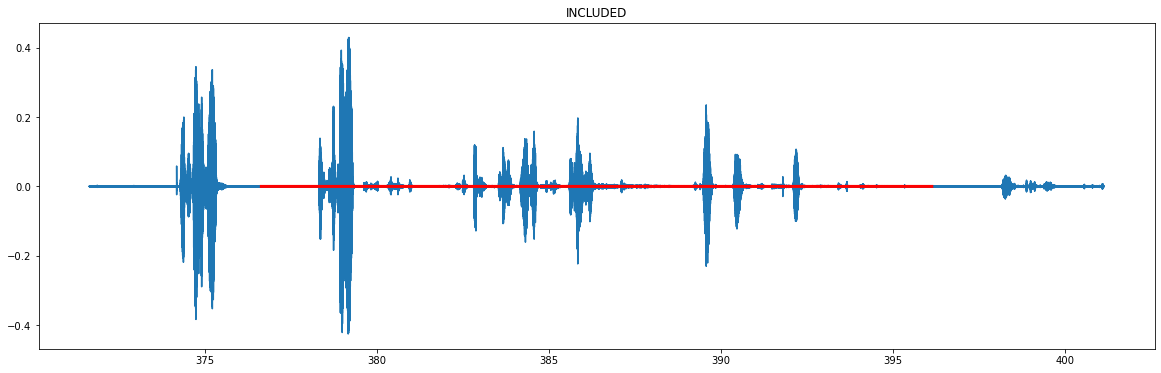

[NeMo I 2020-10-30 00:00:49 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:49 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |cồn nhữ thuống nan dái hả chản trêng đâu đi ủa lộn quên ổng thì ổng đi ừ bả|


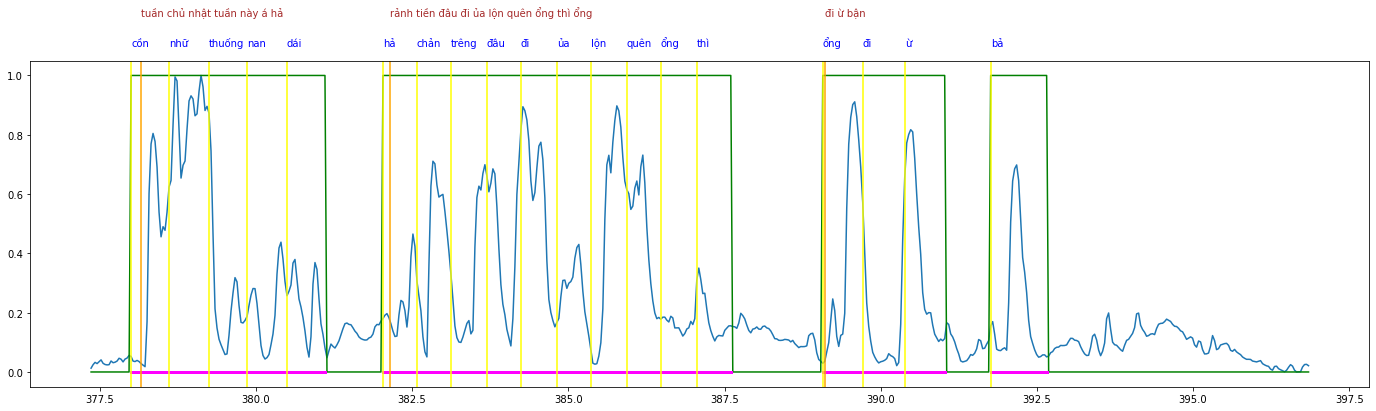

12380 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380]
READ_HEAD 12380
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(5046, 5049)]
cutoff -78.44221105527639 #silences 11: [(55, 57), (2088, 2090), (5043, 5053), (5057, 5059), (5373, 5375), (5439, 5443), (5447, 5450), (5599, 5602), (5624, 5627), (5630, 5633)]
stop to read 12380 12435


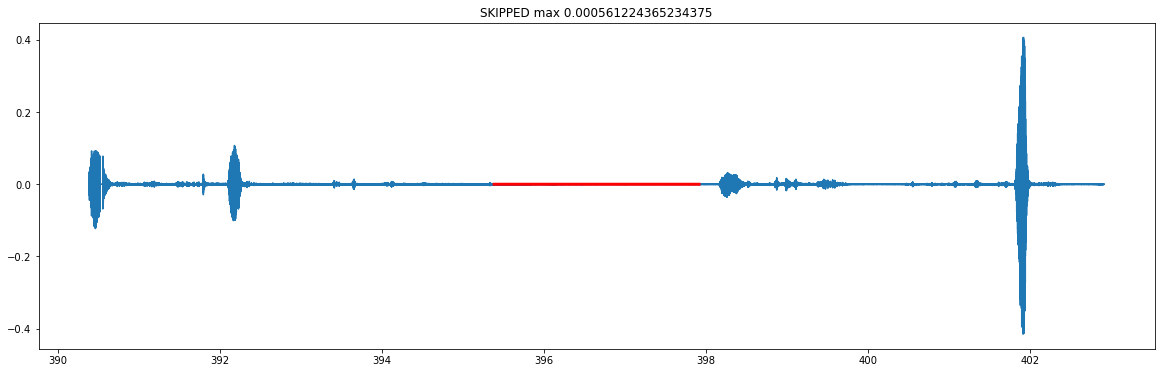

12435 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435]
READ_HEAD 12435
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4991, 4994)]
cutoff -78.44221105527639 #silences 11: [(0, 2), (2033, 2035), (4988, 4998), (5002, 5004), (5318, 5320), (5384, 5388), (5392, 5395), (5544, 5547), (5569, 5572), (5575, 5578)]
advance past silence 12437 2
cutoff -78.13065326633166 #silences 37: [(336, 338), (341, 346), (623, 625), (921, 926), (9

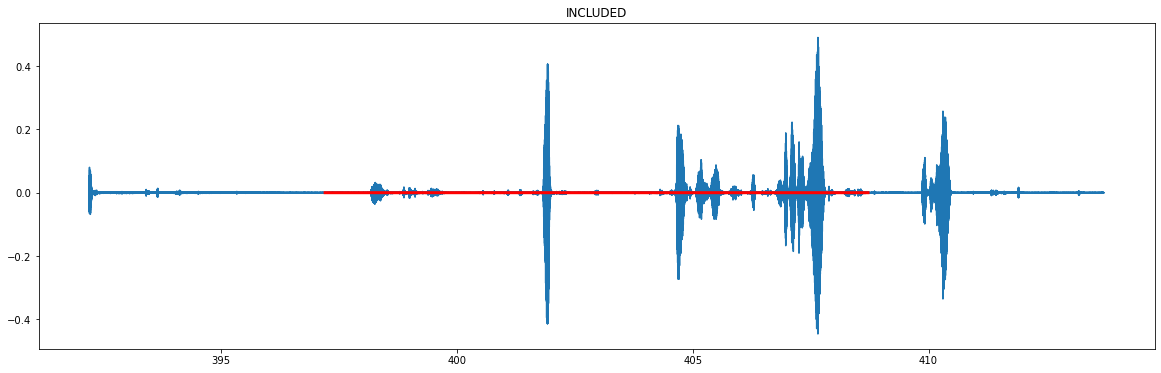

[NeMo I 2020-10-30 00:00:50 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:50 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ờ hả c xe chửa sửa khiế nhưng mà thệt hàaà giả|


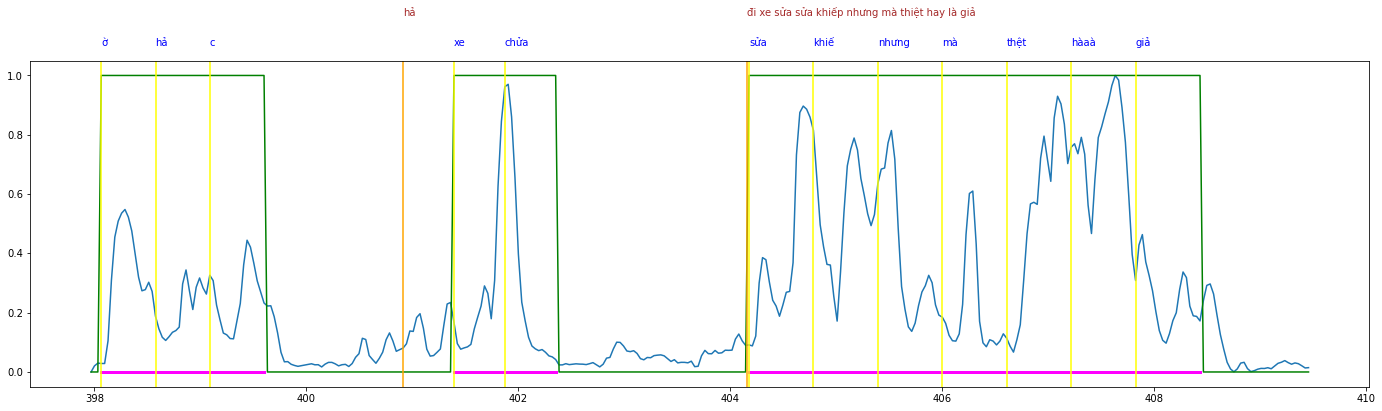

12773 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773]
READ_HEAD 12773
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4653, 4656)]
cutoff -78.44221105527639 #silences 10: [(1695, 1697), (4650, 4660), (4664, 4666), (4980, 4982), (5046, 5050), (5054, 5057), (5206, 5209), (5231, 5234), (5237, 5240), (5748, 5752)]
cutoff -78.13065326633166 #silences 37: [(0, 2), (5, 10), (287, 289), (585, 590), (600, 604), (610, 612), (

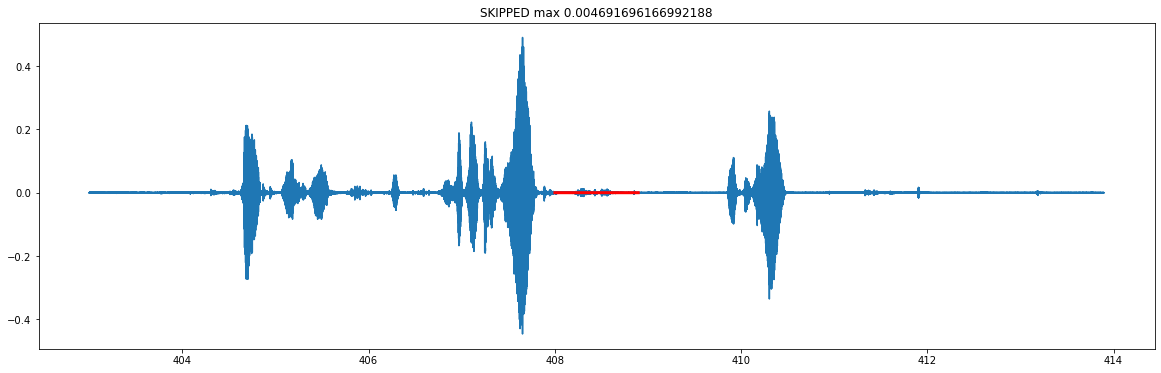

12778 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778]
READ_HEAD 12778
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4648, 4651)]
cutoff -78.44221105527639 #silences 10: [(1690, 1692), (4645, 4655), (4659, 4661), (4975, 4977), (5041, 5045), (5049, 5052), (5201, 5204), (5226, 5229), (5232, 5235), (5743, 5747)]
cutoff -78.13065326633166 #silences 36: [(0, 5), (282, 284), (580, 585), (595, 599), (605, 607), (61

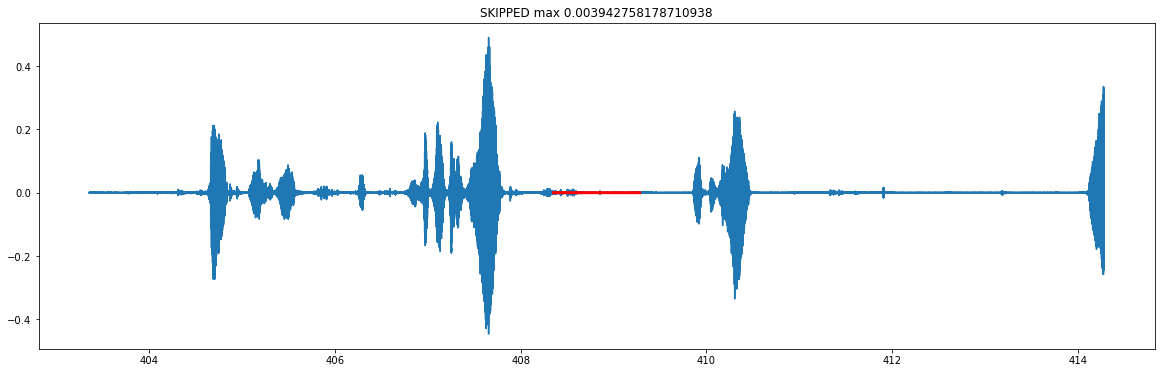

12790 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790]
READ_HEAD 12790
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4636, 4639)]
cutoff -78.44221105527639 #silences 10: [(1678, 1680), (4633, 4643), (4647, 4649), (4963, 4965), (5029, 5033), (5037, 5040), (5189, 5192), (5214, 5217), (5220, 5223), (5731, 5735)]
cutoff -78.13065326633166 #silences 35: [(270, 272), (568, 573), (583, 587), (593, 595), (600

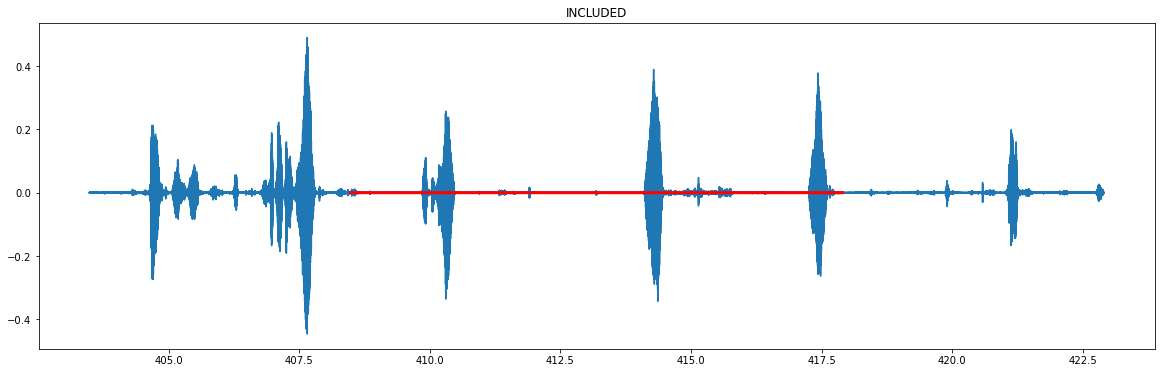

[NeMo I 2020-10-30 00:00:50 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:50 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |vậy a giả có|
empty translation
13060 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060]
READ_HEAD 13060
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4366, 4369)]
cutoff -78.44221105527639 #silences 10: 

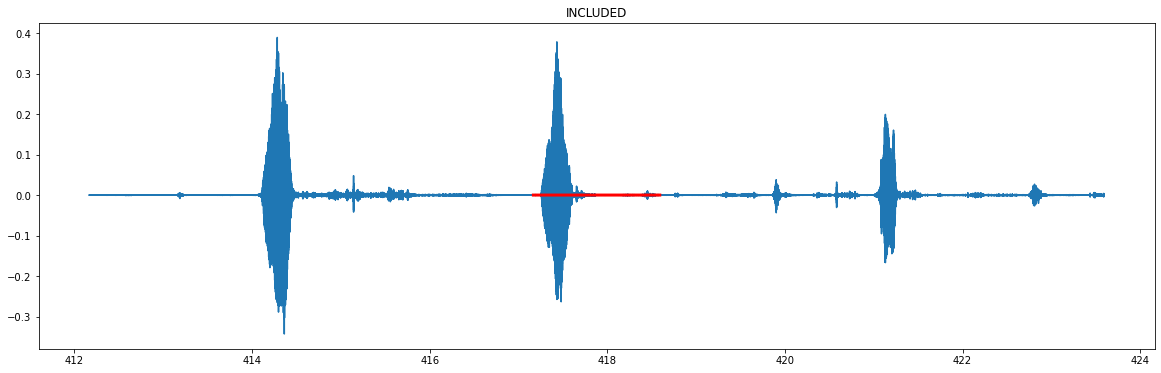

[NeMo I 2020-10-30 00:00:51 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:51 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |có|


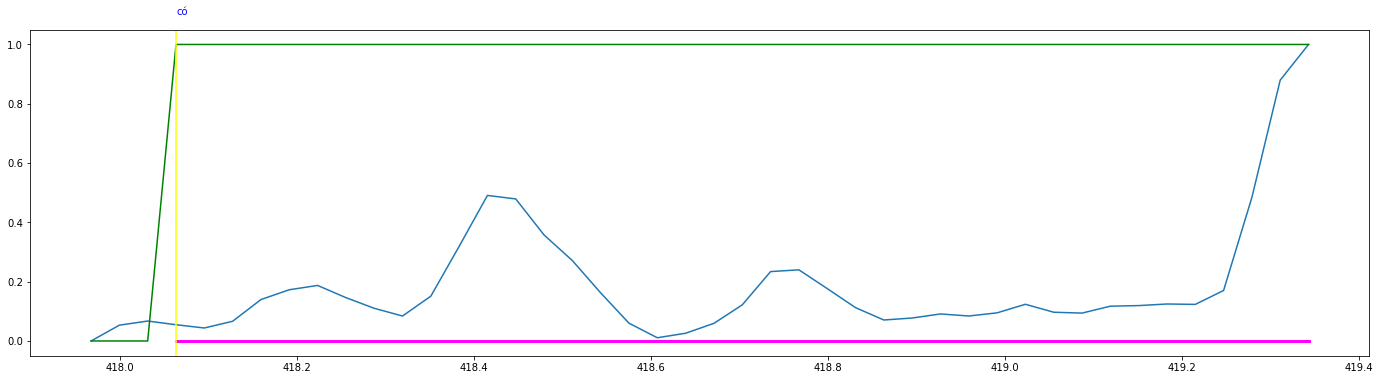

13081 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081]
READ_HEAD 13081
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4345, 4348)]
cutoff -78.44221105527639 #silences 10: [(1387, 1389), (4342, 4352), (4356, 4358), (4672, 4674), (4738, 4742), (4746, 4749), (4898, 4901), (4923, 4926), (4929, 4932), (5440, 5444)]
cutoff -78.13065326633166 #silences 34: [(277, 282), (292, 296), (302, 304), (3

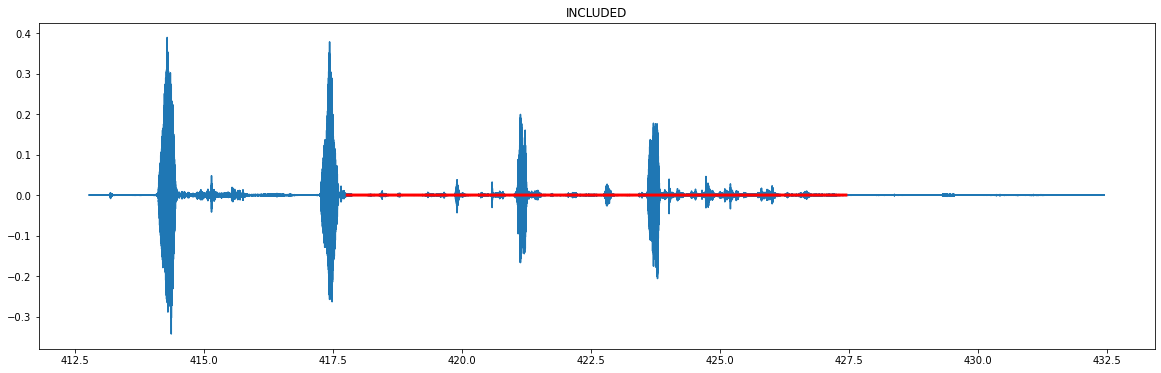

[NeMo I 2020-10-30 00:00:51 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:51 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ờờ ẻ|


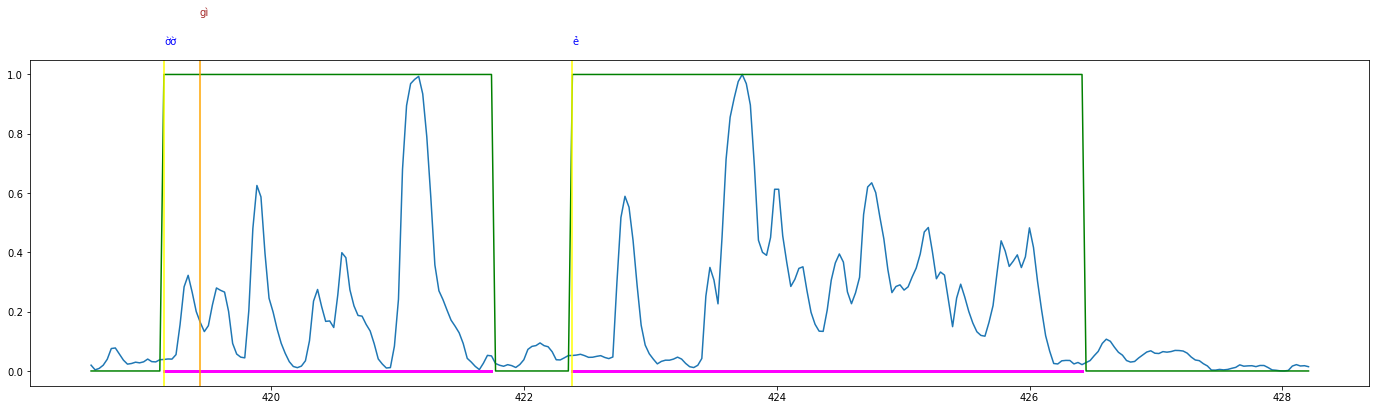

13358 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358]
READ_HEAD 13358
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4068, 4071)]
cutoff -78.44221105527639 #silences 10: [(1110, 1112), (4065, 4075), (4079, 4081), (4395, 4397), (4461, 4465), (4469, 4472), (4621, 4624), (4646, 4649), (4652, 4655), (5163, 5167)]
cutoff -78.13065326633166 #silences 34: [(0, 5), (15, 19), (25, 27), (32

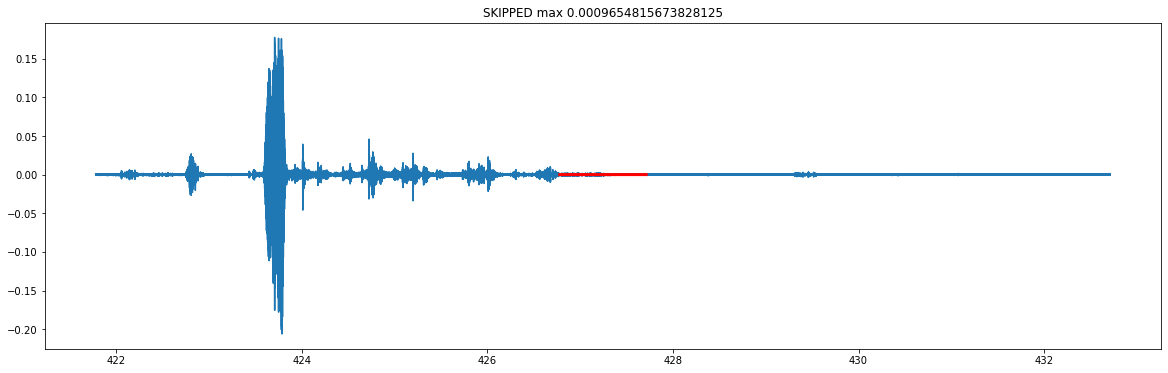

13366 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366]
READ_HEAD 13366
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4060, 4063)]
cutoff -78.44221105527639 #silences 10: [(1102, 1104), (4057, 4067), (4071, 4073), (4387, 4389), (4453, 4457), (4461, 4464), (4613, 4616), (4638, 4641), (4644, 4647), (5155, 5159)]
cutoff -78.13065326633166 #silences 33: [(7, 11), (17, 19), (24, 

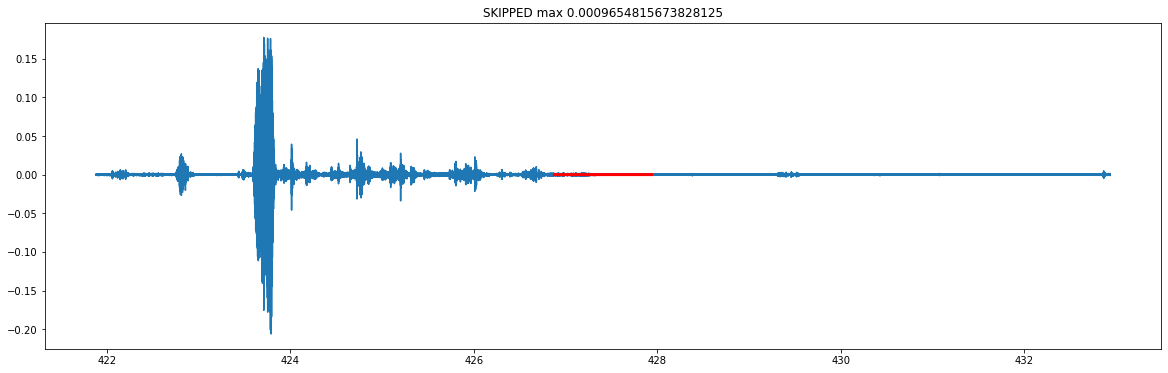

13373 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373]
READ_HEAD 13373
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4053, 4056)]
cutoff -78.44221105527639 #silences 10: [(1095, 1097), (4050, 4060), (4064, 4066), (4380, 4382), (4446, 4450), (4454, 4457), (4606, 4609), (4631, 4634), (4637, 4640), (5148, 5152)]
cutoff -78.13065326633166 #silences 33: [(0, 4), (10, 12),

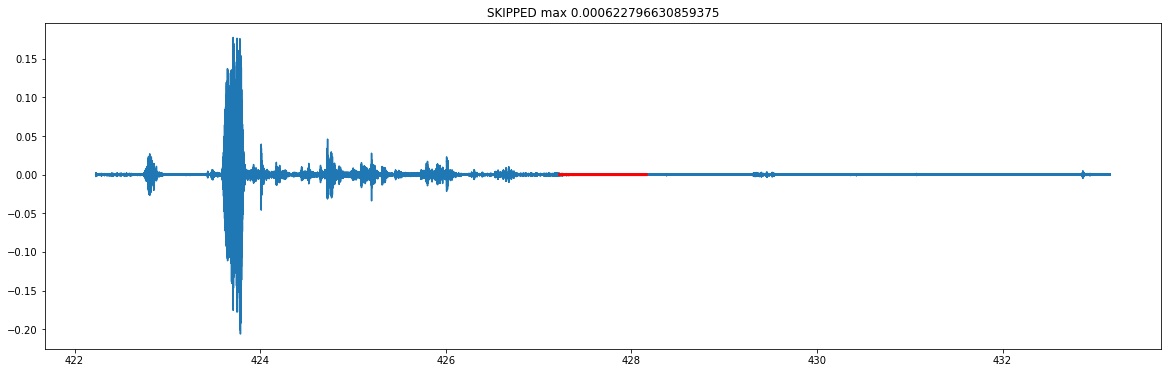

13380 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380]
READ_HEAD 13380
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4046, 4049)]
cutoff -78.44221105527639 #silences 10: [(1088, 1090), (4043, 4053), (4057, 4059), (4373, 4375), (4439, 4443), (4447, 4450), (4599, 4602), (4624, 4627), (4630, 4633), (5141, 5145)]
cutoff -78.13065326633166 #silences 32: [(3, 5), (1

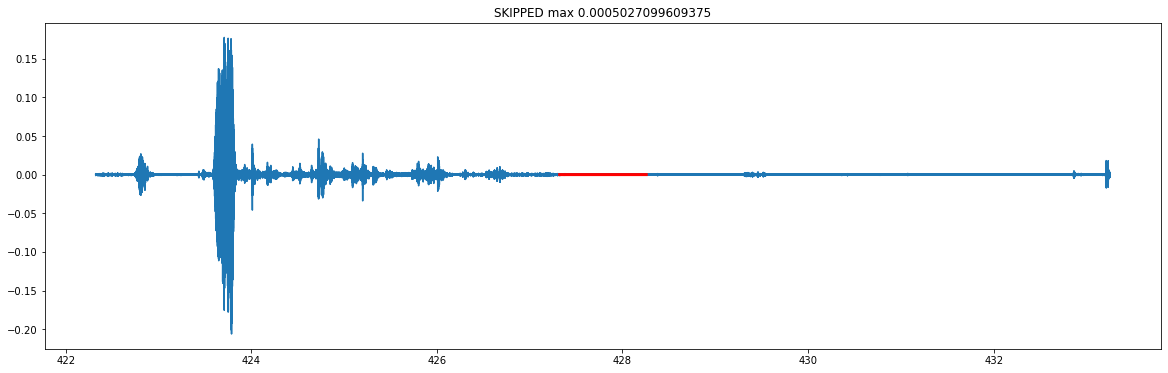

13383 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383]
READ_HEAD 13383
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4043, 4046)]
cutoff -78.44221105527639 #silences 10: [(1085, 1087), (4040, 4050), (4054, 4056), (4370, 4372), (4436, 4440), (4444, 4447), (4596, 4599), (4621, 4624), (4627, 4630), (5138, 5142)]
cutoff -78.13065326633166 #silences 32: [(0,

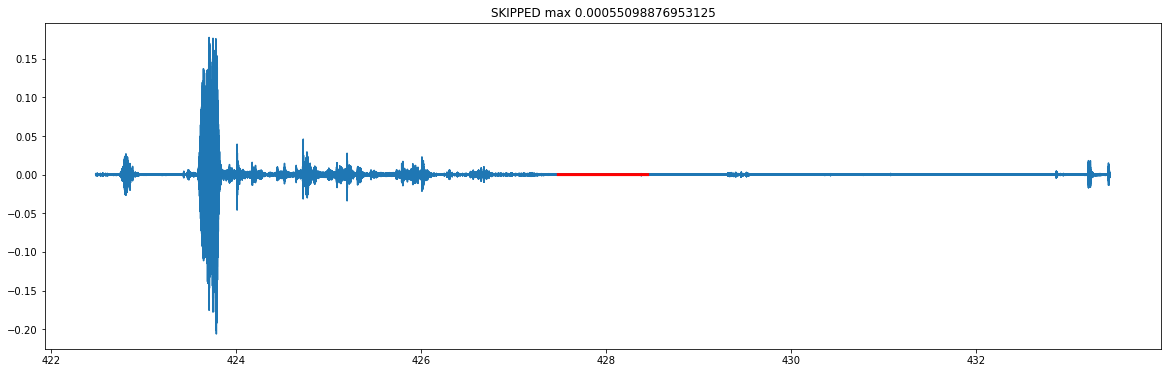

13389 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389]
READ_HEAD 13389
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4037, 4040)]
cutoff -78.44221105527639 #silences 10: [(1079, 1081), (4034, 4044), (4048, 4050), (4364, 4366), (4430, 4434), (4438, 4441), (4590, 4593), (4615, 4618), (4621, 4624), (5132, 5136)]
cutoff -78.13065326633166 #silences 3

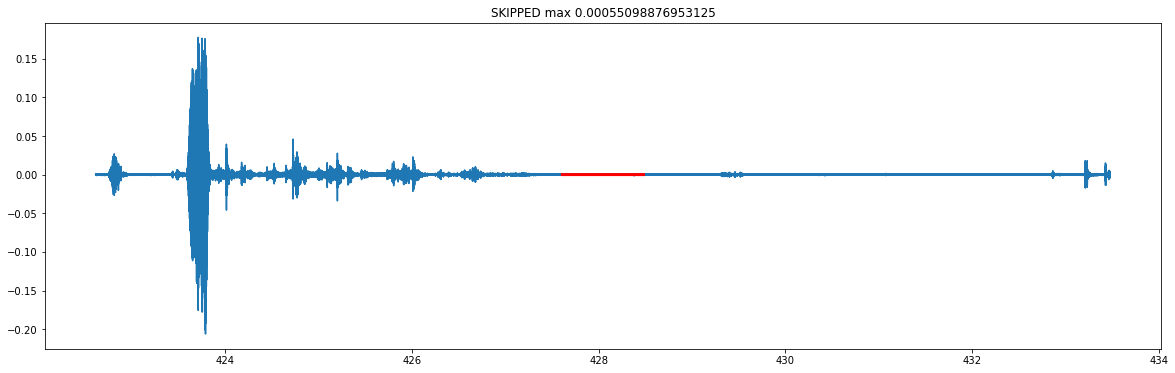

13390 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390]
READ_HEAD 13390
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4036, 4039)]
cutoff -78.44221105527639 #silences 10: [(1078, 1080), (4033, 4043), (4047, 4049), (4363, 4365), (4429, 4433), (4437, 4440), (4589, 4592), (4614, 4617), (4620, 4623), (5131, 5135)]
cutoff -78.13065326633166 #sil

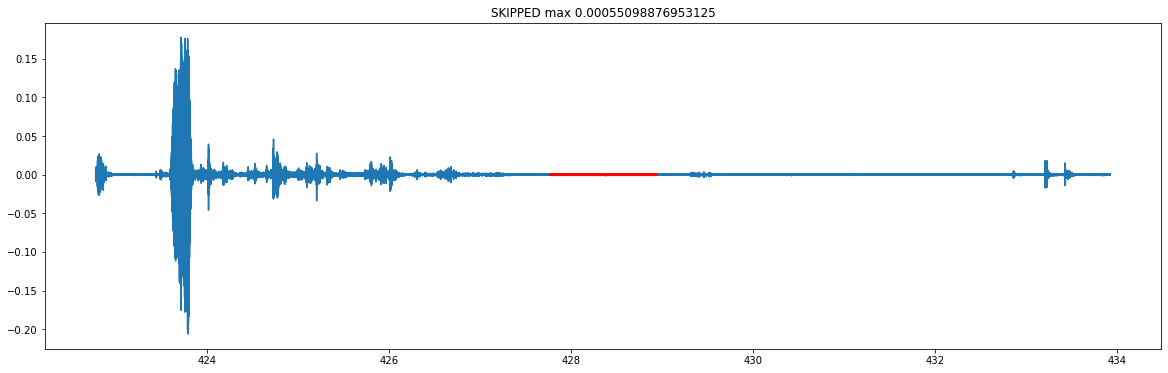

13404 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404]
READ_HEAD 13404
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(4022, 4025)]
cutoff -78.44221105527639 #silences 10: [(1064, 1066), (4019, 4029), (4033, 4035), (4349, 4351), (4415, 4419), (4423, 4426), (4575, 4578), (4600, 4603), (4606, 4609), (5117, 5121)]
cutoff -78.130653266331

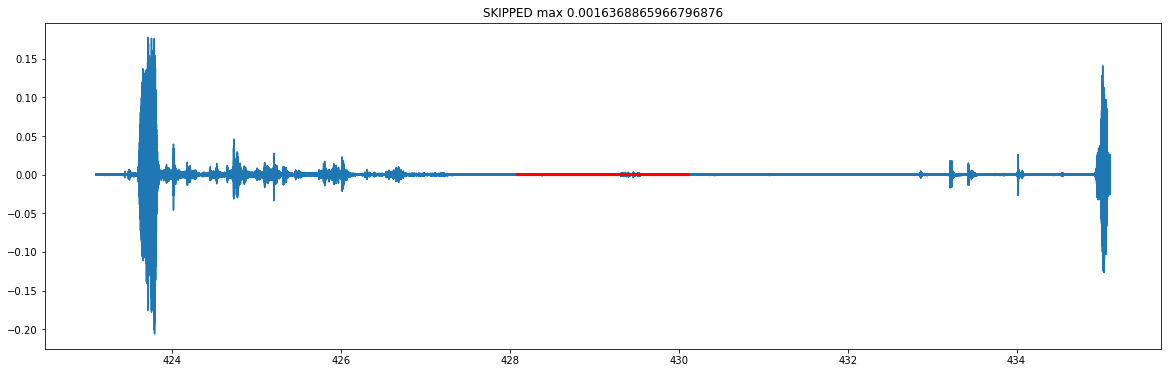

13441 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441]
READ_HEAD 13441
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(3985, 3988)]
cutoff -78.44221105527639 #silences 10: [(1027, 1029), (3982, 3992), (3996, 3998), (4312, 4314), (4378, 4382), (4386, 4389), (4538, 4541), (4563, 4566), (4569, 4572), (5080, 5084)]
cutoff -78.13065

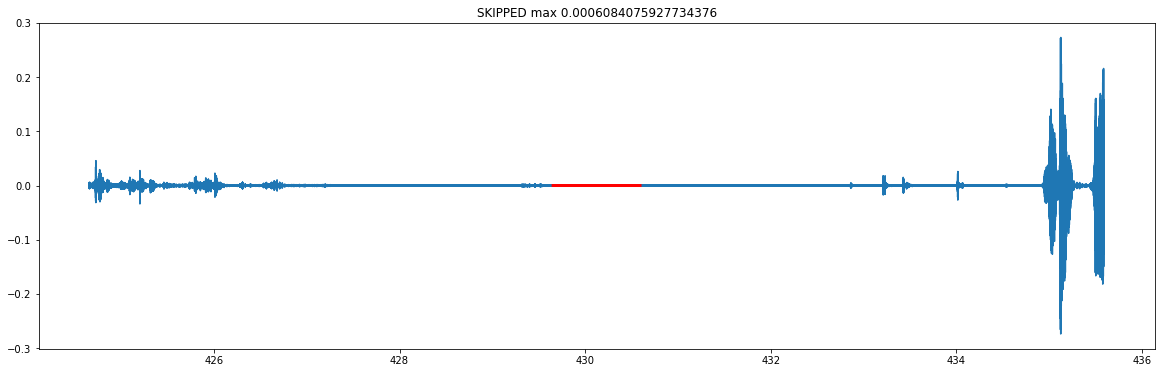

13456 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456]
READ_HEAD 13456
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(3970, 3973)]
cutoff -78.44221105527639 #silences 10: [(1012, 1014), (3967, 3977), (3981, 3983), (4297, 4299), (4363, 4367), (4371, 4374), (4523, 4526), (4548, 4551), (4554, 4557), (5065, 5069)]
cutoff -7

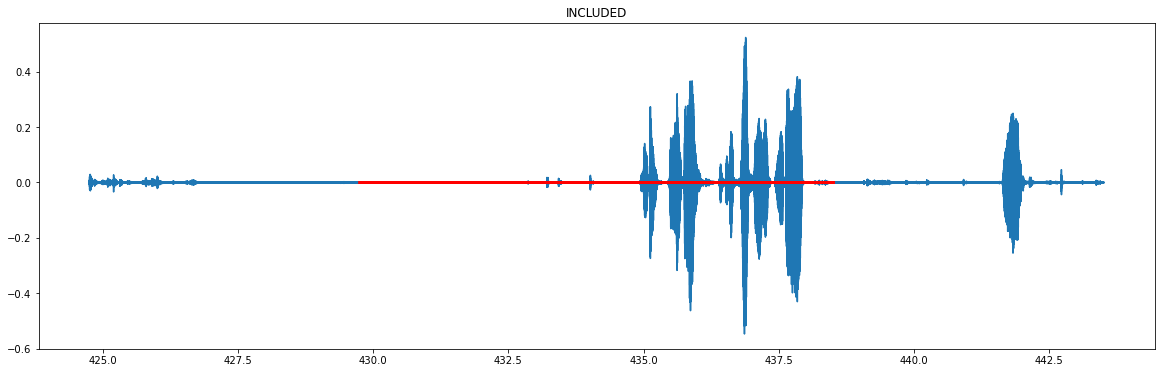

[NeMo I 2020-10-30 00:00:52 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:52 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ông nhi lồu điên đàu nà điệ hông có năm trăm nữa chưa đạp|


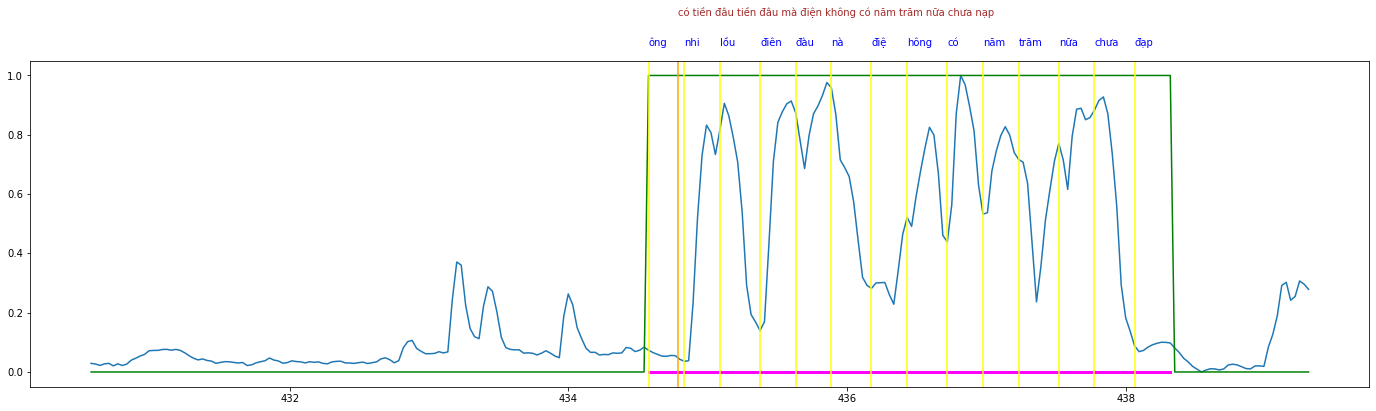

13704 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704]
READ_HEAD 13704
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(3722, 3725)]
cutoff -78.44221105527639 #silences 10: [(764, 766), (3719, 3729), (3733, 3735), (4049, 4051), (4115, 4119), (4123, 4126), (4275, 4278), (4300, 4303), (4306, 4309), (4817, 4821)]
cuto

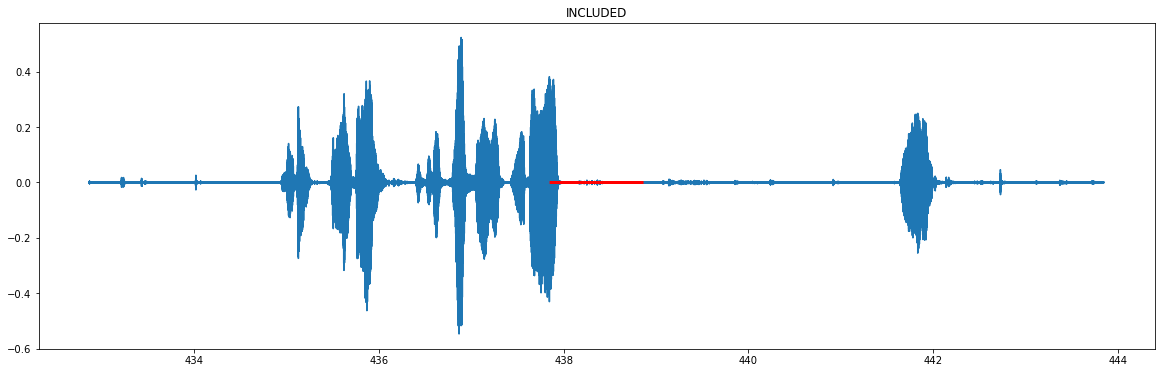

[NeMo I 2020-10-30 00:00:53 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:53 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừ|


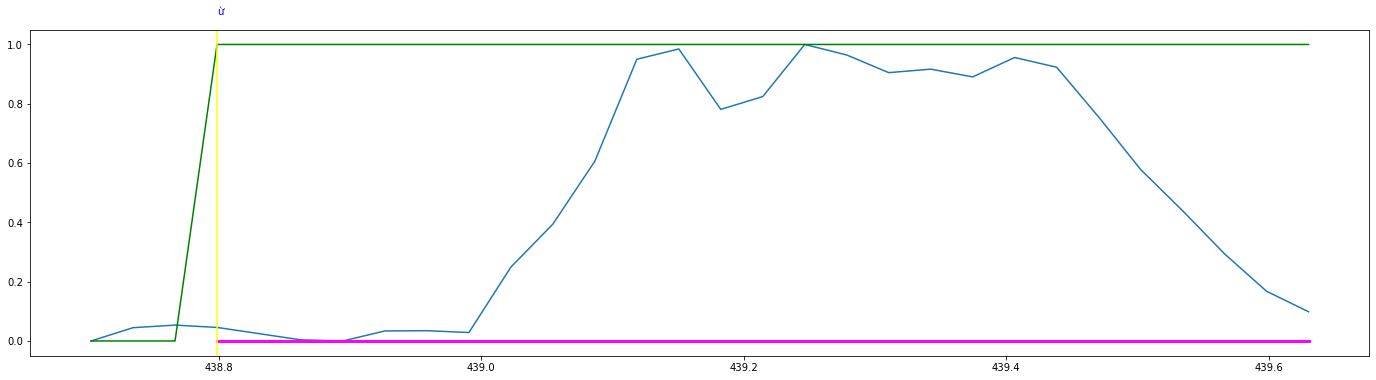

13714 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714]
READ_HEAD 13714
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(3712, 3715)]
cutoff -78.44221105527639 #silences 10: [(754, 756), (3709, 3719), (3723, 3725), (4039, 4041), (4105, 4109), (4113, 4116), (4265, 4268), (4290, 4293), (4296, 4299), (4807, 4811

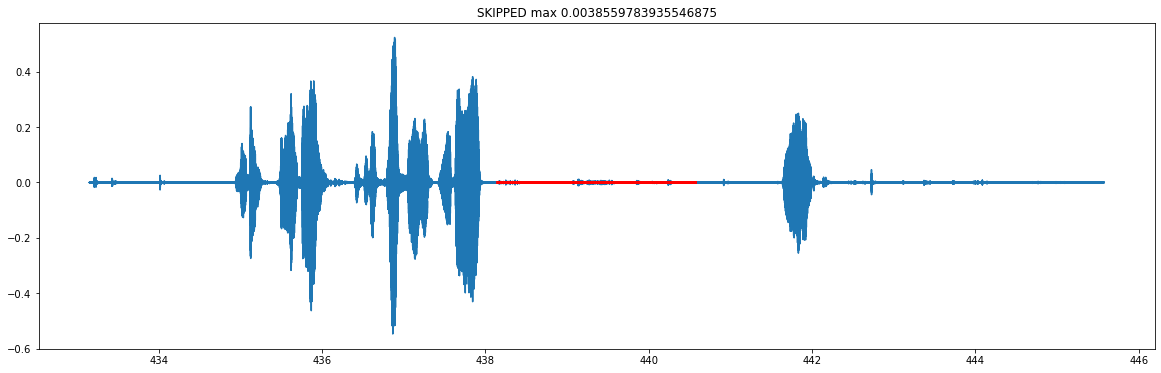

13768 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768]
READ_HEAD 13768
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(3658, 3661)]
cutoff -78.44221105527639 #silences 10: [(700, 702), (3655, 3665), (3669, 3671), (3985, 3987), (4051, 4055), (4059, 4062), (4211, 4214), (4236, 4239), (4242, 4245), (475

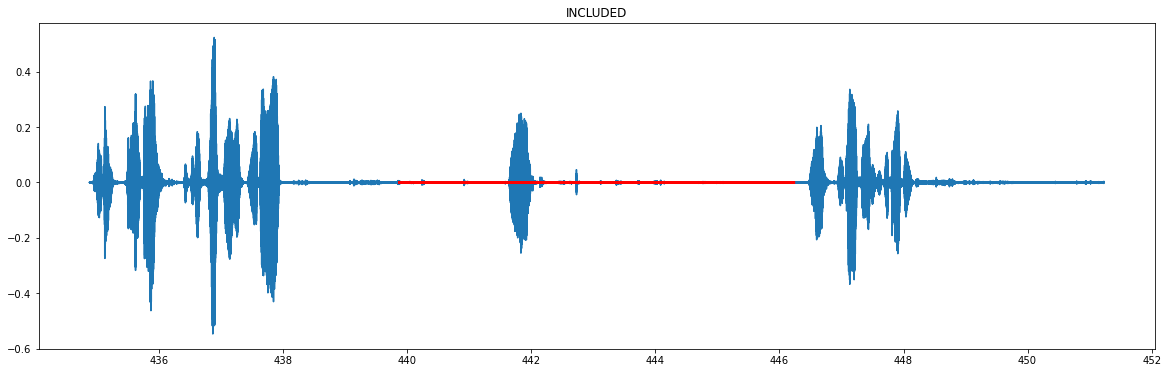

[NeMo I 2020-10-30 00:00:53 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:53 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |c|
empty translation
13945 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945]
READ_HEAD 13945
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []

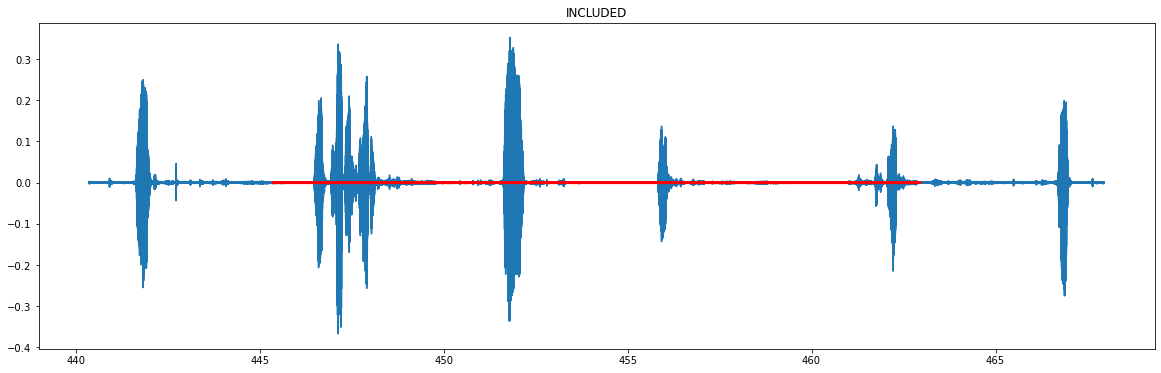

[NeMo I 2020-10-30 00:00:53 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:53 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |hế kế bên nà ả nồi kê vên è có ừ hảà được|


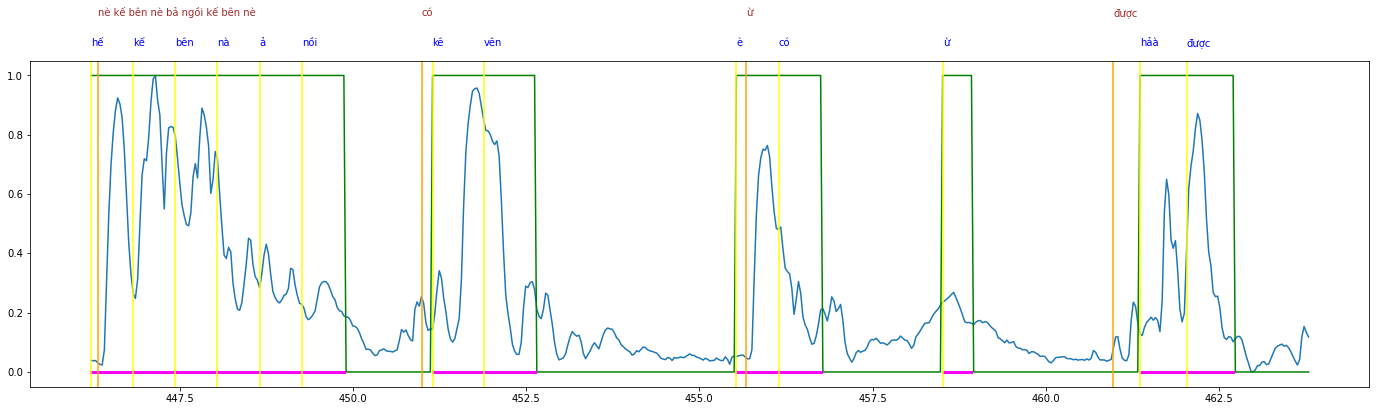

14468 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468]
READ_HEAD 14468
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(2958, 2961)]
cutoff -78.44221105527639 #silences 10: [(0, 2), (2955, 2965), (2969, 2971), (3285, 3287), (3351, 3355), (3359, 3362), (3511, 3514), (3536, 3539), (3542, 3

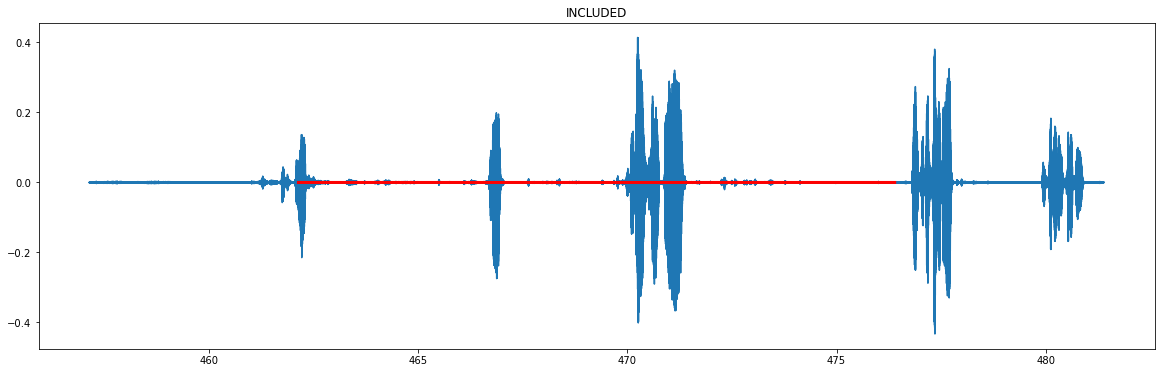

[NeMo I 2020-10-30 00:00:54 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:54 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |cơ ghé nhĩ nó được h được mà|


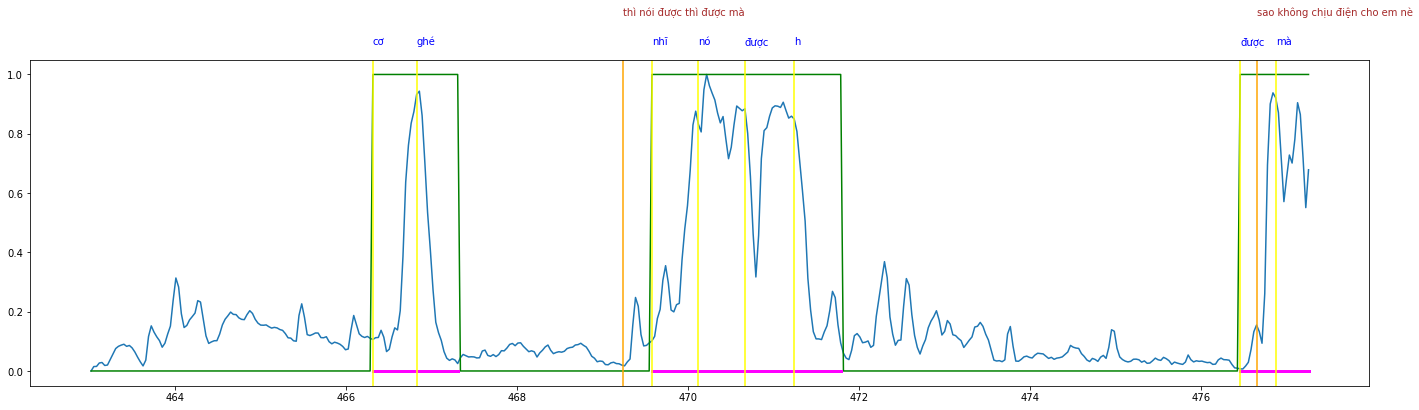

14888 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888]
READ_HEAD 14888
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(2538, 2541)]
cutoff -78.44221105527639 #silences 9: [(2535, 2545), (2549, 2551), (2865, 2867), (2931, 2935), (2939, 2942), (3091, 3094), (3116, 3119), (3122, 312

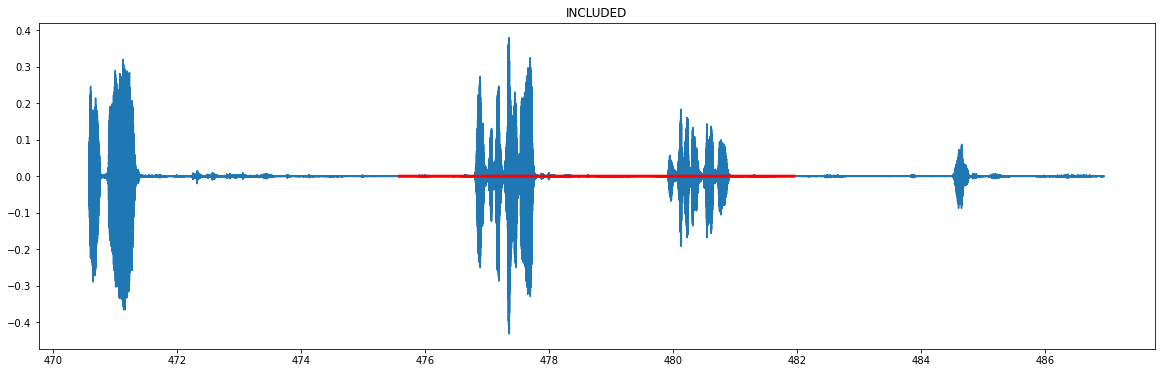

[NeMo I 2020-10-30 00:00:54 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:54 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |cái cị ngi ckiêem mà nãng nghia nó điện cho en nâ|


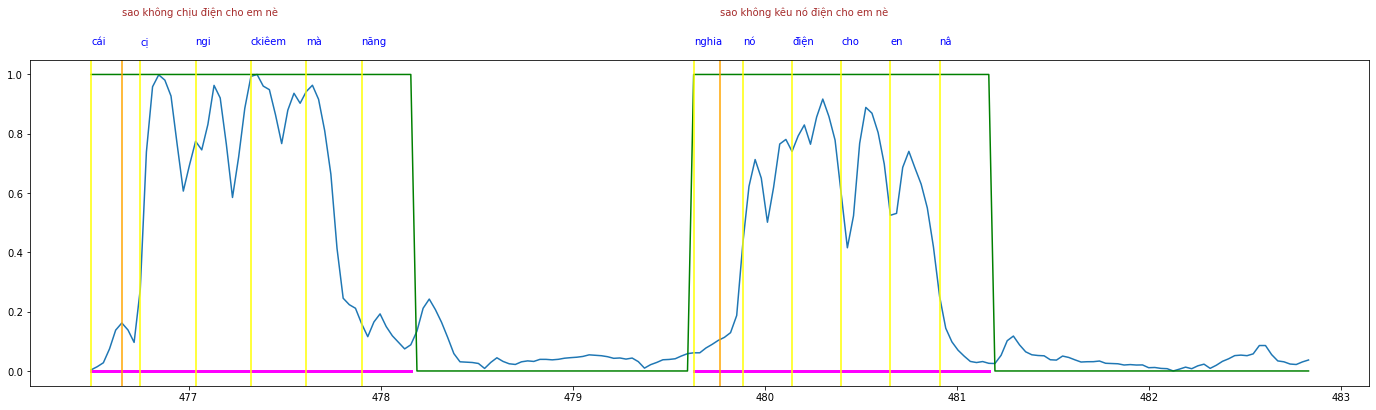

15061 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061]
READ_HEAD 15061
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(2365, 2368)]
cutoff -78.44221105527639 #silences 9: [(2362, 2372), (2376, 2378), (2692, 2694), (2758, 2762), (2766, 2769), (2918, 2921), (2943, 2946), (29

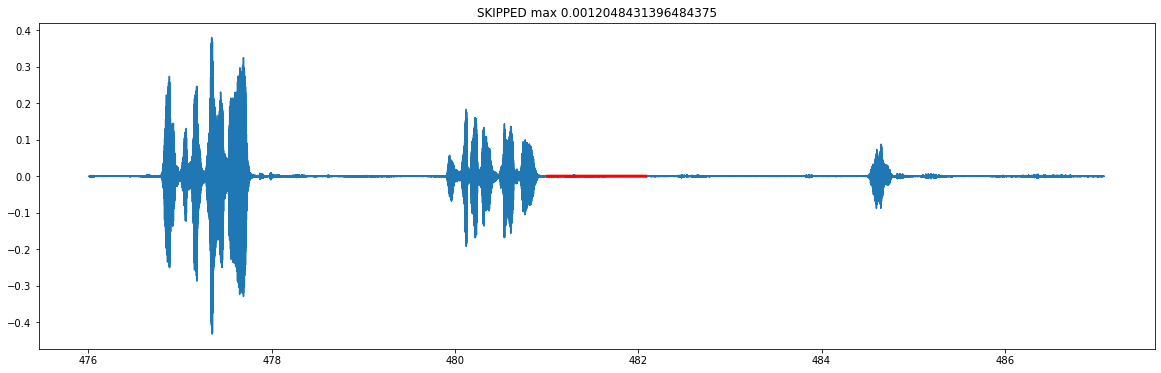

15065 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065]
READ_HEAD 15065
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(2361, 2364)]
cutoff -78.44221105527639 #silences 9: [(2358, 2368), (2372, 2374), (2688, 2690), (2754, 2758), (2762, 2765), (2914, 2917), (2939, 294

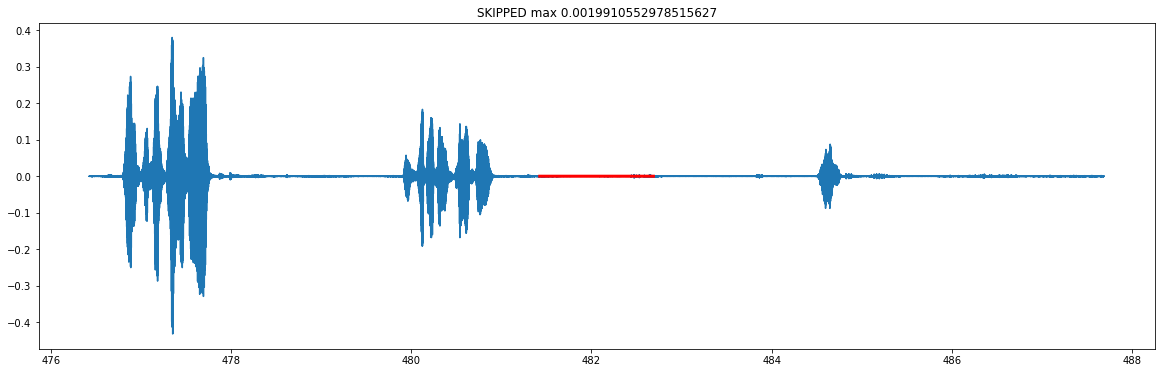

15084 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084]
READ_HEAD 15084
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(2342, 2345)]
cutoff -78.44221105527639 #silences 9: [(2339, 2349), (2353, 2355), (2669, 2671), (2735, 2739), (2743, 2746), (2895, 2898), (29

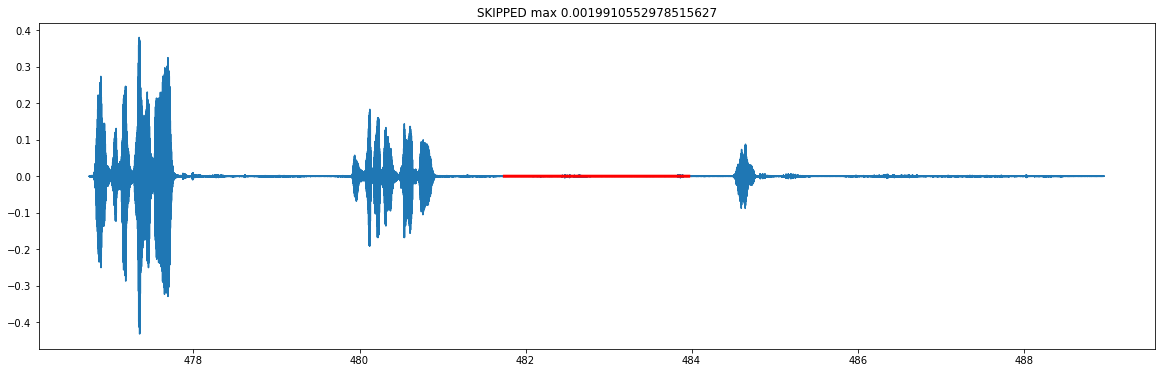

15124 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124]
READ_HEAD 15124
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(2302, 2305)]
cutoff -78.44221105527639 #silences 9: [(2299, 2309), (2313, 2315), (2629, 2631), (2695, 2699), (2703, 2706), (2855, 285

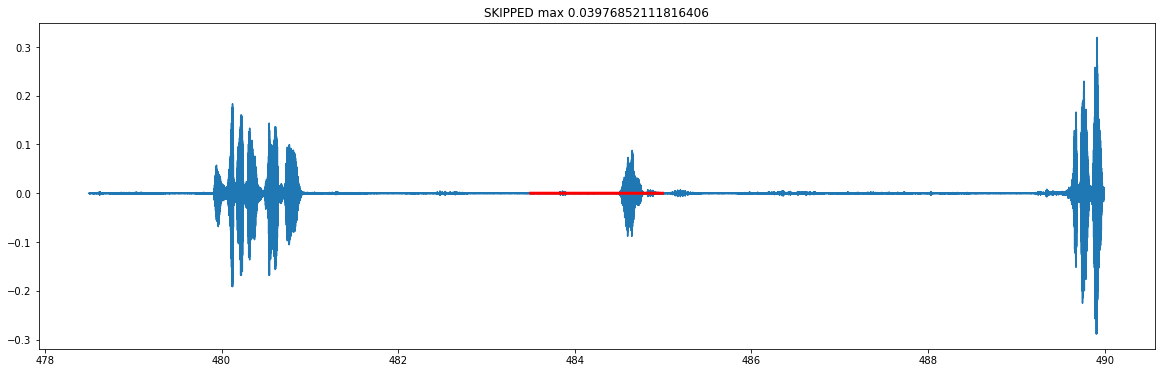

15156 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156]
READ_HEAD 15156
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(2270, 2273)]
cutoff -78.44221105527639 #silences 9: [(2267, 2277), (2281, 2283), (2597, 2599), (2663, 2667), (2671, 2674), (28

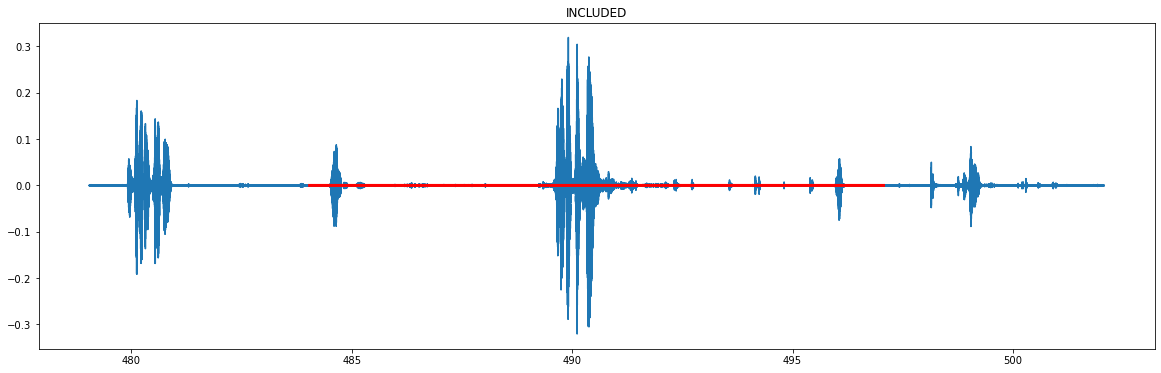

[NeMo I 2020-10-30 00:00:55 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:55 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |h rứ nàu mà biết cai đhi đâu râiạt|


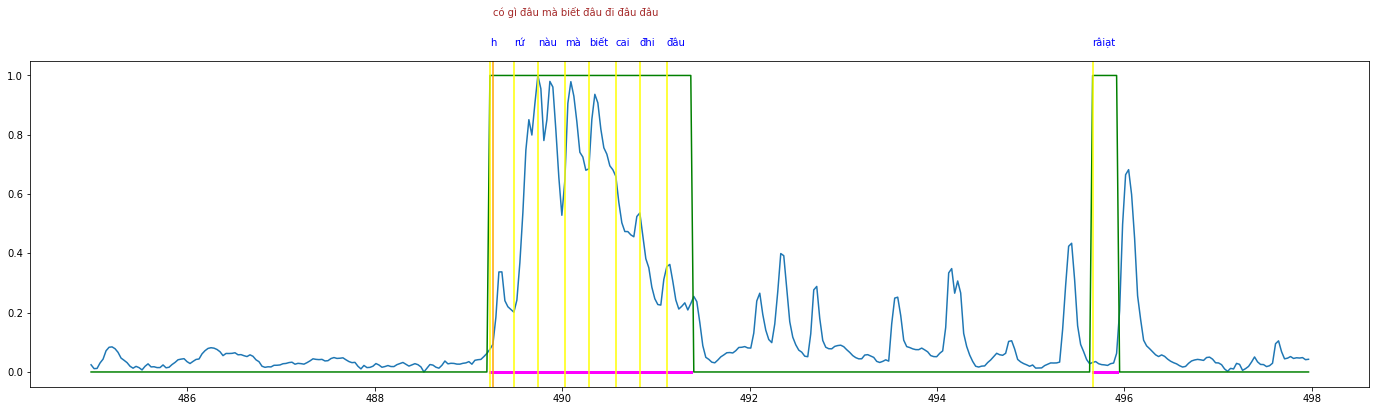

15534 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534]
READ_HEAD 15534
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(1892, 1895)]
cutoff -78.44221105527639 #silences 9: [(1889, 1899), (1903, 1905), (2219, 2221), (2285, 2289), (2293, 229

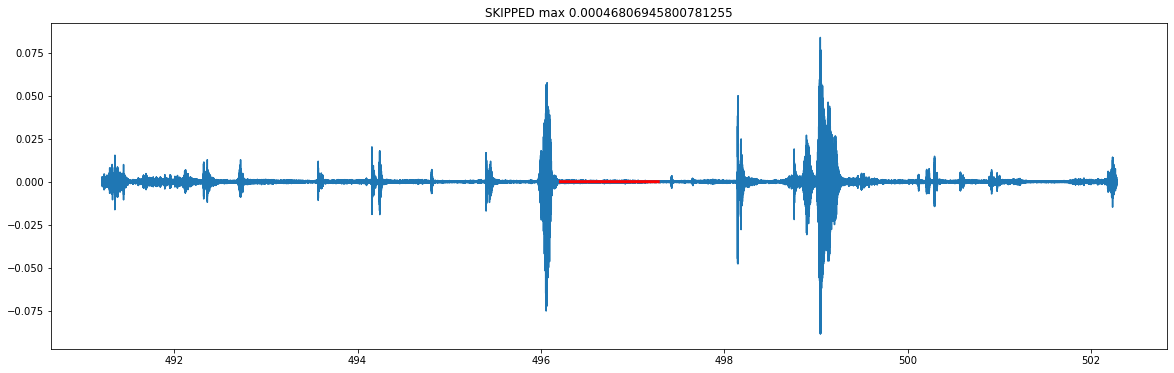

15540 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540]
READ_HEAD 15540
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(1886, 1889)]
cutoff -78.44221105527639 #silences 9: [(1883, 1893), (1897, 1899), (2213, 2215), (2279, 2283), (22

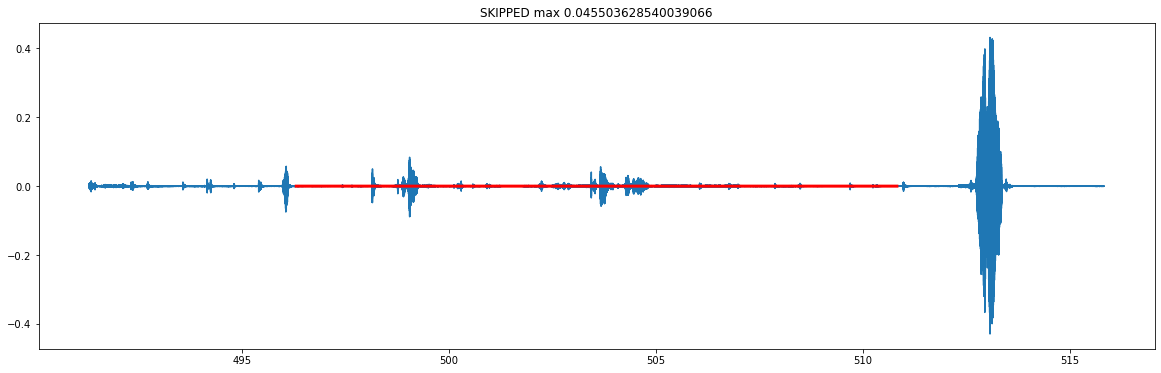

15964 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964]
READ_HEAD 15964
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(1462, 1465)]
cutoff -78.44221105527639 #silences 9: [(1459, 1469), (1473, 1475), (1789, 1791), (1855, 185

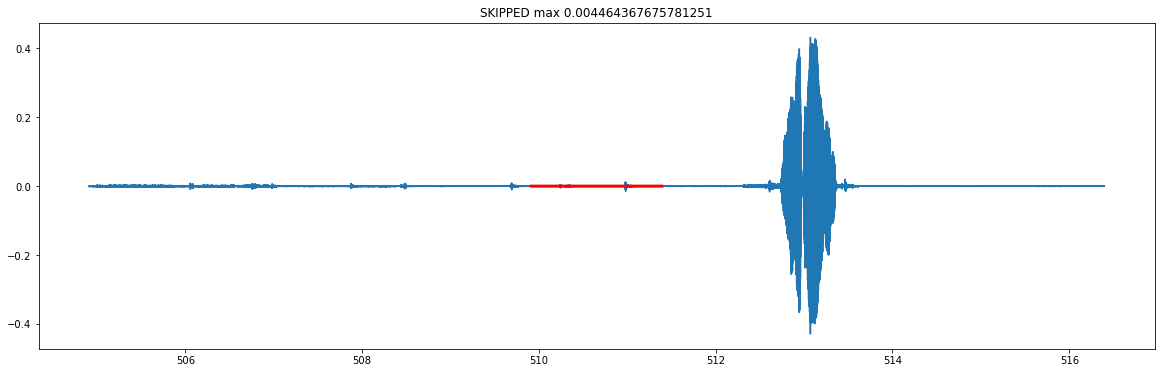

15981 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981]
READ_HEAD 15981
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(1445, 1448)]
cutoff -78.44221105527639 #silences 9: [(1442, 1452), (1456, 1458), (1772, 1774), (18

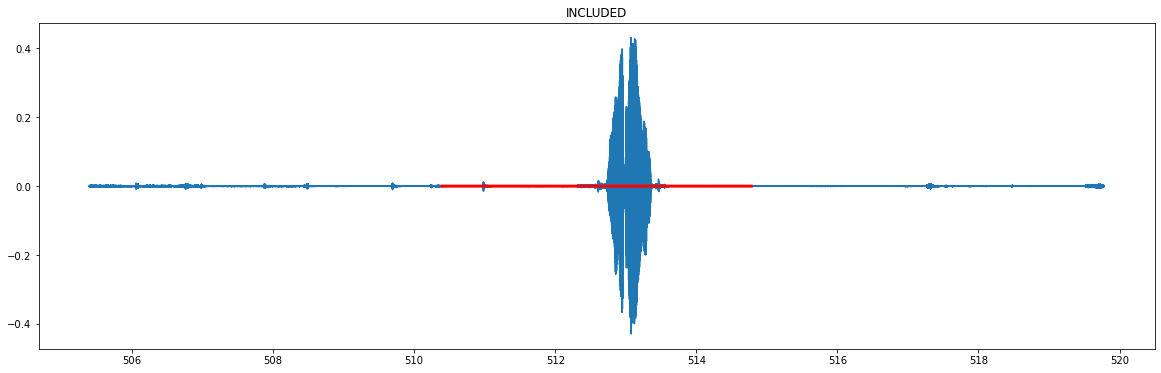

[NeMo I 2020-10-30 00:00:56 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:56 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |lư đó|


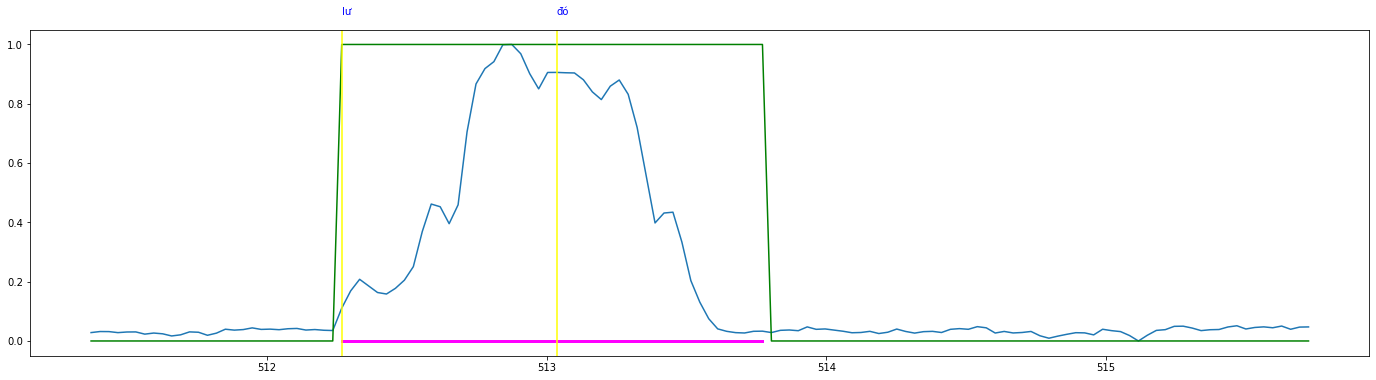

16087 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087]
READ_HEAD 16087
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(1339, 1342)]
cutoff -78.44221105527639 #silences 9: [(1336, 1346), (1350, 1352), (1666, 166

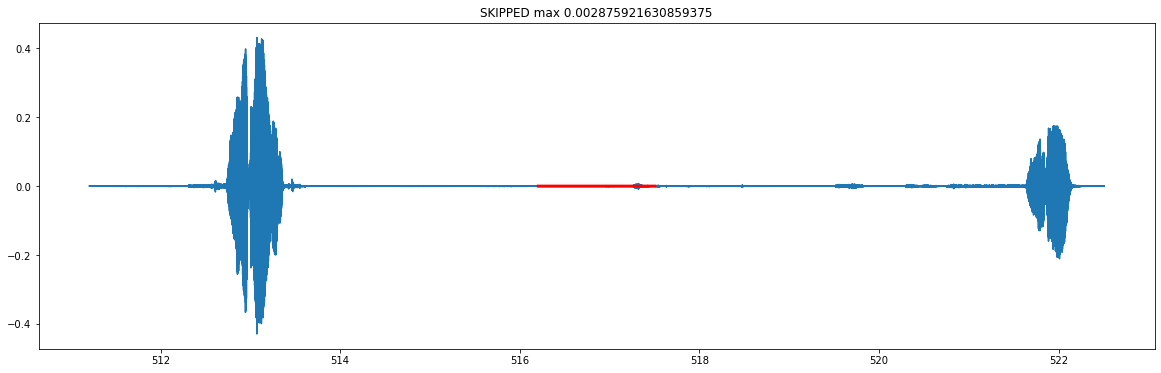

16172 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172]
READ_HEAD 16172
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(1254, 1257)]
cutoff -78.44221105527639 #silences 9: [(1251, 1261), (1265, 1267), (15

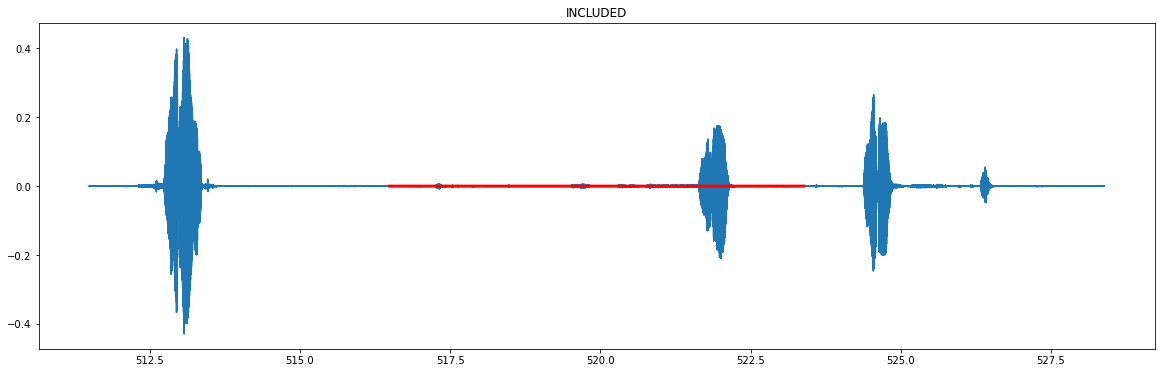

[NeMo I 2020-10-30 00:00:56 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:56 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ờ đó|


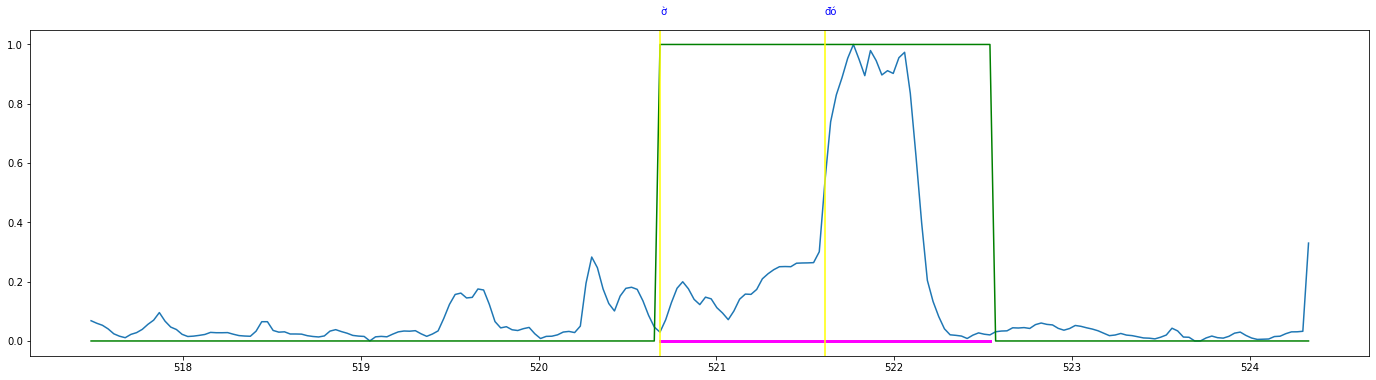

16356 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356]
READ_HEAD 16356
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(1070, 1073)]
cutoff -78.44221105527639 #silences 9: [(1067, 1077), (1081, 108

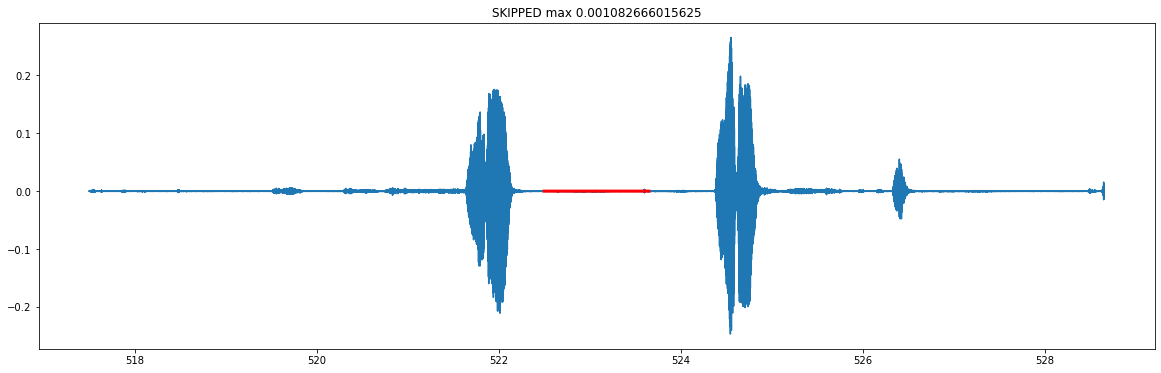

16364 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364]
READ_HEAD 16364
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(1062, 1065)]
cutoff -78.44221105527639 #silences 9: [(1059, 1069), (10

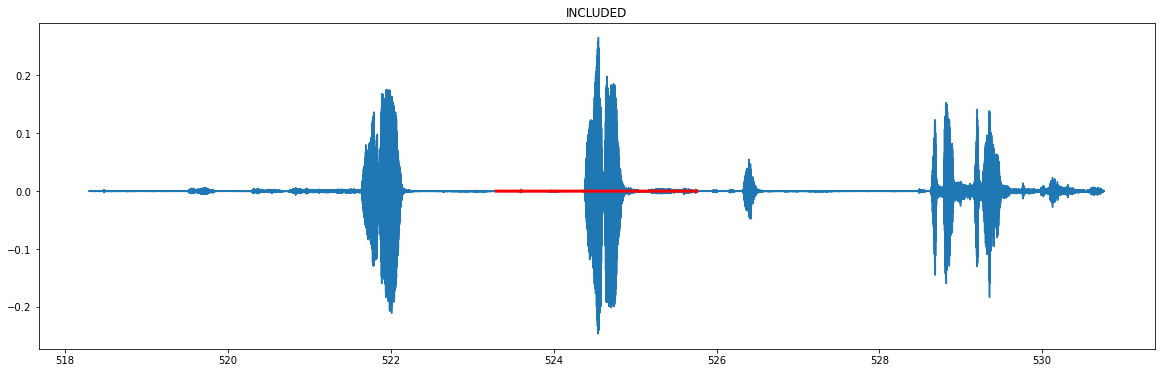

[NeMo I 2020-10-30 00:00:57 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:57 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |có đâ|
empty translation
16430 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430]
READ_HEAD 16430
cutoff -80.0 #silences 0: []
cutoff -7

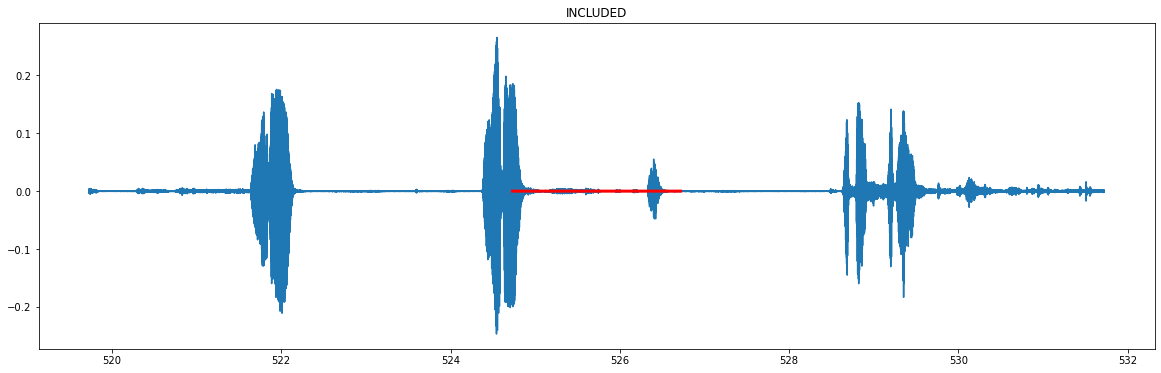

[NeMo I 2020-10-30 00:00:57 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:57 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừ|


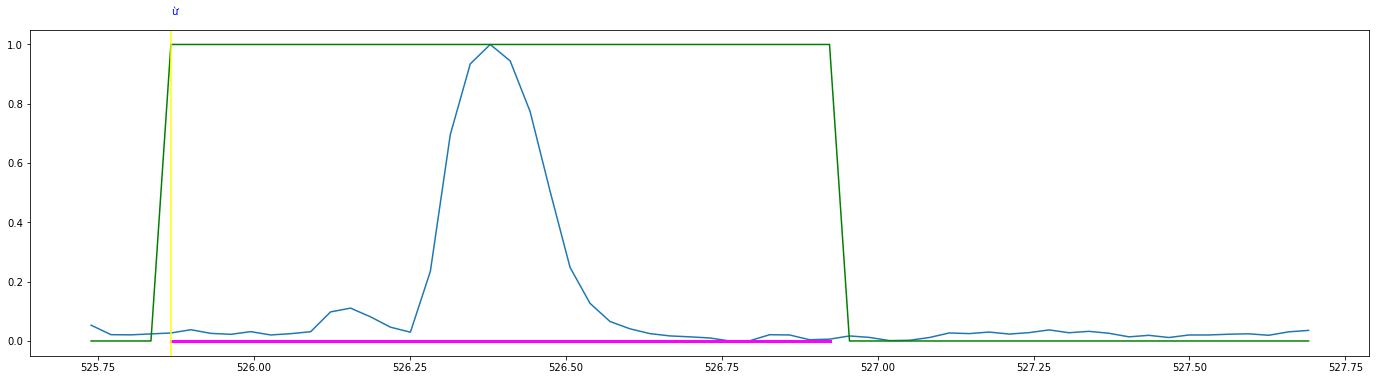

16460 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460]
READ_HEAD 16460
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(966, 969)]
cutoff -78.44221105527639 #silences 9: [(963,

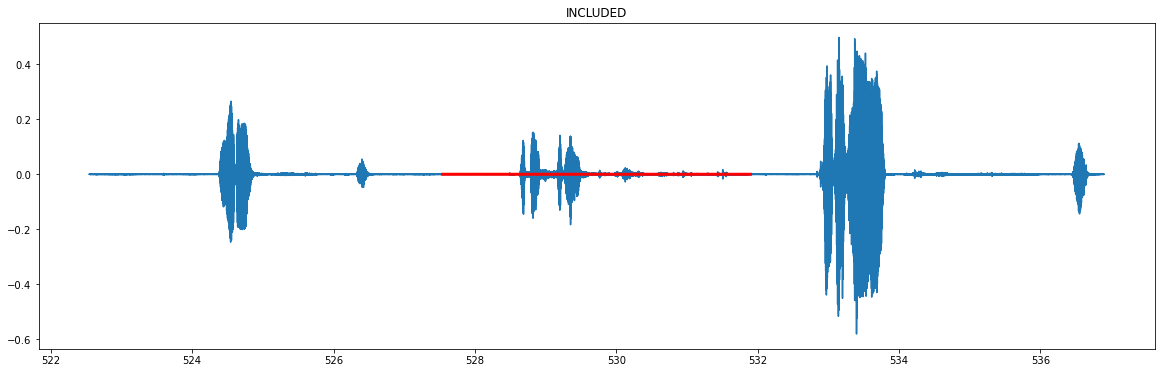

[NeMo I 2020-10-30 00:00:57 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:57 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ím biết chứ liền|
empty translation
16622 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622]
READ_HEAD 16622
cutoff -80.0 

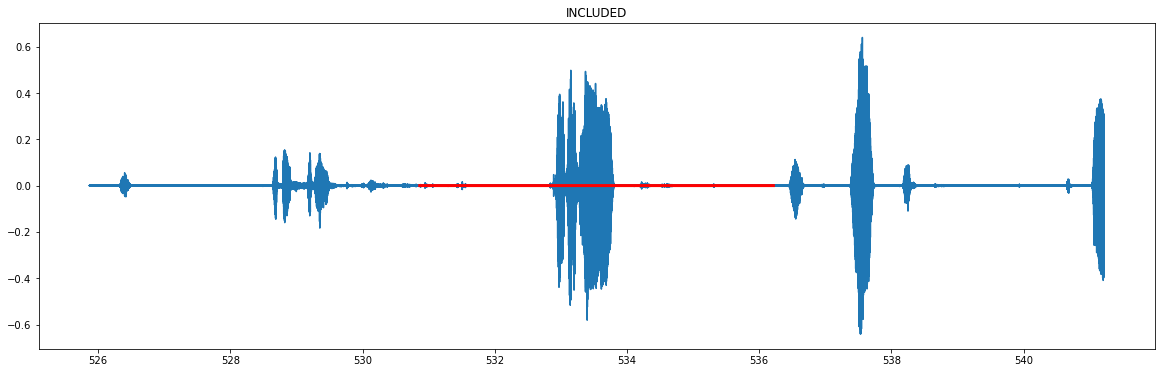

[NeMo I 2020-10-30 00:00:57 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:57 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |thế hày gả|


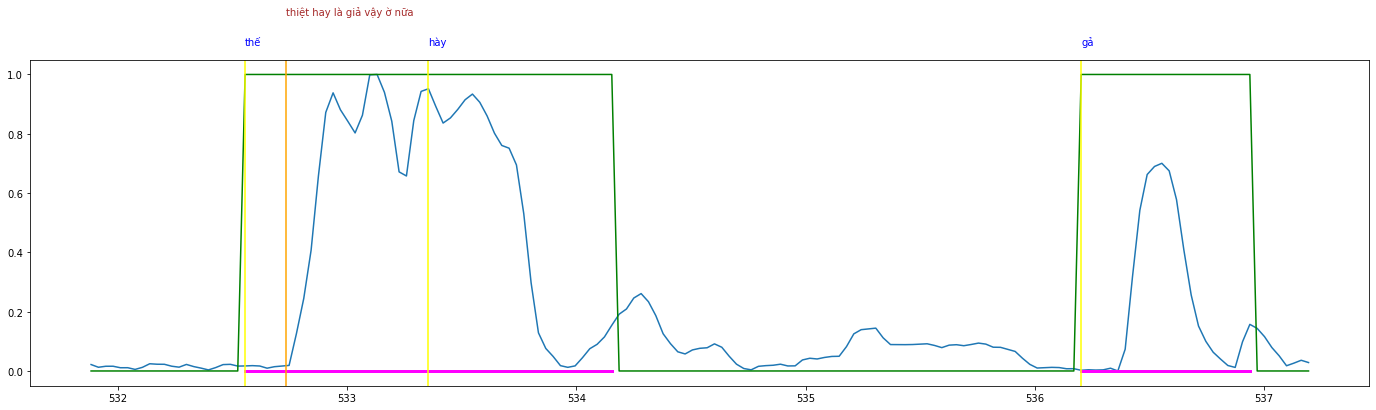

16757 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757]
READ_HEAD 16757
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(669, 672)]
cutoff -78.44221105527639 #sile

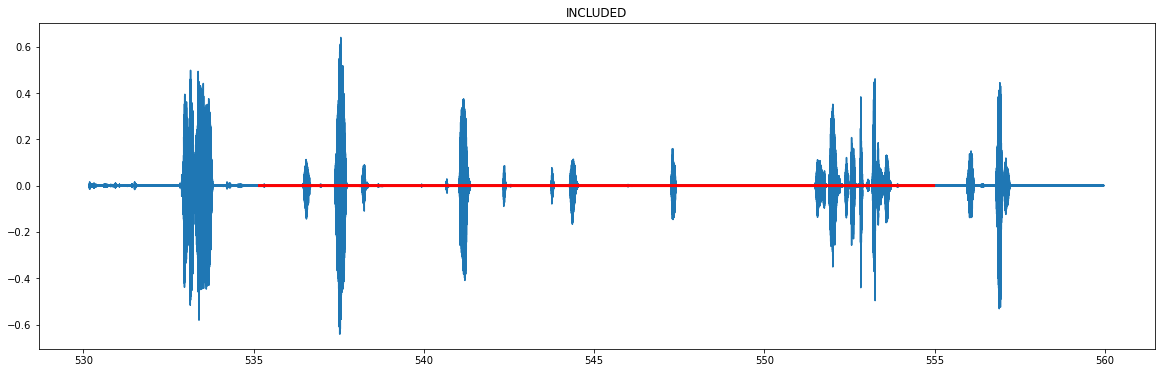

[NeMo I 2020-10-30 00:00:58 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:58 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừ lữa trờ ừ ờ ừ không có thi em về em đặp chịt chết luồn|


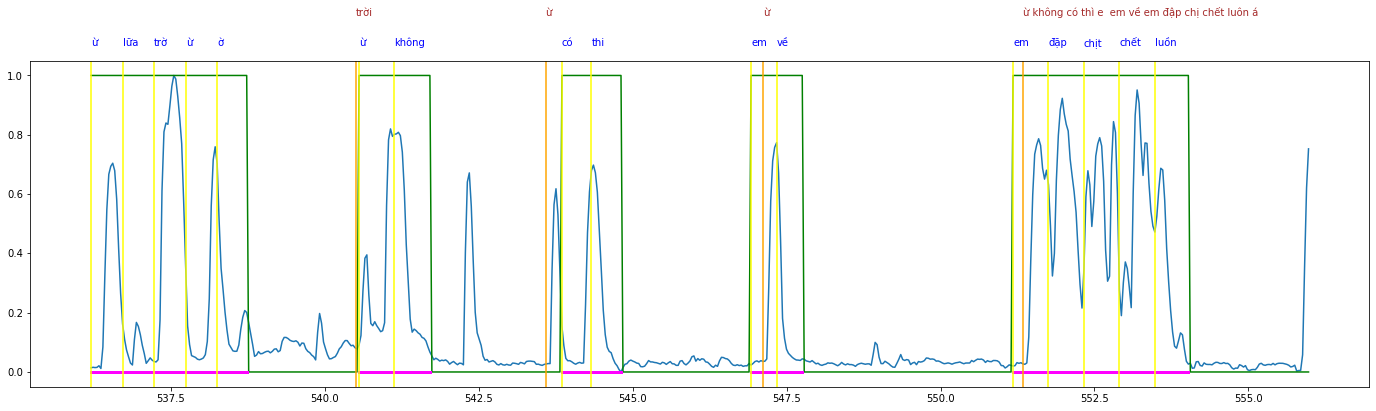

17344 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344]
READ_HEAD 17344
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(82, 85)]
stop to read 17344 17426


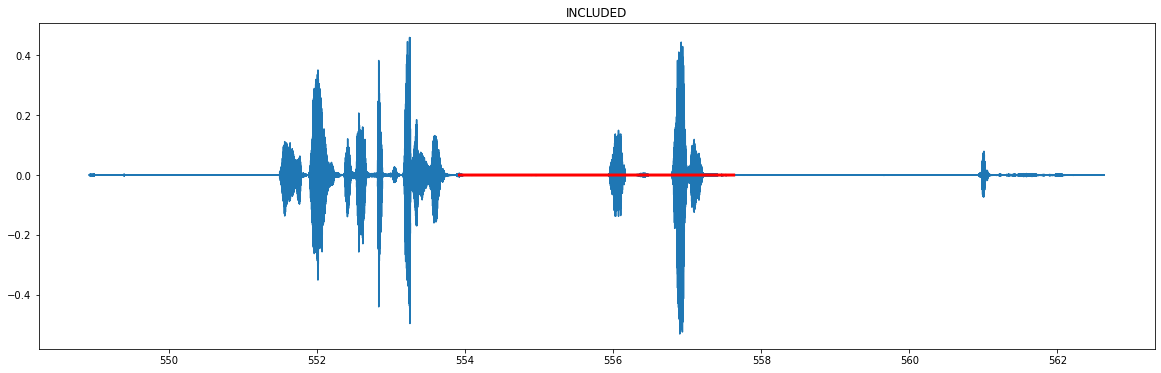

[NeMo I 2020-10-30 00:00:58 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:58 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |thếc không|


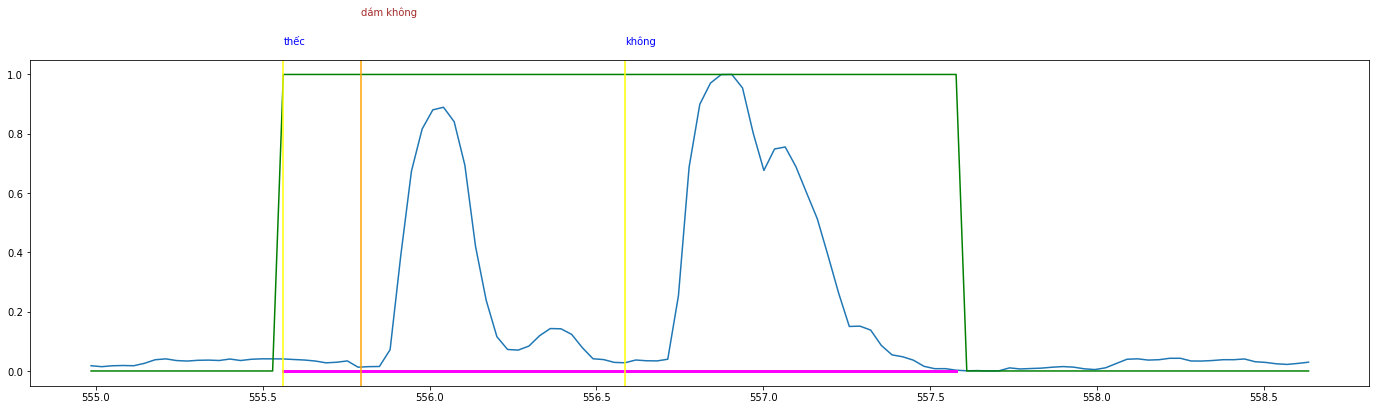

17426 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426]
READ_HEAD 17426
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 1: [(0, 3)]
advance past silence 

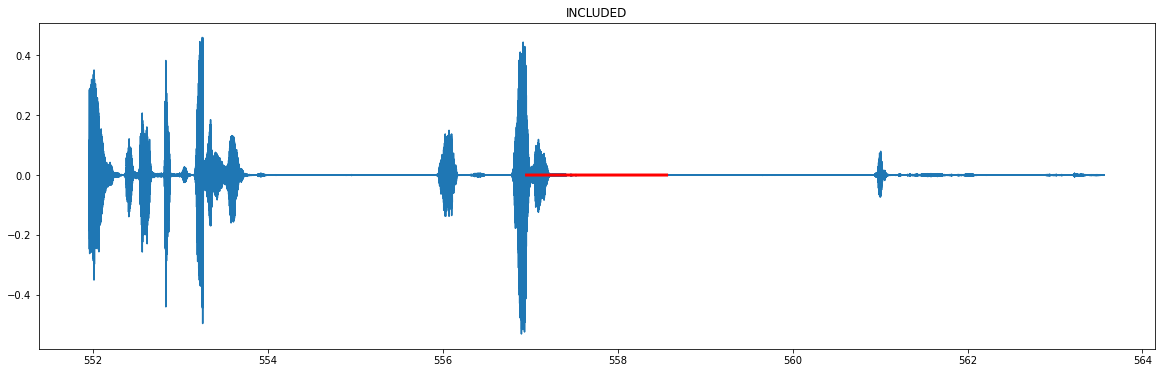

[NeMo I 2020-10-30 00:00:58 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:58 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |cóng|


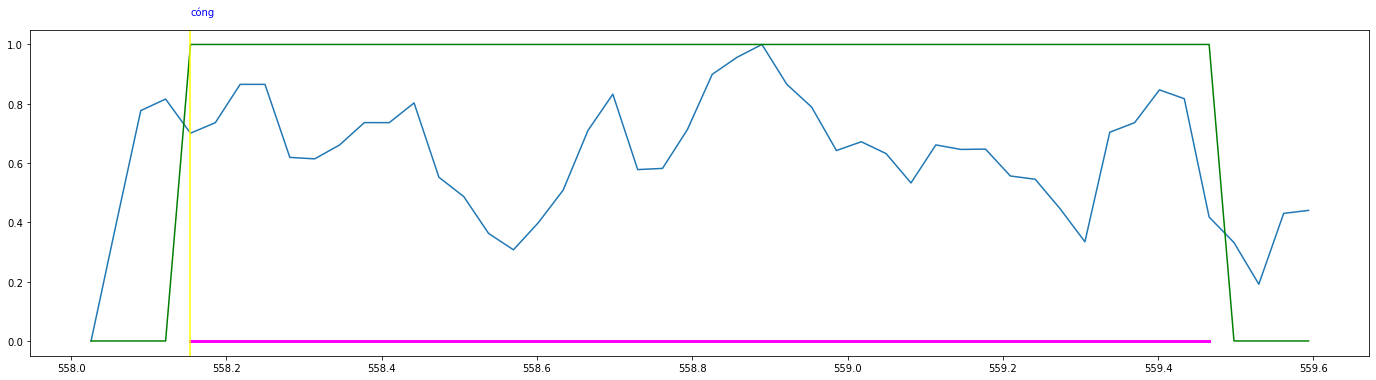

17455 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455]
READ_HEAD 17455
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff -78.442211055

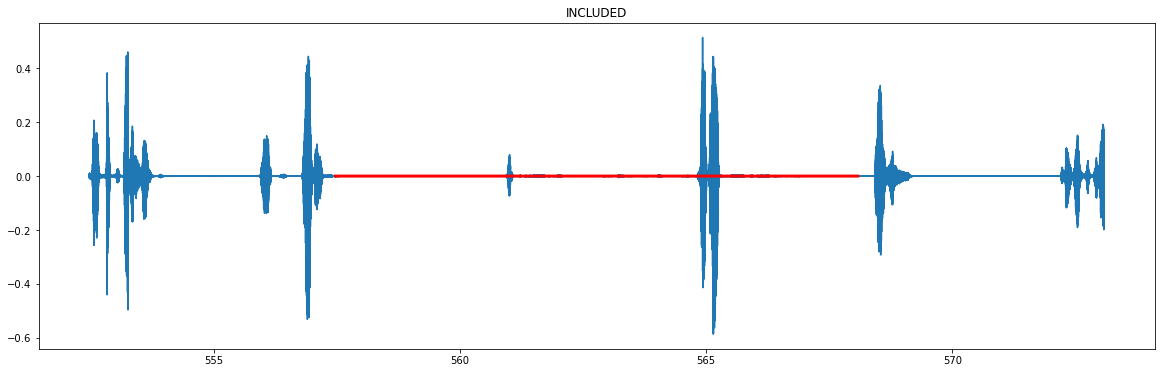

[NeMo I 2020-10-30 00:00:59 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:59 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |giờ chưa|
empty translation
17753 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753]
RE

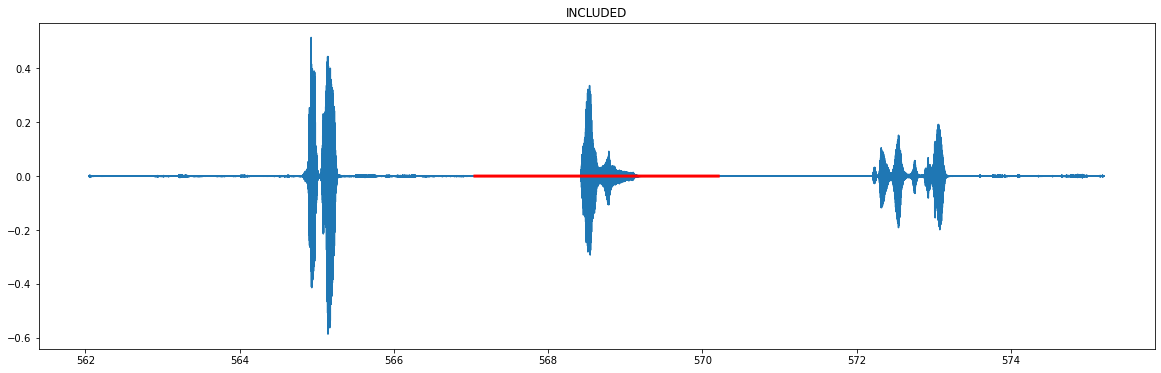

[NeMo I 2020-10-30 00:00:59 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:59 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |cồi ơ thái|


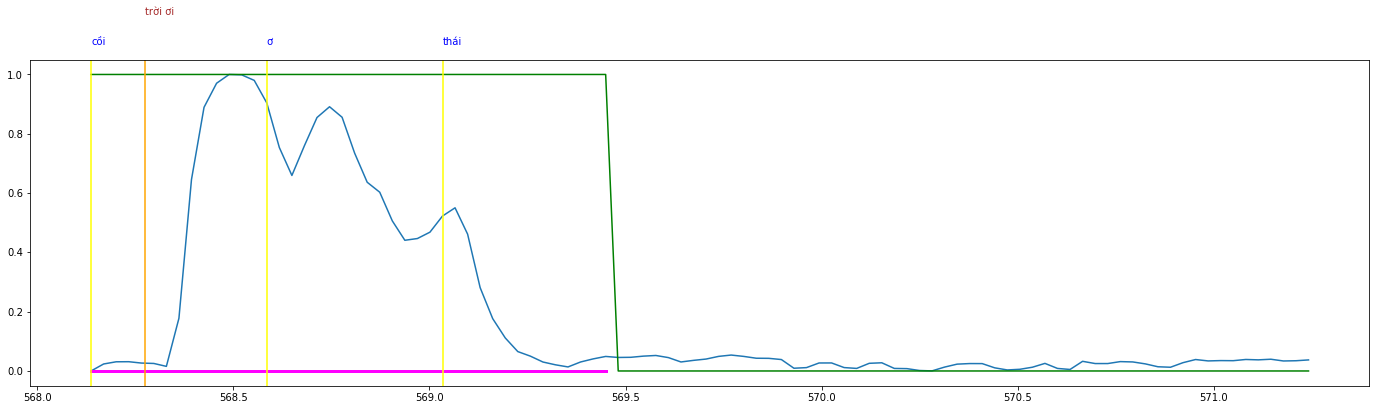

17819 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753, 17819]
READ_HEAD 17819
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []
cutoff

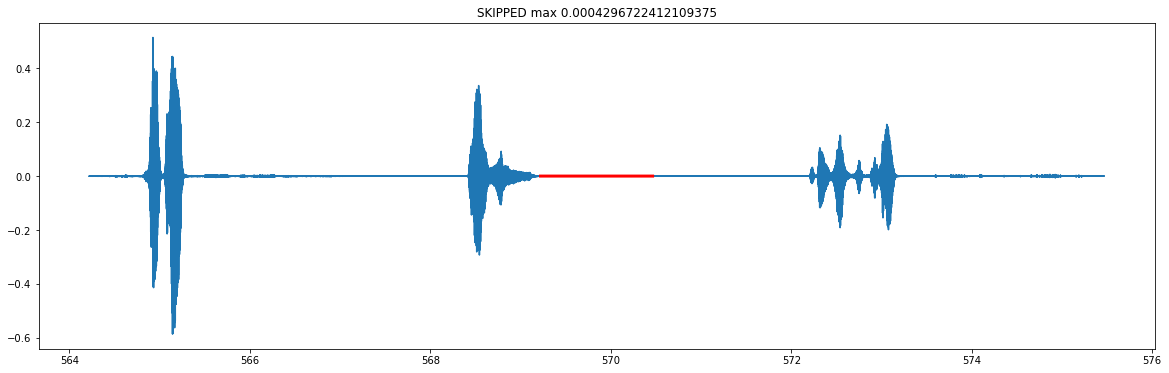

17827 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753, 17819, 17827]
READ_HEAD 17827
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silences 0: []

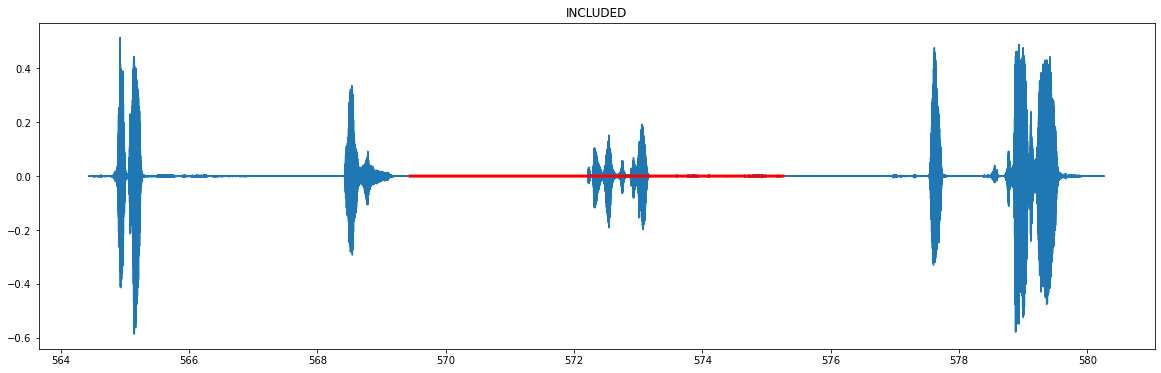

[NeMo I 2020-10-30 00:00:59 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:00:59 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ai òn ghiều phúc cuá vậ|


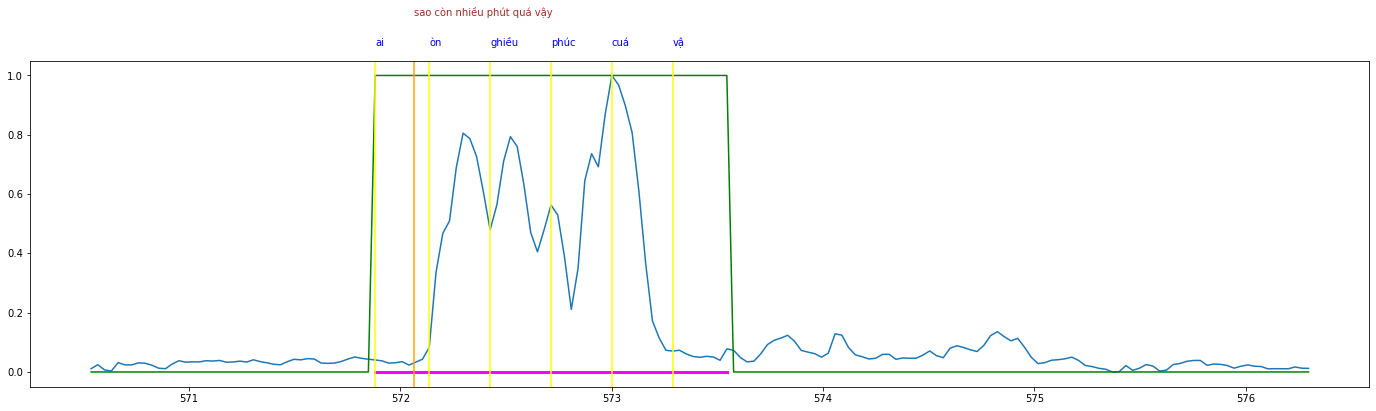

17977 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753, 17819, 17827, 17977]
READ_HEAD 17977
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #silence

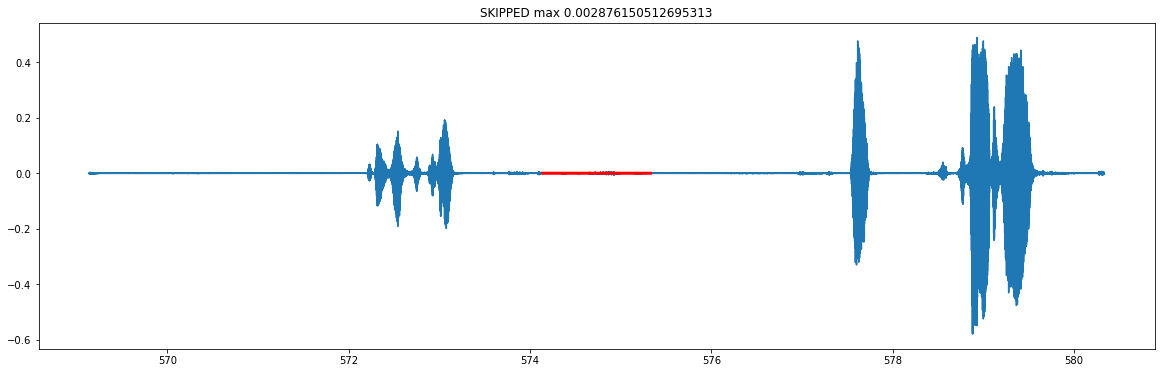

17979 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753, 17819, 17827, 17977, 17979]
READ_HEAD 17979
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7537688442211 #

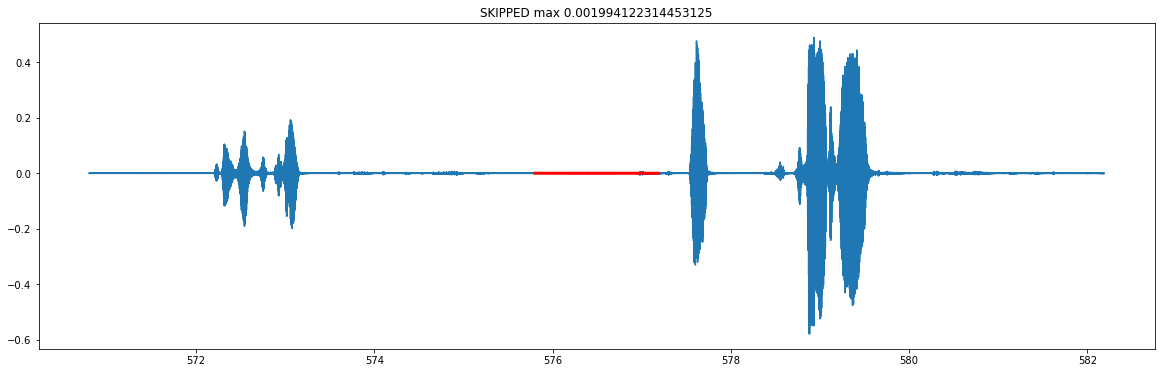

18037 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753, 17819, 17827, 17977, 17979, 18037]
READ_HEAD 18037
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.75376884

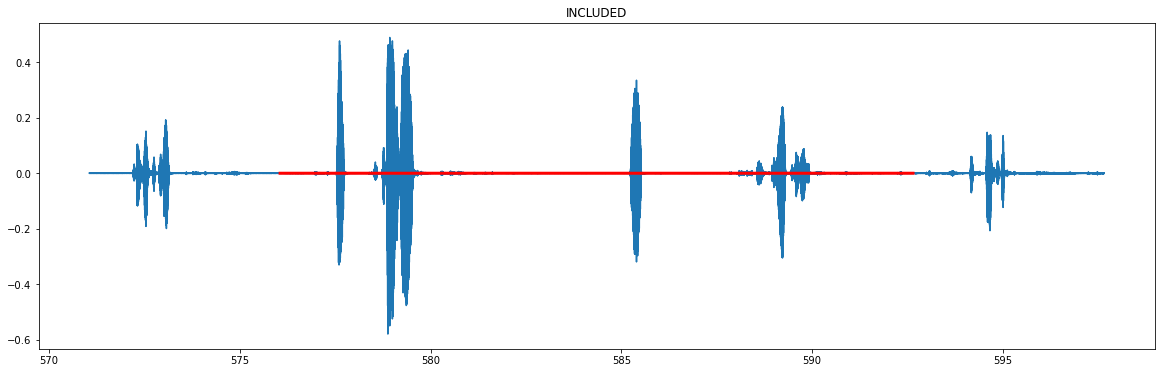

[NeMo I 2020-10-30 00:01:00 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-30 00:01:00 collections:174] 0 files were filtered totalling 0.00 hours
PREDICTION |ừ ngày mai đó ha có ờ c được ở là đâu quá|


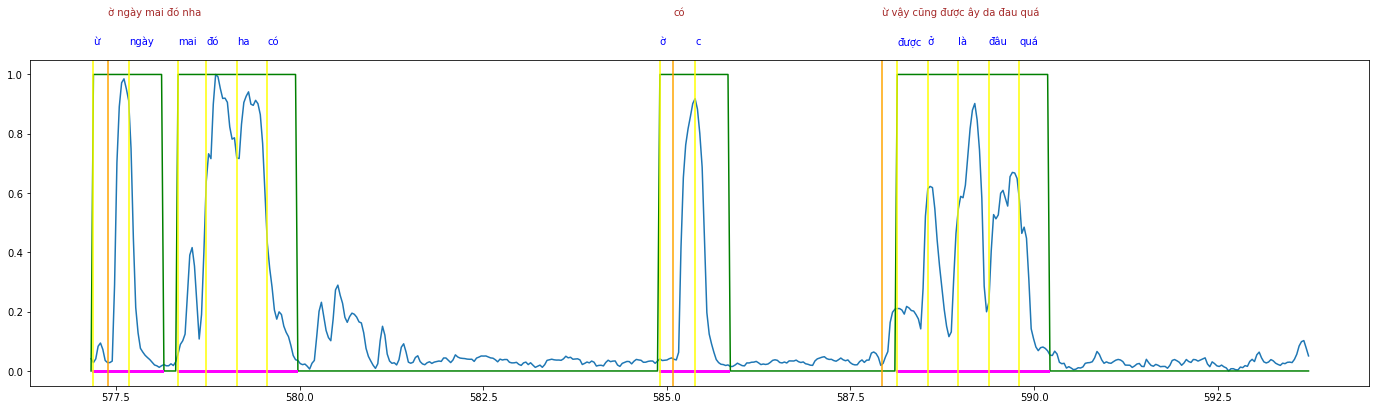

18521 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753, 17819, 17827, 17977, 17979, 18037, 18521]
READ_HEAD 18521
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutoff -78.7

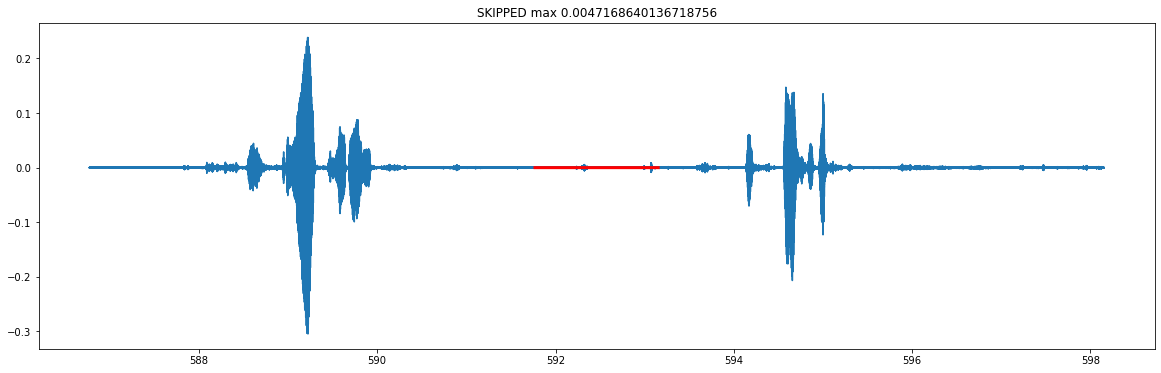

18536 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753, 17819, 17827, 17977, 17979, 18037, 18521, 18536]
READ_HEAD 18536
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: []
cutof

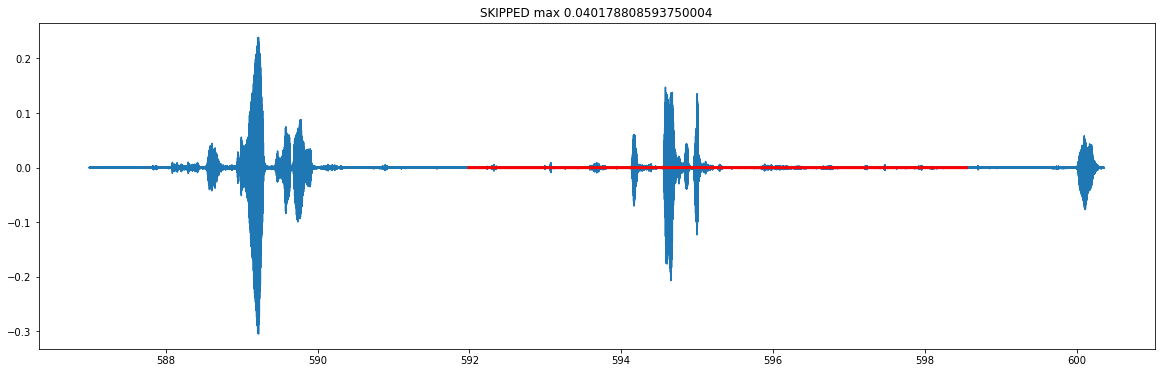

18705 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753, 17819, 17827, 17977, 17979, 18037, 18521, 18536, 18705]
READ_HEAD 18705
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silences 0: [

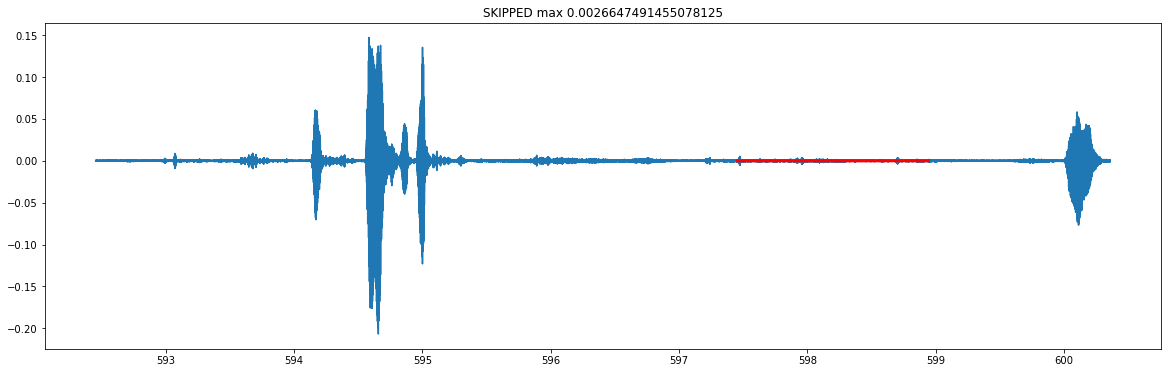

18717 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753, 17819, 17827, 17977, 17979, 18037, 18521, 18536, 18705, 18717]
READ_HEAD 18717
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 #silenc

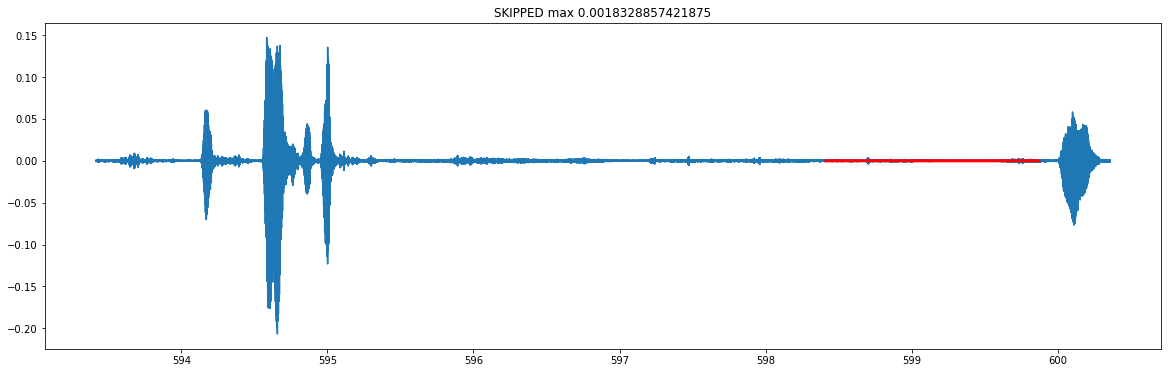

18746 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753, 17819, 17827, 17977, 17979, 18037, 18521, 18536, 18705, 18717, 18746]
READ_HEAD 18746
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663316582 

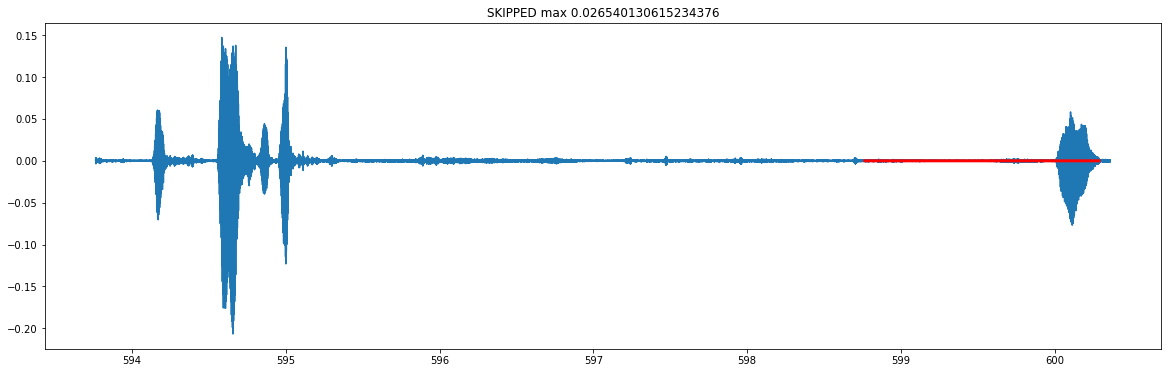

18759 [0, 557, 573, 1194, 1207, 1211, 1242, 1243, 1466, 1712, 1994, 2003, 2007, 2024, 2490, 2583, 2702, 2720, 2953, 3412, 3418, 3509, 3561, 3782, 3789, 3790, 3797, 3958, 3984, 4208, 4213, 4225, 4229, 4260, 4456, 5023, 5109, 5230, 5262, 5327, 5353, 5355, 5374, 5377, 5389, 5510, 6024, 6560, 6694, 7143, 7154, 7588, 7825, 7892, 7928, 7943, 8242, 8251, 8442, 8494, 8667, 8681, 8707, 8841, 8952, 9358, 9634, 10038, 10053, 10651, 10669, 11015, 11093, 11615, 11623, 11789, 12380, 12435, 12773, 12778, 12790, 13060, 13081, 13358, 13366, 13373, 13380, 13383, 13389, 13390, 13404, 13441, 13456, 13704, 13714, 13768, 13945, 14468, 14888, 15061, 15065, 15084, 15124, 15156, 15534, 15540, 15964, 15981, 16087, 16172, 16356, 16364, 16430, 16460, 16622, 16757, 17344, 17426, 17455, 17753, 17819, 17827, 17977, 17979, 18037, 18521, 18536, 18705, 18717, 18746, 18759]
READ_HEAD 18759
cutoff -80.0 #silences 0: []
cutoff -79.68844221105527 #silences 0: []
cutoff -79.37688442211055 #silences 0: []
cutoff -79.06532663

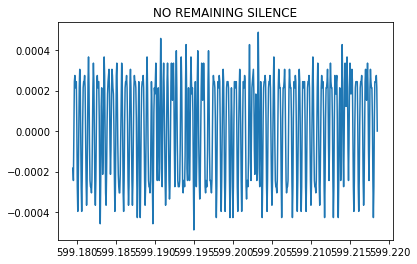

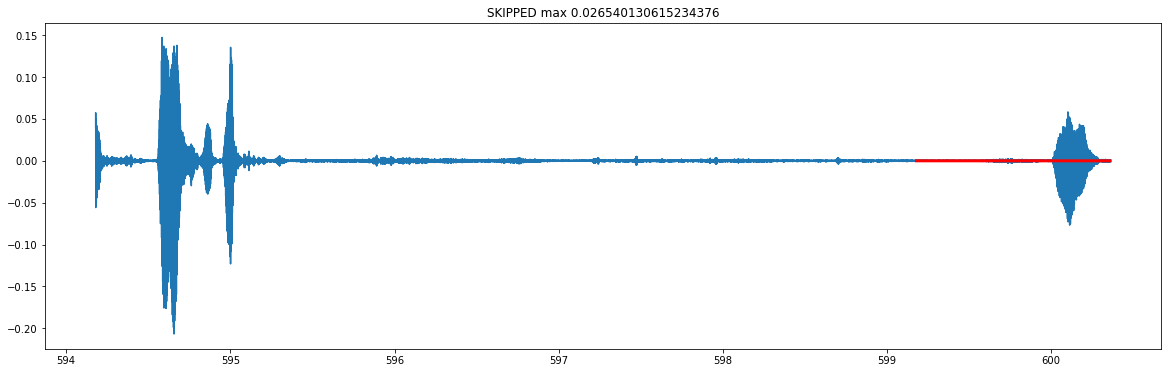

In [256]:
while read_head < max_read_head:
    print(read_head, read_heads)
    finished = False
    while not finished and read_head < max_read_head:
        print(f"READ_HEAD {read_head}")
        for cutoff in cutoffs:
            speech_q=(s_dB_mean[read_head:]>cutoff)
            silences=collect_false(speech_q)
            silences=[(x,y) for x,y in silences if x != y and y-x > min_samples]
            n_silences = len(silences)
            print(f'cutoff {cutoff} #silences {n_silences}: {silences[0:10]}')
            if n_silences==0:
                continue
            elif silences[0][0] == 0 and silences[0][1] != 0:
                read_head +=silences[0][1]
                print("advance past silence", read_head, silences[0][1])
                continue
            elif silences[0][0] > max_samples:
                continue
            else:
                silences=[(x,y) for x,y in silences if y <= max_samples]
                start_at = read_head
                stop_at= read_head + silences[-0][0]
                read_head = stop_at
                print("stop to read", start_at, stop_at)
                finished = True
                break
        if not finished:
            display_start=read_head*samples_per_spect
            display_end=display_start+max_samples
            plot(X[display_start:display_end],audio[display_start:display_end])
            title(f'NO REMAINING SILENCE')
            show()
            start_at = read_head
            stop_at = min(max_read_head, read_head + max_samples)
            read_head = stop_at

    read_heads.append(read_head)
    start=start_at*samples_per_spect
    end=start_at+stop_at*samples_per_spect

    figure(figsize=(20,6))
    display_start=max(0, start-5*C.sample_rate)
    display_end=end+5*C.sample_rate
    smooth_abs=smoothhtooms(np.abs(audio[start:end]), 100)
    smooth_abs_max=smooth_abs.max()
    if smooth_abs_max < 0.05:
        plot(X[display_start:display_end],audio[display_start:display_end])
        plot(X[start:end],Z[start:end],color='red',linewidth=3)
        title(f'SKIPPED max {smooth_abs_max}')
        show()
    else:
        plot(X[display_start:display_end],audio[display_start:display_end])
        plot(X[start:end],Z[start:end],color='red',linewidth=3)
        title('INCLUDED')
        show()
        try:
            segment_transcript, timeline, normalized_power, speech_mask, clip_audio=predicted_segment_transcript(C, model, audio, start, end, s_dB_mean, samples_per_spect, dt_S)
            transcriptions.extend(segment_transcript)
            plot_predicted_segments(timeline, normalized_power, speech_mask, segment_transcript, gold)
            show()
        except:
            print("empty translation")

In [259]:
len(transcriptions)

425

In [253]:
read_head, max_read_head

(18761, 18762)

In [245]:
max_samples

625